<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>1. Setup Environment</h2>
</div>

In [1]:
# import libraries
import pandas as pd
import numpy as np

# For Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Pandas Settings
# pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_rows', 40000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Miscellaneous imports
from datetime import datetime
from scipy.stats import norm
import re

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>2. Load Data</h2>
</div>

##### Reading the main data file - ConsumerElectronics.csv into a dataframe

In [ ]:
main_df = pd.read_csv('ConsumerElectronics.csv')
main_df.head()

##### Reading the product list excel data file into a dataframe

In [ ]:
product_list = pd.read_excel('Media data and other information.xlsx', sheet_name='Product List')
product_list.columns.values[1]='product_analytic_vertical'
product_list.drop(product_list.columns[0], axis=1, inplace = True)
product_list.head()

##### Reading the Media Investment excel data file into a dataframe

In [ ]:
media_investment = pd.read_excel('Media data and other information.xlsx', sheet_name='Media Investment', skiprows=2)

media_investment.drop(media_investment.columns[0], axis=1, inplace = True)

media_investment.head()

##### Reading the Sale Calendar excel data file into a dataframe

In [ ]:
sale_calendar = pd.read_excel('Media data and other information.xlsx', sheet_name='Special Sale Calendar', \
                              skiprows=0, skipfooter=2)

sale_calendar.drop(sale_calendar.columns[0], axis=1, inplace = True)

sale_calendar.iloc[1:6, 0] = sale_calendar.iloc[0, 0]
sale_calendar.iloc[7:, 0] = sale_calendar.iloc[6, 0]

sale_calendar

##### Reading the net_promoter_score excel file into a dataframe

In [ ]:
net_promoter_score = pd.read_excel('Media data and other information.xlsx', sheet_name='Monthly NPS Score', \
                              skiprows=0)

# net_promoter_score.columns.values[0]='score'

net_promoter_score

##### Reading the product details word file into a dataframe

In [ ]:
# !pip install python-docx

In [ ]:
# pip install --pre python-docx
import pandas as pd
import io
import csv
from docx import Document

def read_docx_tables(filename, tab_id=None, **kwargs):
    """
    parse table(s) from a Word Document (.docx) into Pandas DataFrame(s)

    Parameters:
        filename:   file name of a Word Document

        tab_id:     parse a single table with the index: [tab_id] (counting from 0).
                    When [None] - return a list of DataFrames (parse all tables)

        kwargs:     arguments to pass to `pd.read_csv()` function

    Return: a single DataFrame if tab_id != None or a list of DataFrames otherwise
    """
    def read_docx_tab(tab, **kwargs):
        vf = io.StringIO()
        writer = csv.writer(vf)
        for row in tab.rows:
            writer.writerow(cell.text for cell in row.cells)
        vf.seek(0)
        return pd.read_csv(vf, **kwargs)

    doc = Document(filename)
    if tab_id is None:
        return [read_docx_tab(tab, **kwargs) for tab in doc.tables]
    else:
        try:
            return read_docx_tab(doc.tables[tab_id], **kwargs)
        except IndexError:
            print('Error: specified [tab_id]: {}  does not exist.'.format(tab_id))
            raise

dfs = read_docx_tables('Product Details.docx')

dfs[0]

In [ ]:
# Dropping the extra row(s)/column(s)

product_details = pd.DataFrame(dfs[0])

product_details.drop(product_details.columns[0], axis=1, inplace = True)

product_details.head()

In [ ]:
main_df.head()

In [ ]:
main_df.dtypes

## Correcting Data Types

In [ ]:
# String to datetime

main_df['order_date'] =  pd.to_datetime(main_df['order_date'], format='%Y-%m-%d %H:%M:%S')

In [ ]:
# Int to string

main_df[['order_id','order_item_id']] = main_df[['order_id','order_item_id']].astype(object)

In [ ]:
# Int to string

main_df[['Year','Month']] = main_df[['Year','Month']].astype(str)

##### Assuming "\N" value in deliverybdays & deliverycdays is equal to 0, will impute the nulls created by it with 0

In [ ]:
main_df['deliverybdays'] = pd.to_numeric(main_df['deliverybdays'], errors='coerce')
main_df['deliverybdays'].fillna(value=0, inplace=True)

main_df['deliverycdays'] = pd.to_numeric(main_df['deliverycdays'], errors='coerce')
main_df['deliverycdays'].fillna(value=0, inplace=True)

In [ ]:
# String to int

main_df['gmv'] = pd.to_numeric(main_df['gmv'], errors='coerce')

In [ ]:
main_df.dtypes

## Unique Values

In [ ]:
# Unique value frequencies

unique_values = pd.DataFrame(main_df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)

unique_values['dtype'] = pd.DataFrame(main_df.dtypes)

unique_values

In [ ]:
initial_shape = main_df.shape
initial_shape

## Fix Invalid Values

### Treating incorrect GMV values w.r.t product_mrp * units

In [ ]:
# Instances where GMV values are greater than MRP * units which is incorrect

print(main_df.loc[main_df['product_mrp'] * main_df['units'] < main_df['gmv']].shape[0])

print(round(100*(main_df.loc[main_df['product_mrp'] * main_df['units'] < main_df['gmv']].shape[0] / main_df.shape[0]), 2))

In [ ]:
# update column based on another column
main_df.product_mrp = np.where(main_df['product_mrp'] < main_df['gmv'] / main_df['units'], \
                                   main_df['gmv'] / main_df['units'], main_df['product_mrp'])

main_df.shape

Reinspecting instances where GMV value is greater than the MRP * units.

In [ ]:
# Instances where GMV values are greater than MRP * units which is incorrect

print(main_df.loc[main_df['product_mrp'] * main_df['units'] < main_df['gmv']].shape[0])

print(round(100*(main_df.loc[main_df['product_mrp'] * main_df['units'] < main_df['gmv']].shape[0] / main_df.shape[0]), 2))

*All erroneous instances were removed*

### Treating GMV values less than `0`

In [ ]:
print(main_df.loc[main_df['gmv'] < 0].shape[0])

print(round(100*(main_df.loc[main_df['gmv'] < 0].shape[0]/main_df.shape[0]), 2))

### Treating MRP values less than or equal to `0`

In [ ]:
print(main_df.loc[main_df['product_mrp'] < 0].shape[0])

print(round(100*(main_df.loc[main_df['product_mrp'] < 0].shape[0]/main_df.shape[0]), 2))

### Treating Units values less than or equal to `0`

In [ ]:
print(main_df.loc[main_df['units'] <= 0].shape[0])

print(round(100*(main_df.loc[main_df['units'] <= 0].shape[0]/main_df.shape[0]), 2))

*No erroneous rows left in MRP, GMV or Units columns*

### Handling Negative values for `deliverybdays` & `deliverycdays`

In [ ]:
print(main_df.loc[main_df['deliverybdays'] < 0].shape[0])
print(round(100*(main_df.loc[main_df['deliverybdays'] < 0].shape[0]/main_df.shape[0]),4))

print(main_df.loc[main_df['deliverycdays'] < 0].shape[0])
print(round(100*(main_df.loc[main_df['deliverycdays'] < 0].shape[0]/main_df.shape[0]),4))

 - There are `38` records(`0.0023%`) in the dataframe with negative values for deliverybdays.
 - There are `39` records(`0.0024%`) in the dataframe with negative values for deliverycdays.
 
We will be dropping such rows since it is not possible for a product to have negative values for Dispatch Delay from Warehouse and to customer.

In [ ]:
main_df = main_df.loc[(main_df['deliverybdays'] >= 0) & (main_df['deliverycdays'] >= 0)]

main_df.reset_index(drop=True, inplace=True)

In [ ]:
main_df.shape

### Handling Negative values for `product_procurement_sla`

In [ ]:
print(main_df.loc[main_df['product_procurement_sla'] < 0].shape[0])

print(round(100*(main_df.loc[main_df['product_procurement_sla'] < 0].shape[0]/main_df.shape[0]),4))

 - There are `75986` records(`4.61%`) in the dataframe with negative values for product_procurement_sla.
 
We will be dropping such rows since it is not possible for a product to have negative values for time typically taken to procure it.

In [ ]:
main_df = main_df.loc[(main_df['product_procurement_sla'] >= 0)]

main_df.reset_index(drop=True, inplace=True)

In [ ]:
main_df.shape

### Handling large values for product_procurement_sla

In [ ]:
main_df[['product_procurement_sla']].describe().T

In [ ]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(6, 4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("whitegrid") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

main_df.product_procurement_sla.hist()

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

In [ ]:
main_df.product_procurement_sla.value_counts()

In [ ]:
print(main_df.loc[main_df['product_procurement_sla'] >= 1000].shape[0])

print(round(100*(main_df.loc[main_df['product_procurement_sla'] >= 1000].shape[0]/main_df.shape[0]),4))

 - There are `4745` records(`0.3%`) in the dataframe with unusually large values of product_procurement_sla.
 
We will be dropping such rows since it is not possible for a product to have product_procurement_sla more than 1000

Retaining rows where the sla is less than 1000

In [ ]:
#Retaining rows where the sla is less than 1000

main_df = main_df.loc[(main_df['product_procurement_sla'] < 1000)]
main_df.head()

In [ ]:
main_df.shape

In [ ]:
main_df.info()

## De-Duplicate Data

##### Make all string columns lower case

In [ ]:
cat_cols = [cname for cname in main_df.columns if main_df[cname].dtype == "object"]

cat_cols

In [ ]:
# Filtering the string columns

cat_cols = ['fsn_id',
 's1_fact.order_payment_type',
 'product_analytic_super_category',
 'product_analytic_category',
 'product_analytic_sub_category',
 'product_analytic_vertical']

for col in cat_cols:
    main_df[col] = main_df[col].str.lower()

##### Spelling check by investigating the unique values

In [ ]:
cat_cols = [cname for cname in main_df.columns if main_df[cname].dtype == "object"]

main_df[cat_cols].describe()

In [ ]:
# Checking only those columns whose cardinality is less

selected_cat_cols = ['s1_fact.order_payment_type', 'product_analytic_super_category', 'product_analytic_category', 'product_analytic_sub_category', 'product_analytic_vertical']

for col in selected_cat_cols:
    print('\n################################')
    print('Unique values of ' + str(col))
    print('################################')
    print(pd.Series(main_df[col].unique()).sort_values(ascending=False))

There are no duplicates due to spelling mistakes

##### Drop duplicate rows

In [ ]:
main_df.shape

In [ ]:
print(main_df.duplicated().value_counts()[1])

print(round(100*(main_df.duplicated().value_counts()[1]/main_df.shape[0]),4))

##### Around 99283 (6.33%) rows have duplicates. We will go ahead and drop them.

In [ ]:
main_df.drop_duplicates(keep='first', inplace=True)
main_df.shape

In [ ]:
main_df.duplicated().value_counts()

*No more duplicates*

## Treating Nulls

In [ ]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(main_df.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(main_df.isnull().sum()/main_df.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])

pd.concat([total, percentage], axis = 1).head()

In [ ]:
main_df.replace(' ', np.nan, inplace = True)

### Again trying to find null percentage in columns

In [ ]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(main_df.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(main_df.isnull().sum()/main_df.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1).head()

### Removing rows where a particular column has high missing values

In [ ]:
# removing rows where a particular column has high missing values because the column cannot be removed because of its importance
main_df = main_df[~pd.isnull(main_df['gmv'])]
org_shape = main_df.shape
org_shape

### Again trying to find null percentage in columns

In [ ]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(main_df.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(main_df.isnull().sum()/main_df.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])
pd.concat([total, percentage], axis = 1).head()

*Changing the datatype of the column 'order_date' to `datetime64`*

In [ ]:
main_df.dtypes

*Identifying the data outside our analysis period - `01-Jul-2015 to 30-Jun-2016`*

In [ ]:
main_df.loc[(main_df['order_date'].dt.floor("d") < '2015-07-01') | (main_df['order_date'].dt.floor("d") >= '2016-07-01')].shape

In [ ]:
main_df = main_df.loc[(main_df['order_date'].dt.floor("d") >= '2015-07-01') & (main_df['order_date'].dt.floor("d") < '2016-07-01')]
main_df.shape

In [ ]:
Max = pd.DataFrame(main_df[['order_date']].max().rename('Max'))
Min = pd.DataFrame(main_df[['order_date']].min().rename('Min'))

pd.concat([Min, Max], axis=1)

This verifies that our dataframe has data between July 2015 and June 2016 only.

## Generate Week Column

In [ ]:
# Creating a new column into a specific position in a DataFrame
loc_index = main_df.columns.get_loc('Month') + 1
main_df.insert(loc=loc_index,column='Week',value=main_df['order_date'].dt.strftime("%V"))

main_df['Year'] = main_df['Year'].astype('str')
main_df.head()

In [ ]:
# Checking the combinations for any discrepancies

main_df.groupby(['Year', 'Week']).agg({'Month':"count"}).reset_index(drop=False)

In [ ]:
# Updating the year as 2015 for the week whose week# is 53 but belongs to 2016 for consistency with the other data sets

# Updating the month as 12 for the above rows for consistency

# Dropping rows (less in number) with week# 27 as it belongs to the weeks in June 2015

main_df.loc[(main_df.Year == '2016') & (main_df.Week == '53'), 'Year'] = '2015'

main_df.loc[(main_df.Year == '2015') & (main_df.Week == '53'), 'Month'] = 12

main_df.drop(main_df[main_df['Week'] == '27'].index, inplace = True)

In [ ]:
main_df.groupby(['Year', 'Week']).agg({'Month':"count"}).reset_index(drop=False)

## Drop Insignificant Columns

In [ ]:
main_df.info()

In [ ]:
# Dropping Columns with Single Value or all Different Values

count_df = pd.DataFrame(main_df.apply(lambda x: len(x.value_counts()), axis=0), columns=['Count'])

drop_columns = list(count_df.loc[(count_df['Count']==1) | (count_df['Count']==len(main_df.index))].index)

print('Dropping these columns => {}'.format(drop_columns))

main_df.drop(drop_columns, axis=1, inplace=True)

In [ ]:
# Dropping Columns which are insignificant to the analysis

drop_columns = ['fsn_id', 'order_id', 'order_item_id', 'cust_id']

main_df.drop(drop_columns, axis=1, inplace=True)

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>4. Feature Engineering</h2>
</div>

In [ ]:
main_df.head()

### Creating column `List Price`

*List Price = GMV/Units*

In [ ]:
# Creating a new column into a specific position in a DataFrame
loc_index = main_df.columns.get_loc('gmv') + 1
main_df.insert(loc=loc_index,column='list_price',value = main_df['gmv'] / main_df['units'])
main_df.head()

*Displaying the column values for a few orders when units > 1*

In [ ]:
main_df.loc[main_df['units'] != 1][['gmv','list_price','product_mrp','units']].head()

### Creating a Payday Flag (+- 1 for salary days) 

*If it is nearer to the salary day in Ontario(1st and 15th of every month), we flag the column as 1, else as 0*

In [ ]:
main_df['payday_flag'] = main_df['order_date'].apply(lambda x:1 if x.strftime('%d') in ('14','15','16','30','31','1','2') else 0)
main_df.head()

### Creating an Occassion Flag 

*If it is a Holiday/Occassion in Ontario, we flag the column as 1, else as 0*

The following table lists all the holidays/occassions from 1st July, 2015 to 30th June, 2016**

|Occassion|Day|
|---------|---|
|Canada Day	|July 1, 2015|
|Civic Holiday|	August 3, 2015|
|Labour Day	|September 7, 2015 |
|Thanksgiving|	October 12, 2015|
|Halloween	|October 31, 2015|
|Remembrance Day|	November 11, 2015|
|Christmas Day	|December 25, 2015|
|Boxing Day	|December 26, 2015|
|New Year's Day	|January 1, 2016|
|Islander Day	|February 15, 2016|
|Louis Riel Day	|February 15, 2016|
|Heritage Day	|February 15, 2016|
|Family Day	|February 15, 2016|
|Valentine's Day	|February 14, 2016|
|Leap Day	|February 29, 2016|
|St. Patrick's Day	|March 17, 2016|
|Good Friday	|March 25, 2016|
|Easter Monday	|March 28, 2016|
|Mother's Day	|May 8, 2016|
|Victoria Day	|May 23, 2016|
|Father's Day	|June 19, 2016|
|Aboriginal Day	|June 21, 2016|
|St. Jean Baptiste Day	|June 24, 2016|

**reference link: https://www.statutoryholidays.com/

In [ ]:
def holidayflg(ord_date):
    if ord_date.strftime('%Y') == 2015:
        if ord_date.strftime('%m') == '07' and ord_date.strftime('%d') == '01':
            return 1
        elif ord_date.strftime('%m') == '08' and ord_date.strftime('%d') == '03':
            return 1
        elif ord_date.strftime('%m') == '09' and ord_date.strftime('%d') == '07':
            return 1
        elif ord_date.strftime('%m') == '10' and ord_date.strftime('%d') == '12':
            return 1
        elif ord_date.strftime('%m') == '10' and ord_date.strftime('%d') == '31':
            return 1
        elif ord_date.strftime('%m') == '11' and ord_date.strftime('%d') == '11':
            return 1
        elif ord_date.strftime('%m') == '12' and ord_date.strftime('%d') == '25':
            return 1
        elif ord_date.strftime('%m') == '12' and ord_date.strftime('%d') == '26':
            return 1
        else:
            return 0
    else:
        if ord_date.strftime('%m') == '01' and ord_date.strftime('%d') == '01':
            return 1
        elif ord_date.strftime('%m') == '02' and ord_date.strftime('%d') == '15':
            return 1
        elif ord_date.strftime('%m') == '02' and ord_date.strftime('%d') == '14':
            return 1
        elif ord_date.strftime('%m') == '02' and ord_date.strftime('%d') =='29':
            return 1
        elif ord_date.strftime('%m') == '03' and ord_date.strftime('%d') == '17':
            return 1
        elif ord_date.strftime('%m') == '03' and ord_date.strftime('%d') == '25':
            return 1
        elif ord_date.strftime('%m') == '03' and ord_date.strftime('%d') == '28':
            return 1
        elif ord_date.strftime('%m') == '05' and ord_date.strftime('%d') == '08':
            return 1
        elif ord_date.strftime('%m') == '05' and ord_date.strftime('%d') == '23':
            return 1
        elif ord_date.strftime('%m') == '06' and ord_date.strftime('%d') == '19':
            return 1
        elif ord_date.strftime('%m') == '06' and ord_date.strftime('%d') == '21':
            return 1
        elif ord_date.strftime('%m') == '06' and ord_date.strftime('%d') == '24':
            return 1
        else:
            return 0

In [ ]:
main_df['occassion_flag'] = main_df['order_date'].apply(lambda x:holidayflg(x))
main_df.head()

### Creating a column called Product Type - Luxury / Mass_market

*If GMV value is greater than 80 percentile, then luxury, else mass_market*

In [ ]:
pd.DataFrame(main_df['gmv']).describe(percentiles=[.70,.80,.90]).T

In [ ]:
main_df['gmv'].quantile(.8)

In [ ]:
main_df['product_type'] = main_df['gmv'].apply(lambda x:'luxury' if x >= 2450 else 'mass_market')
main_df.head()

### Calculating Discount % 

#### Discount = (product_mrp - list_price) / product_mrp

In [ ]:
# Creating a new column into a specific position in a DataFrame
col_loc = main_df.columns.get_loc('list_price') + 1
main_df.insert(loc=col_loc, column='Discount%', value = \
               round(100*((main_df['product_mrp'] - main_df['list_price']) / main_df['product_mrp']),2))
main_df.head()

### Statistical Info

##### Numeric columns

In [ ]:
main_df.describe().T

##### Distribution of the numeric columns

In [ ]:
for col in main_df.describe().columns:
    print('#############')
    print(col)
    print('#############')
    main_df[col].hist()
    plt.show()

##### Categorical columns

In [ ]:
cat_var = [cname for cname in main_df.columns if 
                                main_df[cname].dtype == "object"]

main_df[cat_var].describe().T

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>5. Outlier Treatment</h2>
</div>

In [ ]:
main_df.head()

In [ ]:
main_df.dtypes

In [ ]:
# Function to plot the distribution plot of the numeric variable list

numeric_variables=['gmv','list_price','Discount%','deliverybdays','deliverycdays','sla','product_mrp','product_procurement_sla']

#Function to plot the distribution plot of the numeric variable list
def univariate_continuos(var_list):
    plt.figure(figsize=(12,6))
    for var in var_list:
        plt.subplot(2,4,var_list.index(var)+1)
        #plt.boxplot(country[var])
        sns.boxplot(y=var,palette='cubehelix', data=main_df)
    # Automatically adjust subplot params so that the subplotS fits in to the figure area.
    plt.tight_layout()
    # display the plot
    plt.show()

In [ ]:
univariate_continuos(numeric_variables)

*There seems to be a lot of outliers in the columns. But all outliers may not be at random and we will have to be careful regarding which ones to drop.*

In [ ]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%

main_df[numeric_variables].describe(percentiles=[.25,.5,.75,.90,.95,.99]).T

In [ ]:
main_df[['deliverybdays', 'deliverycdays' ,'sla']].quantile([.95, .99])

*Let us assume any observation above 99 percentile for a variable is considered as an outlier for that variable.*

#### Percentage of Outliers in column deliverybdays

In [ ]:
print(round(100*(main_df.loc[main_df['deliverybdays'] > 8.0].shape[0] / main_df.shape[0]),4))

#### Percentage of Outliers in column deliverycdays

In [ ]:
print(round(100*(main_df.loc[main_df['deliverycdays'] > 10.0].shape[0] / main_df.shape[0]),4))

#### Percentage of Outliers in column `sla`

In [ ]:
print(round(100*(main_df.loc[main_df['sla'] > 13.0].shape[0] / main_df.shape[0]),4))

### Capping value above or below a certain percentile:

For the variables - 'SLA', 'deliverybdays', 'deliverybdays', 'gmv', 'product_mrp', 'list_price' where outliers are present, we will CAP the values above 99 percentile to the value corresponding to 99 percentile.

In [ ]:
# Updating the outlier values with values corresponding to pre-decided percentiles
main_df['deliverybdays'][np.abs(main_df['deliverybdays'] > 8.0)]= 8.0
main_df['deliverybdays'][np.abs(main_df['deliverybdays'] > 10.0)]= 10.0
main_df['sla'][np.abs(main_df['sla'] > 13.0)]= 13.0

In [ ]:
print(round(100*(main_df.shape[0] / initial_shape[0])))

**So 89% records have been retained after outlier treatment**

In [ ]:
# Checking outliers at 25%,50%,75%,90%,95% and 99%

main_df.describe(percentiles=[.25,.5,.75,.90,.95,.99]).T

In [ ]:
univariate_continuos(numeric_variables)

## Skewness

In [ ]:
# Checking the skewness in the dataset

main_df[numeric_variables].skew()

In [ ]:
num_col = ['gmv','deliverybdays','deliverycdays','list_price','product_mrp','product_procurement_sla']

#Function to plot the distribution plot of the numeric variable list
def distplots(var_list):
    plt.figure(figsize=(15,6))
    for var in var_list:
        plt.subplot(2,3,var_list.index(var)+1)
        sns.distplot(main_df[var], fit=norm, kde=False, hist=False)
        #sns.boxplot(y=var,palette='cubehelix', data=main_df)
    # Automatically adjust subplot params so that the subplotS fits in to the figure area.
    plt.tight_layout()
    # display the plot
    plt.show()
    
distplots(num_col)  

In [ ]:
main_df.isnull().values.any()



<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>6. Data Preprocessing</h2>
</div>

## Mapping months to number of weeks for the month

Below function takes input an year and generates the numbers of the weeks for each month in it

In [ ]:
import calendar

def WeekFinderFromYear(year):
        """ will return all the week from selected year """

        import datetime

        WEEK = {'MONDAY':0,'TUESDAY':1,'WEDNESDAY':2,'THURSDAY':3,'FRIDAY':4,'SATURDAY':5,'SUNDAY':6}
        MONTH = {'JANUARY':1,'FEBRUARY':2,'MARCH':3,'APRIL':4,'MAY':5,'JUNE':6,'JULY':7,'AUGUST':8,'SEPTEMBER':9,'OCTOBER':10,'NOVEMBER':11,'DECEMBER':12}

        year = int(year)
        month = MONTH['JANUARY']
        day = WEEK['MONDAY']

        dt = datetime.date(year, month, 1)
        dow_lst = []

        while dt.weekday() != day:
            dt = dt + datetime.timedelta(days = 1)

        lst_month = MONTH.values()

        for mont in lst_month:
         while dt.month == mont:
            dow_lst.append(dt)
            dt = dt + datetime.timedelta(days=7)
            
        month_number_week = {1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[], 11:[], 12:[]}
        month_name_week = {'Jan':[], 'Feb':[], 'Mar':[], 'Apr':[], 'May':[], 'Jun':[], 'Jul':[], 'Aug':[], 'Sep':[], 'Oct':[], 'Nov':[], 'Dec':[]}

        for each in dow_lst:
            month_number_week[each.month].append(each.isocalendar()[1])
            month_name_week[calendar.month_abbr[each.month]].append(each.isocalendar()[1])

        return month_number_week, month_name_week

In [ ]:
dict_number_2015, dict_name_2015 = WeekFinderFromYear(2015)
print(dict_number_2015)
print()
print(dict_name_2015)

print()

dict_number_2016, dict_name_2016 = WeekFinderFromYear(2016)
print(dict_number_2016)
print()
print(dict_name_2016)

In [ ]:
num_weeks_2015 = 0
num_weeks_2016 = 0

for i in dict_number_2015:
    if i >= 7:
        num_weeks_2015 += len(dict_number_2015[i])

for i in dict_number_2016:
    if i <= 6:
        num_weeks_2016 += len(dict_number_2016[i])

total_weeks = num_weeks_2015 + num_weeks_2016
total_weeks

As expected there are a total of 52 weeks in our dataset

## Media Investment

We will generate weekly data from Year and Month for the media investment data

In [ ]:
media_investment.head()

In [ ]:
# Imputing nulls with 0

media_investment['Radio'].fillna(value=0, inplace=True)
media_investment['Other'].fillna(value=0, inplace=True)

media_investment.head()

In [ ]:
# Temp DataFrame

temp_media_investment = pd.DataFrame(index=range(total_weeks), columns=['Year', 'Month', 'Week', 'Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'])

temp_media_investment.head()

We divide the monthly values by the number of weeks in that month and take that as weekly data

In [ ]:
i = 0

for index, row in media_investment.iterrows():

    if row.Year == 2015:

        num_weeks = len(dict_number_2015[row.Month])

        for week in dict_number_2015[row.Month]:
            
            temp_media_investment.iloc[i].Year = row.Year
            temp_media_investment.iloc[i].Month = row.Month
            temp_media_investment.iloc[i]['Week'] = week
            temp_media_investment.iloc[i]['Total Investment'] = round(row['Total Investment'] / num_weeks, 3)
            temp_media_investment.iloc[i]['TV'] = round(row['TV'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Digital'] = round(row['Digital'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Sponsorship'] = round(row['Sponsorship'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Content Marketing'] = round(row['Content Marketing'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Online marketing'] = round(row['Online marketing'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Affiliates'] = round(row[' Affiliates'] / num_weeks, 3)
            temp_media_investment.iloc[i]['SEM'] = round(row['SEM'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Radio'] = round(row['Radio'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Other'] = round(row['Other'] / num_weeks, 3)
            
            i+=1

    elif row.Year == 2016:
        
        num_weeks = len(dict_number_2016[row.Month])

        for week in dict_number_2016[row.Month]:
            
            temp_media_investment.iloc[i].Year = row.Year
            temp_media_investment.iloc[i].Month = row.Month
            temp_media_investment.iloc[i]['Week'] = week
            temp_media_investment.iloc[i]['Total Investment'] = round(row['Total Investment'] / num_weeks, 3)
            temp_media_investment.iloc[i]['TV'] = round(row['TV'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Digital'] = round(row['Digital'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Sponsorship'] = round(row['Sponsorship'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Content Marketing'] = round(row['Content Marketing'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Online marketing'] = round(row['Online marketing'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Affiliates'] = round(row[' Affiliates'] / num_weeks, 3)
            temp_media_investment.iloc[i]['SEM'] = round(row['SEM'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Radio'] = round(row['Radio'] / num_weeks, 3)
            temp_media_investment.iloc[i]['Other'] = round(row['Other'] / num_weeks, 3)
            
            i+=1

temp_media_investment.head()

In [ ]:
temp_media_investment['Week'] = temp_media_investment['Week'].astype('str')

In [ ]:
media_investment = temp_media_investment

media_investment.head()

In [ ]:
# Checking for duplicates
media_investment.duplicated('Week').value_counts()

*No duplicates*

In [ ]:
# Checking for nulls
media_investment.isnull().values.any()

*No Nulls*

In [ ]:
# Dropping Year and Month columns as we won't be needing them anymore

del media_investment['Year']
del media_investment['Month']
media_investment.head()

In [ ]:
original_col = media_investment.columns[1:]
original_col

## Calculating 8-weeks Exponential Moving Average for all Advertising media channels

In [ ]:
def EMA_variables(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_EMA_'+np.str(n),value=df[i].ewm(span=n, adjust=False).mean())
    return df

In [ ]:
media_investment = EMA_variables(media_investment,original_col,8) 
media_investment.head()

## Calculating 5-weeks Simple Moving Average for all Advertising media channels

In [ ]:
def SMA_variables(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_SMA_'+np.str(n),value=df[i].rolling(window=n).mean())
    return df

In [ ]:
media_investment = SMA_variables(media_investment,original_col,5) 
media_investment.head()

## Calculating 3-weeks Simple Moving Average for all Advertising media channels

In [ ]:
media_investment = SMA_variables(media_investment,original_col,3) 
media_investment.head()

## Calculating Ad Stock values for all Advertising media

#### Generating TV Ad Stock values

In [ ]:
def calculate_ad_stocks(data, engagement_factor):
    
    """initialize ad stock vectors"""
    TV_ad_stock_vector = []                     
    Digital_ad_stock_vector = []
    Sponsorship_ad_stock_vector = []
    Content_Marketing_ad_stock_vector = []
    Online_marketing_ad_stock_vector = []
    Affiliates_ad_stock_vector = []
    SEM_ad_stock_vector = []
    Radio_ad_stock_vector = []
    Other_ad_stock_vector = []
    Total_Investment_ad_stock_vector = []
    
    """initialize ad_stock_value"""
    tv_ad_stock_value = 0 
    Digital_ad_stock_value = 0
    Sponsorship_ad_stock_value = 0
    Content_Marketing_ad_stock_value = 0
    Online_marketing_ad_stock_value = 0
    Affiliates_ad_stock_value = 0
    SEM_ad_stock_value = 0
    Radio_ad_stock_value = 0
    Other_ad_stock_value = 0
    Total_Investment_ad_stock_value = 0
    
    """loop through dataset to calculate adstock values. The formula for adstock is: At = Xt + adstock rate * At-1."""
    for index, row in data.iterrows():
        tv_ad_stock_value = row['TV'] + engagement_factor * tv_ad_stock_value
        TV_ad_stock_vector.append(tv_ad_stock_value)
        Digital_ad_stock_value = row['Digital'] + engagement_factor * Digital_ad_stock_value
        Digital_ad_stock_vector.append(Digital_ad_stock_value)
        Sponsorship_ad_stock_value = row['Sponsorship'] + engagement_factor * Sponsorship_ad_stock_value
        Sponsorship_ad_stock_vector.append(Sponsorship_ad_stock_value)
        Content_Marketing_ad_stock_value = row['Content Marketing'] + engagement_factor * Content_Marketing_ad_stock_value
        Content_Marketing_ad_stock_vector.append(Content_Marketing_ad_stock_value)    
        Online_marketing_ad_stock_value = row['Online marketing'] + engagement_factor * Online_marketing_ad_stock_value
        Online_marketing_ad_stock_vector.append(Online_marketing_ad_stock_value)
        Affiliates_ad_stock_value = row['Affiliates'] + engagement_factor * Affiliates_ad_stock_value
        Affiliates_ad_stock_vector.append(Affiliates_ad_stock_value)
        SEM_ad_stock_value = row['SEM'] + engagement_factor * SEM_ad_stock_value
        SEM_ad_stock_vector.append(SEM_ad_stock_value)
        Radio_ad_stock_value = row['Radio'] + engagement_factor * Radio_ad_stock_value
        Radio_ad_stock_vector.append(Radio_ad_stock_value)
        Other_ad_stock_value = row['Other'] + engagement_factor * Other_ad_stock_value
        Other_ad_stock_vector.append(Other_ad_stock_value)
        Total_Investment_ad_stock_value = row['Total Investment'] + engagement_factor * Total_Investment_ad_stock_value
        Total_Investment_ad_stock_vector.append(Total_Investment_ad_stock_value)
    
    """add ad stock vector to dataset"""
    loc_index = data.columns.get_loc('TV_EMA_8') + 1
    data.insert(loc=loc_index,column='TV_Ad_Stock',value=TV_ad_stock_vector)
    loc_index = data.columns.get_loc('Digital_EMA_8') + 1
    data.insert(loc=loc_index,column='Digital_Ad_Stock',value=Digital_ad_stock_vector)
    loc_index = data.columns.get_loc('Sponsorship_EMA_8') + 1
    data.insert(loc=loc_index,column='Sponsorship_Ad_Stock',value=Sponsorship_ad_stock_vector)
    loc_index = data.columns.get_loc('Content Marketing_EMA_8') + 1
    data.insert(loc=loc_index,column='Content_Marketing_Ad_Stock',value=Content_Marketing_ad_stock_vector)
    loc_index = data.columns.get_loc('Online marketing_EMA_8') + 1
    data.insert(loc=loc_index,column='Online_marketing_Ad_Stock',value=Online_marketing_ad_stock_vector)
    loc_index = data.columns.get_loc('Affiliates_EMA_8') + 1
    data.insert(loc=loc_index,column='Affiliates_Ad_Stock',value=Affiliates_ad_stock_vector)
    loc_index = data.columns.get_loc('SEM_EMA_8') + 1
    data.insert(loc=loc_index,column='SEM_Ad_Stock',value=SEM_ad_stock_vector)
    loc_index = data.columns.get_loc('Radio_EMA_8') + 1
    data.insert(loc=loc_index,column='Radio_Ad_Stock',value=Radio_ad_stock_vector)
    loc_index = data.columns.get_loc('Other_EMA_8') + 1
    data.insert(loc=loc_index,column='Other_Ad_Stock',value=Other_ad_stock_vector)
    loc_index = data.columns.get_loc('Total Investment_EMA_8') + 1
    data.insert(loc=loc_index,column='Total_Investment_Ad_Stock',value=Total_Investment_ad_stock_vector)
    
    return data

#### Assuming the value of Adstock rate(engagement factor)

In [ ]:
media_investment = calculate_ad_stocks(data=media_investment, engagement_factor=0.6)
media_investment.head(10)

In [ ]:
media_investment.fillna(value=0, inplace=True)
media_investment.head(10)

In [ ]:
media_investment.shape

## NPS Score

##### We will generate weekly data from Year and Month for the nps score data

In [ ]:
net_promoter_score

##### Getting the dataset into suitable format

In [ ]:
# resetting index
net_promoter_score.reset_index(drop=True, inplace=True)

# Transposing the dataframe
net_promoter_score = net_promoter_score.T

# resetting index
net_promoter_score.reset_index(drop=False, inplace=True)

# renaming columns
net_promoter_score.columns = ['Month', 'NPS', 'Stock Index']
net_promoter_score.drop(net_promoter_score.index[0], inplace=True)
net_promoter_score

In [ ]:
# Temp DataFrame

temp_nps = pd.DataFrame(index=range(total_weeks), columns=['Year', 'Month', 'Week', 'NPS', 'Stock Index'])

temp_nps

We use the same NPS Score and Stock Index values for each week of a month which is the NPS Score and Stock Index of the entire month

In [ ]:
i = 0

for index, row in net_promoter_score.iterrows():
    print(row['Month'])

    if '15' in row['Month']:
        
        month = re.split("[']", row['Month'])[0][0:3]
    
        for week in dict_name_2015[month]:        
            
            temp_nps.iloc[i].Year = 2015
            temp_nps.iloc[i].Month = month
            temp_nps.iloc[i].Week = week
            temp_nps.iloc[i].NPS = row['NPS']
            temp_nps.iloc[i]['Stock Index'] = row['Stock Index']
            
            i+=1
        
    elif '16' in row['Month']:

        month = re.split("[']", row['Month'])[0][0:3]
    
        for week in dict_name_2016[month]:        
            
            temp_nps.iloc[i].Year = 2016
            temp_nps.iloc[i].Month = month
            temp_nps.iloc[i].Week = week
            temp_nps.iloc[i].NPS = row['NPS']
            temp_nps.iloc[i]['Stock Index'] = row['Stock Index']
            
            i+=1

temp_nps.head()

In [ ]:
temp_nps['Week'] = temp_nps['Week'].astype('str')

In [ ]:
net_promoter_score = temp_nps

net_promoter_score

In [ ]:
net_promoter_score.duplicated('Week').value_counts()

No duplicates

In [ ]:
net_promoter_score.isnull().values.any()

No Nulls

In [ ]:
# Dropping Yeat and Month columns as we won't be needing them anymore

del net_promoter_score['Year']
del net_promoter_score['Month']

In [ ]:
net_promoter_score.head()

In [ ]:
nps_original_col = net_promoter_score.columns[1:]
nps_original_col

## Calculating 5-weeks Simple Moving Average for NPS and Stock_Index

In [ ]:
net_promoter_score = SMA_variables(net_promoter_score,nps_original_col,5) 
net_promoter_score.head()

## Calculating 3-weeks Simple Moving Average for NPS and Stock_Index

In [ ]:
net_promoter_score = SMA_variables(net_promoter_score,nps_original_col,3) 
net_promoter_score.head()

In [ ]:
net_promoter_score.fillna(value=0, inplace=True)
net_promoter_score.head()

## Sale Calendar

We will generate weekly data from Year and Month for the sale calendar data

In [ ]:
sale_calendar

In [ ]:
# Getting the data into required format

sale_calendar.columns = ['Year', 'Sale']

sale_calendar.Year = sale_calendar.Year.apply(lambda x: int(x))
sale_calendar.Sale = sale_calendar.Sale.apply(lambda x: x.replace('th','').strip())
sale_calendar.Sale = sale_calendar.Sale.apply(lambda x: x.replace('rd','').strip())
sale_calendar.Sale = sale_calendar.Sale.apply(lambda x: x.replace('(','').strip())
sale_calendar.Sale = sale_calendar.Sale.apply(lambda x: x.replace(')','').strip())

# Splitting 25-31 Dec into two different rows for the ease of weekly data generation

sale_calendar.iloc[5, sale_calendar.columns.get_loc('Sale')] = '25-31 Dec'
sale_calendar = sale_calendar.append({'Year' : 2016 , 'Sale' : '1-3 Jan'} , ignore_index=True)

sale_calendar.sort_values(by=['Year'], ascending = True, inplace = True)

sale_calendar

In [ ]:
# Dropping '17-15 Oct' entry assuming it is erroneous

sale_calendar.drop(sale_calendar.index[3], inplace=True)

sale_calendar

In [ ]:
# Temp DataFrame

temp_sale_calendar = pd.DataFrame(index=range(total_weeks), columns=['Year', 'Month', 'Week', 'Sale'])

temp_sale_calendar

%V - ISO 8601 week as a decimal number with Monday as the first day of the week.

We find the number of days in each week of a month on which there was a sale

In [ ]:
i = 0
import datetime

for index, row in sale_calendar.iterrows():

    week_list = []
    month_list = []
    year_list = []

    date1, date2, month = re.split("[- ]", row.Sale)
    month = month[0:3] # Taking only the first 3 character of the month name
    year = row.Year
    
#     print("Date => {}-{}-{}".format(date1, month, year))
#     print(datetime.datetime.strptime('{}-{}-{}'.format(date1, month, year), "%d-%b-%Y").strftime("%V"))
#     print("Date => {}-{}-{}".format(date2, month, year))
#     print(datetime.datetime.strptime('{}-{}-{}'.format(date2, month, year), "%d-%b-%Y").strftime("%V"))
    
    date = int(date1)
    
    while date <= int(date2):
        
        # Extracting the week numbers of the range of dates in each month
        week = datetime.datetime.strptime('{}-{}-{}'.format(date, month, year), "%d-%b-%Y").strftime("%V")
        week_list.append(int(week))
        date+=1
    
    week_dict = dict.fromkeys(week_list, 0) # Generating a week list dictionary with default value as 0

    for j in week_list:
        week_dict[j] = week_dict[j] + 1

    for key, value in week_dict.items():
        temp_sale_calendar.iloc[i].Year = year
        temp_sale_calendar.iloc[i].Month = month
        temp_sale_calendar.iloc[i].Week = key
        temp_sale_calendar.iloc[i].Sale = value
        
        i+=1
    
temp_sale_calendar.dropna(axis=0, how='all', inplace=True) # Drop all rows which has all Nulls
temp_sale_calendar.sort_values(by=['Week'], ascending = True, inplace = True)

# Handling the special cases of 53 and 7 week numbers which appear twice
temp_sale_calendar.loc[temp_sale_calendar['Week'] == 53, 'Sale'] = temp_sale_calendar.loc[temp_sale_calendar['Week'] == 53, 'Sale'].sum()
temp_sale_calendar.loc[temp_sale_calendar['Week'] == 7, 'Sale'] = temp_sale_calendar.loc[temp_sale_calendar['Week'] == 7, 'Sale'].sum()

# Dropping the redundant 53 and 7 week numbers
temp_sale_calendar.drop_duplicates(subset=['Week'], keep='first', inplace=True)
temp_sale_calendar.reset_index(drop=True, inplace=True)

temp_sale_calendar.head()

In [ ]:
temp_sale_calendar['Week'] = temp_sale_calendar['Week'].astype('str')

In [ ]:
sale_calendar = temp_sale_calendar

sale_calendar.head()

In [ ]:
sale_calendar.duplicated('Week').value_counts()

No duplicates

In [ ]:
sale_calendar.isnull().values.any()

No Nulls

In [ ]:
# Dropping Yeat and Month columns as we won't be needing them anymore

del sale_calendar['Year']
del sale_calendar['Month']

## Climate 2015

We will generate weekly data from date for the climate data of 2015

In [ ]:
# Skipping the first 24 rows while reading the data to ignore the metadata

climate_2015 = pd.read_csv('ONTARIO-2015.csv', skiprows=24)

climate_2015.head()

In [ ]:
climate_2015.columns

In [ ]:
# Dropping the columns with all nulls

climate_2015.dropna(axis=1, thresh=1, inplace=True)

climate_2015.reset_index(drop=True, inplace=True)

climate_2015.head()

In [ ]:
climate_2015.columns

In [ ]:
# Dropping columns with only one distinct value

drop_cols = []

for col in climate_2015.columns:
    if 'Flag' in col:
        print(climate_2015[col].value_counts())
        print()
        drop_cols.append(col)

drop_cols.append('Data Quality')

climate_2015.drop(drop_cols, axis=1, inplace=True)

print(climate_2015.columns)

In [ ]:
# Formatting column names

climate_2015.columns = [col.replace(' (°C)','').strip() for col in climate_2015.columns]

climate_2015.columns

In [ ]:
climate_2015.info()

In [ ]:
# Dropping rows where all the columns have nulls

cols = ['Max Temp',
 'Min Temp',
 'Mean Temp',
 'Heat Deg Days',
 'Cool Deg Days',
 'Total Rain (mm)',
 'Total Snow (cm)',
 'Total Precip (mm)',
 'Snow on Grnd (cm)']

climate_2015.dropna(subset=cols, inplace=True)

climate_2015.reset_index(drop=True, inplace=True)

climate_2015.info()

In [ ]:
# Extracting week # from the date field and formatting it

climate_2015['Week'] = climate_2015['Date/Time'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%V"))

climate_2015['Week'] = climate_2015['Week'].apply(lambda x: str(x).lstrip('0'))

climate_2015.head()

In [ ]:
# Extracting July to Dec month's data

climate_2015 = climate_2015[climate_2015['Month'] >= 7]
climate_2015.reset_index(drop=True, inplace=True)

climate_2015.head()

In [ ]:
climate_2015.sort_values(by=['Week'], ascending = True, inplace = True)

In [ ]:
# Getting weekly data

climate_2015 = climate_2015.groupby(['Week']).agg({'Max Temp':"max", 'Min Temp':"min", 'Mean Temp':"mean", 'Heat Deg Days':"mean", 'Cool Deg Days':"mean", 'Total Rain (mm)':"mean", 'Total Snow (cm)':"mean", 'Total Precip (mm)':"mean", 'Snow on Grnd (cm)':"mean"}).reset_index(drop=False)

climate_2015.head()

In [ ]:
# Dropping 27th week data as it belongs to June 2015

climate_2015.drop(climate_2015[climate_2015['Week'] == '27'].index, inplace = True)

In [ ]:
climate_2015.duplicated().any()

No duplicates

In [ ]:
climate_2015.isnull().values.any()

No Nulls

## Climate 2016

We will generate weekly data from date for the climate data of 2016

In [ ]:
# Skipping the first 24 rows while reading the data to ignore the metadata

climate_2016 = pd.read_csv('ONTARIO-2016.csv', skiprows=24)

climate_2016.head()

In [ ]:
climate_2016.columns

In [ ]:
# Dropping the columns with all nulls

climate_2016.dropna(axis=1, thresh=1, inplace=True)

climate_2016.reset_index(drop=True, inplace=True)

climate_2016.head()

In [ ]:
climate_2016.columns

In [ ]:
# Dropping columns with only one distinct value

drop_cols = []

for col in climate_2016.columns:
    if 'Flag' in col:
        print(climate_2016[col].value_counts())
        print()
        drop_cols.append(col)

drop_cols.append('Data Quality')

climate_2016.drop(drop_cols, axis=1, inplace=True)

print(climate_2016.columns)

In [ ]:
# Formatting column names

climate_2016.columns = [col.replace(' (°C)','').strip() for col in climate_2016.columns]

climate_2016.columns

In [ ]:
climate_2016.info()

In [ ]:
# Dropping rows where all the columns have nulls

cols = ['Max Temp',
 'Min Temp',
 'Mean Temp',
 'Heat Deg Days',
 'Cool Deg Days',
 'Total Rain (mm)',
 'Total Snow (cm)',
 'Total Precip (mm)',
 'Snow on Grnd (cm)']

climate_2016.dropna(subset=cols, inplace=True)

climate_2016.reset_index(drop=True, inplace=True)

climate_2016.info()

In [ ]:
# Extracting week # from the date field and formatting it

climate_2016['Week'] = climate_2016['Date/Time'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").strftime("%V"))

climate_2016['Week'] = climate_2016['Week'].apply(lambda x: str(x).lstrip('0'))

climate_2016.head()

In [ ]:
# Extracting Jan to June month's data

climate_2016 = climate_2016[climate_2016['Month'] <= 6]
climate_2016.reset_index(drop=True, inplace=True)

climate_2016.head()

In [ ]:
climate_2016.tail()

In [ ]:
climate_2016.sort_values(by=['Week'], ascending = True, inplace = True)

In [ ]:
# Getting weekly data

climate_2016 = climate_2016.groupby(['Week']).agg({'Max Temp':"max", 'Min Temp':"min", 'Mean Temp':"mean", 'Heat Deg Days':"mean", 'Cool Deg Days':"mean", 'Total Rain (mm)':"mean", 'Total Snow (cm)':"mean", 'Total Precip (mm)':"mean", 'Snow on Grnd (cm)':"mean"}).reset_index(drop=False)

climate_2016.head()

In [ ]:
climate_2016.duplicated().any()

No duplicates

In [ ]:
climate_2016.isnull().values.any()

No Nulls

## List Difference

In [ ]:
def list_diff(list1, list2): 
    return (list(set(list1) - set(list2)))

## Concatenating Climate Datasets

In [ ]:
print(list_diff(list(climate_2015.columns), list(climate_2016.columns)))

In [ ]:
print(climate_2015.shape)
print(climate_2016.shape)

Concatenating the climate data sets to form a single one to be merged with the order data set

In [ ]:
climate = pd.concat([climate_2015, climate_2016], axis = 0)

climate.shape

In [ ]:
climate.info()

In [ ]:
climate.head()

In [ ]:
climate.Week.unique()

#### Extracting 3 separate dataframes for 3 product subcategories  - camera accessory, home audio and gaming accessory

In [ ]:
main_df.shape

In [ ]:
main_df['product_analytic_sub_category'].value_counts()

In [ ]:
cameraaccessory_df = main_df.loc[main_df['product_analytic_sub_category']=='cameraaccessory']
gamingaccessory_df = main_df.loc[main_df['product_analytic_sub_category']=='gamingaccessory']
homeaudio_df = main_df.loc[main_df['product_analytic_sub_category']=='homeaudio']

print('No of rows in cameraaccessory_df: {}'.format(cameraaccessory_df.shape[0]))
print('No of rows in gamingaccessory_df: {}'.format(gamingaccessory_df.shape[0]))
print('No of rows in homeaudio_df: {}'.format(homeaudio_df.shape[0]))

__Converting some binary variables to numeric format__

In [ ]:
cameraaccessory_df['is_cod'] = cameraaccessory_df['s1_fact.order_payment_type'].apply(lambda x:1 if x=='cod' else 0)
gamingaccessory_df['is_cod'] = gamingaccessory_df['s1_fact.order_payment_type'].apply(lambda x:1 if x=='cod' else 0)
homeaudio_df['is_cod'] = homeaudio_df['s1_fact.order_payment_type'].apply(lambda x:1 if x=='cod' else 0)


cameraaccessory_df['is_mass_market'] = cameraaccessory_df['product_type'].apply(lambda x:1 if x=='mass_market' else 0)
gamingaccessory_df['is_mass_market'] = gamingaccessory_df['product_type'].apply(lambda x:1 if x=='mass_market' else 0)
homeaudio_df['is_mass_market'] = homeaudio_df['product_type'].apply(lambda x:1 if x=='mass_market' else 0)

cameraaccessory_df.head()

*Deleting the columns 's1_fact.order_payment_type' & 'product_type'*

In [ ]:
# Dropping Columns which are insignificant to the analysis

drop_columns = ['s1_fact.order_payment_type','product_type']

cameraaccessory_df.drop(drop_columns, axis=1, inplace=True)
gamingaccessory_df.drop(drop_columns, axis=1, inplace=True)
homeaudio_df.drop(drop_columns, axis=1, inplace=True)

__For categori cal variable(`product_analytic_vertical`) with multiple levels, creating dummy features (one-hot encoded)__

In [ ]:
cameraaccessory_df

In [ ]:
# Creating dummy variables for the remaining categorical variable
dummy1 = pd.get_dummies(cameraaccessory_df[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)
dummy2 = pd.get_dummies(gamingaccessory_df[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)
dummy3 = pd.get_dummies(homeaudio_df[['product_analytic_vertical']], prefix='product_vertical', drop_first=True)

# Adding the results to the original dataframes
cameraaccessory_df = pd.concat([cameraaccessory_df, dummy1], axis=1)
gamingaccessory_df = pd.concat([gamingaccessory_df, dummy2], axis=1)
homeaudio_df = pd.concat([homeaudio_df, dummy3], axis=1)

### Dropping the repeated variable

In [ ]:
# removing columns
cameraaccessory_df = cameraaccessory_df.drop('product_analytic_vertical', axis=1)
gamingaccessory_df = gamingaccessory_df.drop('product_analytic_vertical', axis=1)
homeaudio_df = homeaudio_df.drop('product_analytic_vertical', axis=1)

print('Shape of cameraaccessory_df: {}'.format(cameraaccessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gamingaccessory_df.shape))
print('Shape of homeaudio_df: {}'.format(homeaudio_df.shape))

### Checking the no of unique values in the columns of the 3 new dataframes

In [ ]:
# Unique value frequencies
unique_values = pd.DataFrame(cameraaccessory_df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), \
                             columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)
unique_values['dtype'] = pd.DataFrame(cameraaccessory_df.dtypes)
unique_values.head()

In [ ]:
# Unique value frequencies
unique_values = pd.DataFrame(gamingaccessory_df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), \
                             columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)
unique_values['dtype'] = pd.DataFrame(gamingaccessory_df.dtypes)
unique_values.head()

In [ ]:
# Unique value frequencies
unique_values = pd.DataFrame(homeaudio_df.apply(lambda x: len(x.value_counts(dropna=False)), axis=0), \
                             columns=['Unique Value Count']).sort_values(by='Unique Value Count', ascending=True)
unique_values['dtype'] = pd.DataFrame(homeaudio_df.dtypes)
unique_values.head()

*Thus we see that in all 3 dfs, columns 'product_analytic_category' & 'product_analytic_sub_category' have only 1 unique value. Hence we will drop these 2 columns from the 3 dataframes.*

In [ ]:
# Dropping Columns which are insignificant to the analysis

drop_columns = ['product_analytic_category', 'product_analytic_sub_category']

cameraaccessory_df.drop(drop_columns, axis=1, inplace=True)
gamingaccessory_df.drop(drop_columns, axis=1, inplace=True)
homeaudio_df.drop(drop_columns, axis=1, inplace=True)

### Checking if any null values exist in the 3 new dataframes

In [ ]:
print('Are there any null values in cameraaccessory_df: {}'.format(cameraaccessory_df.isnull().values.any()))
print('Are there any null values in gamingaccessory_df: {}'.format(gamingaccessory_df.isnull().values.any()))
print('Are there any null values in homeaudio_df: {}'.format(homeaudio_df.isnull().values.any()))

### Roll Up Order Data to Weekly Level

Rolling up order data to get weekly data by taking a mean of all the values per week

##### For rolling up to obtain weekly data that will be used for modelling, we will ignore `list_price` and `product_mrp`. These features are closely related to `gmv(revenue)`. However they dont add any business value. It is obvious that having a high mpr or list_price will increase the revenue. But that wont be a good business decision to maximise revenue.

##### `Units` also is not a very important feature from business perspective as its obvious that higher the no of units sold, more will be the revenue. The challenge of prediction is to find attributes, tuning which, customers will buy more product units, thereby increasing revenue.

In [ ]:
cameraaccessory_df.head()

In [ ]:
cameraaccessory_df = cameraaccessory_df.groupby(['Week']).agg({'gmv': 'sum', 'Discount%':'mean', 'deliverybdays': 'mean',
                                          'deliverycdays':'mean','sla':'mean', 'product_procurement_sla':'mean',
                                          'payday_flag':'mean','occassion_flag':'mean','is_cod':'mean', 'is_mass_market':'mean',
                                          'product_vertical_cameraaccessory':'sum',
                                          'product_vertical_camerabag':'sum', 'product_vertical_camerabattery':'sum',
                                          'product_vertical_camerabatterycharger':'sum', 'product_vertical_camerabatterygrip':'sum',
                                          'product_vertical_cameraeyecup':'sum','product_vertical_camerafilmrolls':'sum',
                                          'product_vertical_camerahousing':'sum','product_vertical_cameraledlight':'sum',
                                          'product_vertical_cameramicrophone':'sum','product_vertical_cameramount':'sum',
                                          'product_vertical_cameraremotecontrol':'sum', 'product_vertical_cameratripod':'sum',
                                          'product_vertical_extensiontube':'sum', 'product_vertical_filter':'sum',
                                          'product_vertical_flash':'sum','product_vertical_flashshoeadapter':'sum',
                                          'product_vertical_lens':'sum','product_vertical_reflectorumbrella':'sum',
                                          'product_vertical_softbox':'sum','product_vertical_strap':'sum',
                                          'product_vertical_teleconverter':'sum','product_vertical_telescope':'sum'}) \
.reset_index(drop=False)
cameraaccessory_df.shape

In [ ]:
gamingaccessory_df = gamingaccessory_df.groupby(['Week']).agg({'gmv':"sum",'Discount%':'mean','deliverybdays':"mean", \
                                                               'deliverycdays':'mean','sla':'mean','product_procurement_sla': \
                                                               'mean','payday_flag':'mean','occassion_flag':'mean','is_cod':'mean', \
                                                               'is_mass_market':'mean','product_vertical_gamecontrolmount':'sum', \
                                                               'product_vertical_gamepad':'sum', \
                                                               'product_vertical_gamingaccessorykit':'sum', \
                                                               'product_vertical_gamingadapter':'sum', \
                                                               'product_vertical_gamingchargingstation':'sum', \
                                                               'product_vertical_gamingheadset':'sum', \
                                                               'product_vertical_gamingkeyboard':'sum', \
                                                               'product_vertical_gamingmemorycard':'sum', \
                                                               'product_vertical_gamingmouse':'sum', \
                                                               'product_vertical_gamingmousepad':'sum', \
                                                               'product_vertical_gamingmousepad':'sum', \
                                                               'product_vertical_gamingspeaker':'sum', 
                                                               'product_vertical_joystickgamingwheel':'sum', \
                                                               'product_vertical_motioncontroller':'sum', \
                                                               'product_vertical_tvoutcableaccessory':'sum'}) \
.reset_index(drop=False)
gamingaccessory_df.shape

In [ ]:
homeaudio_df = homeaudio_df.groupby(['Week']).agg({'gmv':"sum",'Discount%':'mean','deliverybdays': \
                                                   'mean','deliverycdays':'mean','sla':'mean','product_procurement_sla':'mean',\
                                                   'payday_flag':'mean','occassion_flag':'mean','is_cod':'mean', \
                                                   'is_mass_market':'mean','product_vertical_djcontroller':'sum', \
                                                   'product_vertical_dock':'sum', 'product_vertical_dockingstation':'sum', \
                                                   'product_vertical_fmradio':'sum', 'product_vertical_hifisystem':'sum', \
                                                   'product_vertical_homeaudiospeaker':'sum', \
                                                   'product_vertical_karaokeplayer':'sum', 'product_vertical_slingbox':'sum', \
                                                   'product_vertical_soundmixer':'sum','product_vertical_voicerecorder':'sum'})\
.reset_index(drop=False)
homeaudio_df.shape

## Calculating Payday week & Holiday week

 - If Payday falls within the week(payday_flag > 0), then payday week = 1, else 0
 - If holiday falls within the week(occassion_flag > 0), then holiday week = 1, else 0

In [ ]:
cameraaccessory_df['payday_week'] = cameraaccessory_df['payday_flag'].apply(lambda x:1 if x > 0 else 0)
gamingaccessory_df['payday_week'] = gamingaccessory_df['payday_flag'].apply(lambda x:1 if x > 0 else 0)
homeaudio_df['payday_week'] = homeaudio_df['payday_flag'].apply(lambda x:1 if x > 0 else 0)

cameraaccessory_df['holiday_week'] = cameraaccessory_df['occassion_flag'].apply(lambda x:1 if x > 0 else 0)
gamingaccessory_df['holiday_week'] = gamingaccessory_df['occassion_flag'].apply(lambda x:1 if x > 0 else 0)
homeaudio_df['holiday_week'] = homeaudio_df['occassion_flag'].apply(lambda x:1 if x > 0 else 0)

cameraaccessory_df.head()

*Dropping columns 'payday_flag' and 'occassion_flag'*

In [ ]:
drop_columns = ['payday_flag','occassion_flag']

cameraaccessory_df = cameraaccessory_df.drop(drop_columns, axis=1)
gamingaccessory_df = gamingaccessory_df.drop(drop_columns, axis=1)
homeaudio_df = homeaudio_df.drop(drop_columns, axis=1)

cameraaccessory_df.head()

In [ ]:
print('Shape of cameraaccessory_df: {}'.format(cameraaccessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gamingaccessory_df.shape))
print('Shape of homeaudio_df: {}'.format(homeaudio_df.shape))

## Merge DataFrames

#### Pre-merge activity

In [ ]:
print(cameraaccessory_df.Week.unique())
print("--------------------------------------------------------")
print(gamingaccessory_df.Week.unique())
print("--------------------------------------------------------")
print(homeaudio_df.Week.unique())
print("--------------------------------------------------------")

In [ ]:
# Formatting pre merge
cameraaccessory_df.Week = cameraaccessory_df.Week.apply(lambda x: x.lstrip('0'))
gamingaccessory_df.Week = gamingaccessory_df.Week.apply(lambda x: x.lstrip('0'))
homeaudio_df.Week = homeaudio_df.Week.apply(lambda x: x.lstrip('0'))

#### Merging Media Investment Dataset

In [ ]:
# Taking an left join on Week column

cameraaccessory_df = pd.merge(cameraaccessory_df, media_investment, how='left', on='Week')
gamingaccessory_df = pd.merge(gamingaccessory_df, media_investment, how='left', on='Week')
homeaudio_df = pd.merge(homeaudio_df, media_investment, how='left', on='Week')

print('Are there any null values in cameraaccessory_df: {}'.format(cameraaccessory_df.isnull().values.any()))
print('Are there any null values in gamingaccessory_df: {}'.format(gamingaccessory_df.isnull().values.any()))
print('Are there any null values in homeaudio_df: {}'.format(homeaudio_df.isnull().values.any()))

In [ ]:
print('Shape of cameraaccessory_df: {}'.format(cameraaccessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gamingaccessory_df.shape))
print('Shape of homeaudio_df: {}'.format(homeaudio_df.shape))

#### Merging Net Promoter Score Data Set

In [ ]:
# Taking an left join on Week column

cameraaccessory_df = pd.merge(cameraaccessory_df, net_promoter_score, how='left', on='Week')
gamingaccessory_df = pd.merge(gamingaccessory_df, net_promoter_score, how='left', on='Week')
homeaudio_df = pd.merge(homeaudio_df, net_promoter_score, how='left', on='Week')

print('Are there any null values in cameraaccessory_df: {}'.format(cameraaccessory_df.isnull().values.any()))
print('Are there any null values in gamingaccessory_df: {}'.format(gamingaccessory_df.isnull().values.any()))
print('Are there any null values in homeaudio_df: {}'.format(homeaudio_df.isnull().values.any()))

In [ ]:
print('Shape of cameraaccessory_df: {}'.format(cameraaccessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gamingaccessory_df.shape))
print('Shape of homeaudio_df: {}'.format(homeaudio_df.shape))

#### Merging Climate Data Set

In [ ]:
# Taking an left join on Week column

cameraaccessory_df = pd.merge(cameraaccessory_df, climate, how='left', on='Week')
gamingaccessory_df = pd.merge(gamingaccessory_df, climate, how='left', on='Week')
homeaudio_df = pd.merge(homeaudio_df, climate, how='left', on='Week')

print('Are there any null values in cameraaccessory_df: {}'.format(cameraaccessory_df.isnull().values.any()))
print('Are there any null values in gamingaccessory_df: {}'.format(gamingaccessory_df.isnull().values.any()))
print('Are there any null values in homeaudio_df: {}'.format(homeaudio_df.isnull().values.any()))

As expected, there are nulls in the climate columns now for the week# 3 which doesn't exist in the climate dataset

In [ ]:
print('No of rows with null values in cameraaccessory_df:{}'.format(cameraaccessory_df[cameraaccessory_df.isnull().any(axis=1)].shape))
print('No of rows with null values in gamingaccessory_df:{}'.format(gamingaccessory_df[gamingaccessory_df.isnull().any(axis=1)].shape))
print('No of rows with null values in homeaudio_df:{}'.format(homeaudio_df[homeaudio_df.isnull().any(axis=1)].shape))

Since the number of rows with nulls is only 1, we will drop them

In [ ]:
cols = ['Max Temp', 'Min Temp', 'Mean Temp', 'Heat Deg Days', 'Cool Deg Days', 'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)', 'Snow on Grnd (cm)']

cameraaccessory_df.dropna(subset=cols, inplace=True)
gamingaccessory_df.dropna(subset=cols, inplace=True)
homeaudio_df.dropna(subset=cols, inplace=True)

In [ ]:
print('Are there any null values in cameraaccessory_df: {}'.format(cameraaccessory_df.isnull().values.any()))
print('Are there any null values in gamingaccessory_df: {}'.format(gamingaccessory_df.isnull().values.any()))
print('Are there any null values in homeaudio_df: {}'.format(homeaudio_df.isnull().values.any()))

No Nulls

In [ ]:
print('Shape of cameraaccessory_df: {}'.format(cameraaccessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gamingaccessory_df.shape))
print('Shape of homeaudio_df: {}'.format(homeaudio_df.shape))

#### Merging Sale Calendar Data Set

In [ ]:
# Taking an left join on Week column

cameraaccessory_df = pd.merge(cameraaccessory_df, sale_calendar, how='left', on='Week')
gamingaccessory_df = pd.merge(gamingaccessory_df, sale_calendar, how='left', on='Week')
homeaudio_df = pd.merge(homeaudio_df, sale_calendar, how='left', on='Week')

print('Are there any null values in cameraaccessory_df: {}'.format(cameraaccessory_df.isnull().values.any()))
print('Are there any null values in gamingaccessory_df: {}'.format(gamingaccessory_df.isnull().values.any()))
print('Are there any null values in homeaudio_df: {}'.format(homeaudio_df.isnull().values.any()))

In [ ]:
# Imputing the nulls with 0 meaning for those weeks there was 0 days in special sale

cameraaccessory_df['Sale'].fillna(value=0, inplace=True)
gamingaccessory_df['Sale'].fillna(value=0, inplace=True)
homeaudio_df['Sale'].fillna(value=0, inplace=True)

In [ ]:
print('Are there any null values in cameraaccessory_df: {}'.format(cameraaccessory_df.isnull().values.any()))
print('Are there any null values in gamingaccessory_df: {}'.format(gamingaccessory_df.isnull().values.any()))
print('Are there any null values in homeaudio_df: {}'.format(homeaudio_df.isnull().values.any()))

No Nulls

In [ ]:
print('Shape of cameraaccessory_df: {}'.format(cameraaccessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gamingaccessory_df.shape))
print('Shape of homeaudio_df: {}'.format(homeaudio_df.shape))

In [ ]:
cameraaccessory_df.head()

### Sorting the dataframes based on Week# from July,2015 to June,2016

In [ ]:
# String to Int

cameraaccessory_df['Week'] = cameraaccessory_df['Week'].astype('int64')
gamingaccessory_df['Week'] = gamingaccessory_df['Week'].astype('int64')
homeaudio_df['Week'] = homeaudio_df['Week'].astype('int64')

In [ ]:
cameraaccessory_df1 = cameraaccessory_df.loc[cameraaccessory_df['Week'] >= 28]
cameraaccessory_df2 = cameraaccessory_df.loc[cameraaccessory_df['Week'] < 28]

gamingaccessory_df1 = gamingaccessory_df.loc[gamingaccessory_df['Week'] >= 28]
gamingaccessory_df2 = gamingaccessory_df.loc[gamingaccessory_df['Week'] < 28]

homeaudio_df1 = homeaudio_df.loc[homeaudio_df['Week'] >= 28]
homeaudio_df2 = homeaudio_df.loc[homeaudio_df['Week'] < 28]

cameraaccessory_df = cameraaccessory_df1.append(cameraaccessory_df2)
gamingaccessory_df = gamingaccessory_df1.append(gamingaccessory_df2)
homeaudio_df = homeaudio_df1.append(homeaudio_df2)

gamingaccessory_df.head()

In [ ]:
cameraaccessory_df.fillna(value=0, inplace=True)
gamingaccessory_df.fillna(value=0, inplace=True)
homeaudio_df.fillna(value=0, inplace=True)

cameraaccessory_df.head()

In [ ]:
print('Shape of cameraaccessory_df: {}'.format(cameraaccessory_df.shape))
print('Shape of gamingaccessory_df: {}'.format(gamingaccessory_df.shape))
print('Shape of homeaudio_df: {}'.format(homeaudio_df.shape))

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>7. Exploratory Data Analysis</h2>
</div>

In [ ]:
main_df.shape

__Keep only required 3 product sub categories from the main dataframe__

In [ ]:
product_sub = main_df.loc[(main_df['product_analytic_sub_category'] == 'cameraaccessory')| \
                        (main_df['product_analytic_sub_category'] == 'gamingaccessory')| \
                        (main_df['product_analytic_sub_category'] == 'homeaudio')]

product_sub.shape

__Comparing Distribution of Discount% for 2 product types - Luxury and Mass Market__

In [ ]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(3, 3), 
           dpi=100, 
           facecolor='w', 
           edgecolor='k', 
           frameon='True')

sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

sns.boxplot(x='product_type', y='Discount%', palette='coolwarm', data=product_sub)

# plot legend
# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

__Inference:__

More discounts handed out to Mass market items. 

The median discount percentage offered for luxury items is less compared to that of Mass Market Products.

*This is a known trend among luxury products or luxury brands to offer limited or no discounts to retain the exclusivity of their products.*

### Displaying trend of NPS and Stock Index by week

In [ ]:
net_promoter_score.head()

In [ ]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(2, 1, 1)
plt.plot(net_promoter_score.iloc[:,0], net_promoter_score.iloc[:,1], 'g-', linewidth=2)
plt.xlabel('Week', fontsize=10);
plt.ylabel('NPS', fontsize=10);

# subplot 2
plt.subplot(2, 1, 2)
plt.plot(net_promoter_score.iloc[:,0], net_promoter_score.iloc[:,4], 'r-', linewidth=2)
plt.xlabel('Week', fontsize=10);
plt.ylabel('Stock Index', fontsize=10);

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

*Consumer NPS score is highest in weeks 32 – 35 , which coincides with the time when maximum discounts were being offered.*

### Displaying trend of various Media Channel Investments by week

In [ ]:
media_investment.iloc[:,1::5].head()

In [ ]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10, 5), dpi=120, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 1, 1)
plt.subplot(1, 1, 1)
# plt.plot(media_investment.iloc[:,0], 
#          media_investment.iloc[:,1], label=media_investment.columns[1],
#          linewidth=1, alpha = 0.7)

plt.plot(media_investment.iloc[:,0], 
         media_investment.iloc[:,6], label=media_investment.columns[6],
         linewidth=1, alpha = 0.7)

plt.plot(media_investment.iloc[:,0], 
         media_investment.iloc[:,11], label=media_investment.columns[11],
         linewidth=1, alpha = 0.7)

plt.plot(media_investment.iloc[:,0], 
         media_investment.iloc[:,16], label=media_investment.columns[16],
         linewidth=1, alpha = 0.7)

plt.plot(media_investment.iloc[:,0], 
         media_investment.iloc[:,21], label=media_investment.columns[21],
         linewidth=1, alpha = 0.7)

plt.plot(media_investment.iloc[:,0], 
         media_investment.iloc[:,26], label=media_investment.columns[26],
         linewidth=1, alpha = 0.7)

plt.plot(media_investment.iloc[:,0], 
         media_investment.iloc[:,31], label=media_investment.columns[31],
         linewidth=1, alpha = 0.7)

plt.plot(media_investment.iloc[:,0], 
         media_investment.iloc[:,36], label=media_investment.columns[36],
         linewidth=1, alpha = 0.7)

plt.plot(media_investment.iloc[:,0], 
         media_investment.iloc[:,41], label=media_investment.columns[41],
         linewidth=1, alpha = 0.7)

plt.plot(media_investment.iloc[:,0], 
         media_investment.iloc[:,46], label=media_investment.columns[46],
         linewidth=1, alpha = 0.7)

plt.xlabel('Week#', fontsize=10)
plt.ylabel('Media Channel Investments', fontsize=10)
plt.legend()

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

*Over the past year, bulk of the Ad Investment has been made in Sponsorships followed by Online Marketing & Search Engine Marketing(specially during Thanksgiving).*

### Average Revenue from Holiday/Non-holiday days for the 3 product subcategories

In [ ]:
product_sub.head()

In [ ]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(6,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

sns.barplot(y='gmv', x='product_analytic_sub_category', hue ='occassion_flag', \
            palette='husl', data=product_sub, estimator=np.median)

# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Is a Holiday? 0-No 1-Yes', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

#### The median revenue for 3 product sub categories from holiday and non-holiday days are more or less comparable.

### No of items(Luxury/Mass-market) sold per 3 product subcategories

In [ ]:
product_sub.head()

In [ ]:
product_sub.groupby(["product_type", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', \
                                                                                             stacked=True, 
                                                                                             figsize=(8,6), \
                                                                                             fontsize = 10) 
# plot x axis label
plt.xlabel('Product Type', fontsize = 12)

# plot y axis label
plt.ylabel('No of Items Sold', fontsize = 12)

# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Product Sub-category', \
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

#### From the above graph, we have the following observations:
 - Most of the units sold belonged to the mass market category. 
 - Among mass market products sold, Camera and Gaming Accessories related products were sold the most. 
 - Home Audio products were the most popular among the luxury products sold

### Total items sold per 3 product subcategories per Month

In [ ]:
product_sub.groupby(["Month", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', \
                                                                                             stacked=True, figsize=(8,6), \
                                                                                           fontsize = 10) 
# plot x axis label
plt.xlabel('Month', fontsize = 12)

# plot y axis label
plt.ylabel('No of Items Sold', fontsize = 12)

# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Product Sub-category', \
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

__Inference__

Camera accessory > Gaming Accessory > Home Studio

### Total items sold per 3 product subcategories per Week

In [ ]:
product_sub.groupby(["Week", "product_analytic_sub_category"]).size().unstack().plot(kind='bar', \
                                                                                             stacked=True, figsize=(15,6), \
                                                                                           fontsize = 10) 
# plot x axis label
plt.xlabel('Week', fontsize = 12)
# plot y axis label
plt.ylabel('No of Items Sold', fontsize = 12)
# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Product Sub-category', \
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

__Inference__:

The sale on the 42nd week (`Thanksgiving week`) is maximum, followed by Week 17. Overall, October has seen most no of items being sold.

### Top 10 Product Verticals which brought the Maximum Revenue for 3 product sub-categories

In [ ]:
highest_gmv = pd.DataFrame(product_sub.groupby(['product_analytic_sub_category','product_analytic_vertical'])['gmv'].sum().sort_values(ascending=False).reset_index()).head(10)
highest_gmv['product_in_category'] = highest_gmv[['product_analytic_vertical','product_analytic_sub_category']].apply(lambda x: ' in '.join(x), axis=1)
highest_gmv.head(20)

__Treemap__

In [ ]:
# pip install squarify

In [ ]:
import squarify    # pip install squarify (algorithm for treemap)
# Create a dataset:
my_values=list(highest_gmv['gmv'])
 
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')    
# create a color palette, mapped to these values
cmap = matplotlib.cm.Reds
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, label=highest_gmv['product_in_category'],color=colors)
plt.axis('off')

# Show graphic
plt.tight_layout()
plt.show()

#### `homeaudiospeaker in homeaudio` brought the largest revenue followed by `lens in cameraaccessory` & `gamepad in gamingaccessory`.

### Top 10 Product Verticals with most no of sales (no.of units) for 3 product sub-categories

In [ ]:
most_sales = pd.DataFrame(product_sub.groupby(['product_analytic_sub_category','product_analytic_vertical'])['units'].count().sort_values(ascending=False).reset_index()).head(10)
most_sales['product_in_category'] = most_sales[['product_analytic_vertical','product_analytic_sub_category']].apply(lambda x: ' in '.join(x), axis=1)
most_sales.head(20)

In [ ]:
import squarify    # pip install squarify (algorithm for treemap)

# Create a dataset:
my_values=list(most_sales['units'])
 
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')    
# create a color palette, mapped to these values
cmap = matplotlib.cm.Blues
mini=min(my_values)
maxi=max(my_values)
norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
colors = [cmap(norm(value)) for value in my_values]
 
# Change color
squarify.plot(sizes=my_values, alpha=.8, label=most_sales['product_in_category'],color=colors)
plt.axis('off')

# Show graphic
plt.tight_layout()
plt.show()

#### `homeaudiospeaker in homeaudio` had the most no of sales followed by  `gamingheadset & gamepad in gamingaccessory`.

### Comparing rends of Revenue Discount% & Total Media Investment over the weeks

In [ ]:
cameraaccessory = cameraaccessory_df.copy()
gamingaccessory = gamingaccessory_df.copy()
homeaudio = homeaudio_df.copy()

cameraaccessory['Week'] = cameraaccessory['Week'].apply(str)
gamingaccessory['Week'] = gamingaccessory['Week'].apply(str)
homeaudio['Week'] = homeaudio['Week'].apply(str)

In [ ]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10, 8), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(2, 1, 1)
plt.plot(gamingaccessory.iloc[:,0], gamingaccessory.iloc[:,1], 'b-', linewidth=2, alpha=0.7)
plt.plot(cameraaccessory.iloc[:,0], cameraaccessory.iloc[:,1], 'r-', linewidth=2, alpha=0.7)
plt.plot(homeaudio.iloc[:,0], homeaudio.iloc[:,1], 'g-', linewidth=2, alpha=0.7)
plt.xlabel('Week', fontsize=10);
plt.ylabel('Total GMV', fontsize=10);
plt.legend(['gamingaccessory gmv','cameraaccessory gmv','homeaudio gmv'])

# subplot 2
plt.subplot(2, 1, 2)
plt.plot(gamingaccessory.iloc[:,0], gamingaccessory.iloc[:,2], 'b-', linewidth=2, alpha=0.7)
plt.plot(cameraaccessory.iloc[:,0], cameraaccessory.iloc[:,2], 'r-', linewidth=2, alpha=0.7)
plt.plot(homeaudio.iloc[:,0], homeaudio.iloc[:,2], 'g-', linewidth=2, alpha=0.7)
plt.plot(homeaudio.iloc[:,0], homeaudio.iloc[:,21], 'c-', linewidth=2, alpha=0.7)
plt.xlabel('Week', fontsize=10);
plt.ylabel('Promotion & Ads', fontsize=10);
plt.legend(['gamingaccessory disount','cameraaccessory disount','homeaudio disount','total ad investment'])

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

#### The following observations were noted from the above time series plots:

 - For the week# 42 (during `Thanksgiving`), all the graphs show a steep rise. Revenue increased becuase of both higher discount% and increased Ad Investment.

 - For the week 32(August), Revenue generated was the lowest from all 3 product subcategories. This can be observed as a direct relation to minimum amount of total investment in Ads. Discount was also lowest for all products apart from camera accessories. Post this dip in revenue, discount% was increased to bring about higher sales. This increase in Discount% was observed most in the case of gaming accessories. However, barring home audio products, the revenue from other products was seen to be constant for the next 3 weeks after which, the revenue started to pick up.

 - In general the average disount% offered for __home audio products__ is lesser compared to that of the other product subcategories. However, revenue is larger.

### Analyzing how Sales Amount and Revenue vary based on Discount%

In [ ]:
# Segmenting the Discount% into various bins

def discount_binning(df,cut_points,label_names):
    column_index = df.columns.get_loc('Discount%') + 1
    df.insert(loc=column_index,column='Discount Bins',value=pd.cut(df['Discount%'],
                                                                   cut_points,
                                                                   labels=label_names, 
                                                                   include_lowest=True))
    return df

cut_points = [0,10,20,30,40,50,60,70,80,90,100]
label_names = ["Below 10%","Between 10-20%","Between 20-30%","Between 30-40%","Between 40-50%","Between 50-60%", \
              "Between 60-70%","Between 70-80%","Between 80-90%","Between 90-100%"]

product_sub = discount_binning(product_sub,cut_points,label_names)
product_sub.head()

In [ ]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 2, 1)
sns.barplot(x='gmv', y='Discount Bins', palette='husl', data=product_sub, estimator=np.median)

# subplot 2
plt.subplot(1, 2, 2)
sns.countplot(y='Discount Bins', palette='husl', data=product_sub)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

 - Median Revenue is maximum when Average discount% is between 10-20%. But beyond that, average revenue slowly starts to decline. 

 - The sales on the other hand shows a steady increase with increase in Discount percentage till it peaks at 50-60% after which it starts to fall again. 

#### This shows that at higher discount, although the sales are good, the revenue collapses signifying a loss for the company. An average discount of 10-20% is the most profitable for the company.

### Percentage of items sold at different Discount% segments

In [ ]:
from collections import Counter

labels, values = zip(*Counter(product_sub["Discount Bins"]).items())
colors = ["#ff9999", "#99d8c9", "#2ca25f", "#8856a7","#43a2ca","#fdbb84","#e34a33","#bdbdbd","#636363","#f7fcb9"]
piechart_df = (pd.DataFrame(list(values),list(labels)))
piechart_df = piechart_df.reset_index()

fig = plt.figure(figsize=[6,6])

plt.pie(piechart_df[0],labels=piechart_df["index"],startangle=180,explode=(0,0,0,0.1,0,0,0,0,0,0),autopct="%1.1f%%", \
        shadow=True, colors=colors)
plt.tight_layout()
plt.title("No of Items sold at Different Discount%", fontsize=15)
plt.show()

#### Most of the sales take place when Discount% is between 50-60%.

### Analyzing how Sales Amount and Revenue vary based on Payment Types

In [ ]:
# Slightly alter the figure size to make it more horizontal.
plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

# subplot 1
plt.subplot(1, 2, 1)
sns.barplot(x='gmv', y='product_analytic_sub_category', hue ='s1_fact.order_payment_type', \
            palette='coolwarm', data=product_sub, estimator=np.median)

# subplot 2
plt.subplot(1, 2, 2)
sns.countplot(y='product_analytic_sub_category', hue ='s1_fact.order_payment_type', palette='coolwarm', data=product_sub)

# plot legend
plt.legend(frameon=True, fontsize='small', shadow='True', title='Payment Type', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

#### Except for Home Audio Products, for the other 2 product sub categories, we observe that the median Revenue from Prepaid orders is more than that from COD products even though the no of products sold is way higher in case of COD products for all categories.

Possible reason could be the COD items are low cost typically.

### Finding the percentage of Luxury & Mass-market Products from 3 sub-categories

In [ ]:
product_sub['luxury'] = product_sub['product_type'].apply(lambda x:1 if x=='luxury' else 0)
product_sub['mass_market'] = product_sub['product_type'].apply(lambda x:1 if x=='mass_market' else 0)
product_sub.head()

In [ ]:
product_type = pd.DataFrame(product_sub.groupby('product_analytic_sub_category')['luxury','mass_market'].sum().reset_index())
product_type

In [ ]:
# From raw value to percentage
r = [0,1,2]
totals = [i+j for i,j in zip(product_type['luxury'], product_type['mass_market'])]
luxury = [i / j * 100 for i,j in zip(product_type['luxury'], totals)]
mass_market = [i / j * 100 for i,j in zip(product_type['mass_market'], totals)]
names = list(product_type['product_analytic_sub_category'])

# plot
# adjust figure size
plt.figure(figsize=(6,6), dpi=80, facecolor='w', edgecolor='k')

barWidth = 0.85
# Create Luxury Bars
plt.bar(r, luxury, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create mass_market Bars
plt.bar(r, mass_market, bottom=[i for i in luxury], color='#a3acff', edgecolor='white', width=barWidth)
# Custom x axis
plt.xticks(r, names, rotation='vertical')
plt.legend(['luxury','mass_market'],frameon=True, fontsize='small', shadow='True', title='Product Type', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Percentage of Luxury & Mass-market Product for different Sub-categories")

# Show graphic
plt.tight_layout()
plt.show()

#### Percentage of luxury products under HomeAudio is much more compared to the other sub categories.

### Finding the percentage of COD & Prepaid Products from 3 sub-categories

In [ ]:
product_sub['prepaid'] = product_sub['s1_fact.order_payment_type'].apply(lambda x:1 if x=='prepaid' else 0)
product_sub['cod'] = product_sub['s1_fact.order_payment_type'].apply(lambda x:1 if x=='cod' else 0)
product_sub.head()

In [ ]:
payment_type = pd.DataFrame(product_sub.groupby('product_analytic_sub_category')['prepaid','cod'].sum().reset_index())
payment_type

In [ ]:
# From raw value to percentage
r = [0,1,2]
totals = [i+j for i,j in zip(payment_type['prepaid'], payment_type['cod'])]
prepaid = [i / j * 100 for i,j in zip(payment_type['prepaid'], totals)]
cod = [i / j * 100 for i,j in zip(payment_type['cod'], totals)]
names = list(payment_type['product_analytic_sub_category'])

# plot
# adjust figure size
plt.figure(figsize=(6,6), dpi=80, facecolor='w', edgecolor='k')

barWidth = 0.85
# Create prepaid Bars
plt.bar(r, prepaid, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create cod Bars
plt.bar(r, cod, bottom=[i for i in prepaid], color='#a3acff', edgecolor='white', width=barWidth)
# Custom x axis
plt.xticks(r, names, rotation='vertical')
plt.legend(['prepaid','cod'],frameon=True, fontsize='small', shadow='True', title='Payment Type', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Percentage of Prepaid & COD Products for different Sub-categories")

# Show graphic
plt.tight_layout()
plt.show()

#### Percentage of prepaid payments under Camera Accessory was observed to be slightly more compared to that of the other sub categories.

### Finding the percentage of Luxury and Mass_market Products under different Discount groups

In [ ]:
product_type_with_discount = pd.DataFrame(product_sub.groupby('Discount Bins')['luxury','mass_market'].sum().reset_index())
product_type_with_discount

In [ ]:
# From raw value to percentage
r = [0,1,2,3,4,5,6,7,8,9]
totals = [i+j for i,j in zip(product_type_with_discount['luxury'], product_type_with_discount['mass_market'])]
luxury = [i / j * 100 for i,j in zip(product_type_with_discount['luxury'], totals)]
mass_market = [i / j * 100 for i,j in zip(product_type_with_discount['mass_market'], totals)]
names = list(product_type_with_discount['Discount Bins'])

# plot
# adjust figure size
plt.figure(figsize=(10,6), dpi=80, facecolor='w', edgecolor='k')

barWidth = 0.85
# Create Luxury Bars
plt.bar(r, luxury, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create mass_market Bars
plt.bar(r, mass_market, bottom=[i for i in luxury], color='#a3acff', edgecolor='white', width=barWidth)
# Custom x axis
plt.xticks(r, names, rotation='vertical')
plt.legend(['luxury','mass_market'],frameon=True, fontsize='small', shadow='True', title='Product Type', bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Percentage of Luxury & Mass-market Product under different Discount Group")

# Show graphic
plt.tight_layout()
plt.show()

#### Inference 

Highest percentage of luxury products were given a discount between 10-20%. 

### Relationship between Revenue and Advertisement Spends

In [ ]:
# Slightly alter the figure size to make it more horizontal.
#plt.figure(figsize=(10,4), dpi=100, facecolor='w', edgecolor='k', frameon='True')
sns.set_style("white") # white/whitegrid/dark/ticks
sns.set_context("paper") # talk/poster

sns.pairplot(cameraaccessory, x_vars=['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', \
                                      'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'], \
             y_vars='gmv',size=4, aspect=0.5, kind='reg')
plt.title('cameraaccessory', fontsize = 20)

sns.pairplot(gamingaccessory, x_vars=['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', \
                                      'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'], \
             y_vars='gmv',size=4, aspect=0.5, kind='reg')
plt.title('gamingaccessory', fontsize = 20)

sns.pairplot(homeaudio, x_vars=['Total Investment', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', \
                                      'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Other'], \
             y_vars='gmv',size=4, aspect=0.5, kind='reg')
plt.title('homeaudio', fontsize = 20)

# Automatically adjust subplot params so that the subplotS fits in to the figure area.
plt.tight_layout()

# display the plot
plt.show()

In [ ]:
rev_ad_columns = ['gmv','Total Investment', 'Total Investment_SMA_3', 'Total Investment_SMA_5', 'Total Investment_EMA_8', \
                  'Total_Investment_Ad_Stock', 'TV', 'TV_SMA_3', 'TV_SMA_5', 'TV_EMA_8', 'TV_Ad_Stock', 'Digital', \
                  'Digital_SMA_3', 'Digital_SMA_5', 'Digital_EMA_8', 'Digital_Ad_Stock', 'Sponsorship', 'Sponsorship_SMA_3', \
                  'Sponsorship_SMA_5', 'Sponsorship_EMA_8', 'Sponsorship_Ad_Stock', 'Content Marketing', \
                  'Content Marketing_SMA_3','Content Marketing_SMA_5','Content Marketing_EMA_8', 'Content_Marketing_Ad_Stock', \
                  'Online marketing', 'Online marketing_SMA_3', 'Online marketing_SMA_5', 'Online marketing_EMA_8', \
                  'Online_marketing_Ad_Stock', 'Affiliates', 'Affiliates_SMA_3', 'Affiliates_SMA_5', 'Affiliates_EMA_8', \
                  'Affiliates_Ad_Stock', 'SEM', 'SEM_SMA_3', 'SEM_SMA_5', 'SEM_EMA_8', 'SEM_Ad_Stock', 'Radio', 'Radio_SMA_3', \
                  'Radio_SMA_5', 'Radio_EMA_8', 'Radio_Ad_Stock', 'Other', 'Other_SMA_3', 'Other_SMA_5', 'Other_EMA_8', \
                  'Other_Ad_Stock']

In [ ]:
cameraaccessory_ad = cameraaccessory[rev_ad_columns]
gamingaccessory_ad = gamingaccessory[rev_ad_columns]
homeaudio_ad = homeaudio[rev_ad_columns]
homeaudio_ad.head()

### Relationship between Revenue and Various Ad Spends for Camera Accessories

In [ ]:
plt.figure(figsize=(20,10), dpi=80, facecolor='w', edgecolor='k', frameon='True')
cam_cor = cameraaccessory_ad.corr()
sns.heatmap(cam_cor, cmap="YlGnBu", annot=True)
plt.show()

### Relationship between Revenue and Various Ad Spends for Gaming Accessories

In [ ]:
plt.figure(figsize=(20,10), dpi=80, facecolor='w', edgecolor='k', frameon='True')
gam_cor = gamingaccessory_ad.corr()
sns.heatmap(gam_cor, cmap="YlGnBu", annot=True)
plt.show()

### Relationship between Revenue and Various Ad Spends for Home Audio

In [ ]:
plt.figure(figsize=(20,10), dpi=80, facecolor='w', edgecolor='k', frameon='True')
ha_cor = homeaudio_ad.corr()
sns.heatmap(ha_cor, cmap="YlGnBu", annot=True)
plt.show()

__Inference__

1. __Home Audio__ 

High correlations: Digital, Content marketing, Content marketig Ad Stock, SEM, Sponsporship EMA 8 seems to be better than smaller duration.

Low Correlations: TV, Online Marketing, Affiliates.

2. __Camera Accessories:__

High Correlations: Camera Accessories, Online Marketing, Affiliates, TV, Content Marketing

Low Correlations: Digital, Radio, Other

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8. Model Building</h2>
</div>

# Building Linear Regression Models

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8.1. Additive Model</h2>
</div>

#### Linear model assumes an additive relationship between the different KPIs. Hence their impacts are also additive towards the dependent Y variable.

#### The equation can be represented as:

						Y = α + β1At + β2Pt + β3Dt + β4Qt + β5Tt + ϵ


In [ ]:
# cameraaccessory_df.to_csv('Intermediate/cammeraaccessory_df.csv', index = False)
# gamingaccessory_df.to_csv('Intermediate/gamingaccessory_df.csv', index = False)
# homeaudio_df.to_csv('Intermediate/homeaudio_df.csv', index = False)

In [288]:
cameraaccessory_df = pd.read_csv('Intermediate/cammeraaccessory_df.csv')
gamingaccessory_df = pd.read_csv('Intermediate/gamingaccessory_df.csv')
homeaudio_df = pd.read_csv('Intermediate/homeaudio_df.csv')

In [289]:
cameraaccessory_df = cameraaccessory_df[cameraaccessory_df.columns.drop(list(cameraaccessory_df.filter(regex='product_vertical')))]
gamingaccessory_df = gamingaccessory_df[gamingaccessory_df.columns.drop(list(gamingaccessory_df.filter(regex='product_vertical')))]
homeaudio_df = homeaudio_df[homeaudio_df.columns.drop(list(homeaudio_df.filter(regex='product_vertical')))]

In [290]:
# making a copy of original dataframes
cameraaccessory_org_df = cameraaccessory_df.copy()
gamingaccessory_org_df = gamingaccessory_df.copy()
homeaudio_org_df = homeaudio_df.copy()
homeaudio_org_df.head()

Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  

## Building Linear Regression model for `gamingaccessory`

In [291]:
df = gamingaccessory_org_df.copy()

In [292]:
df = df[df.columns.drop(list(df.filter(regex='product_vertical')))]

In [293]:
imp_var = ['gmv', 'Discount%', 'payday_week', 'holiday_week', 'Total Investment', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Stock Index']
# imp_var = ['gmv', 'Discount%', 'Total Investment', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Stock Index']

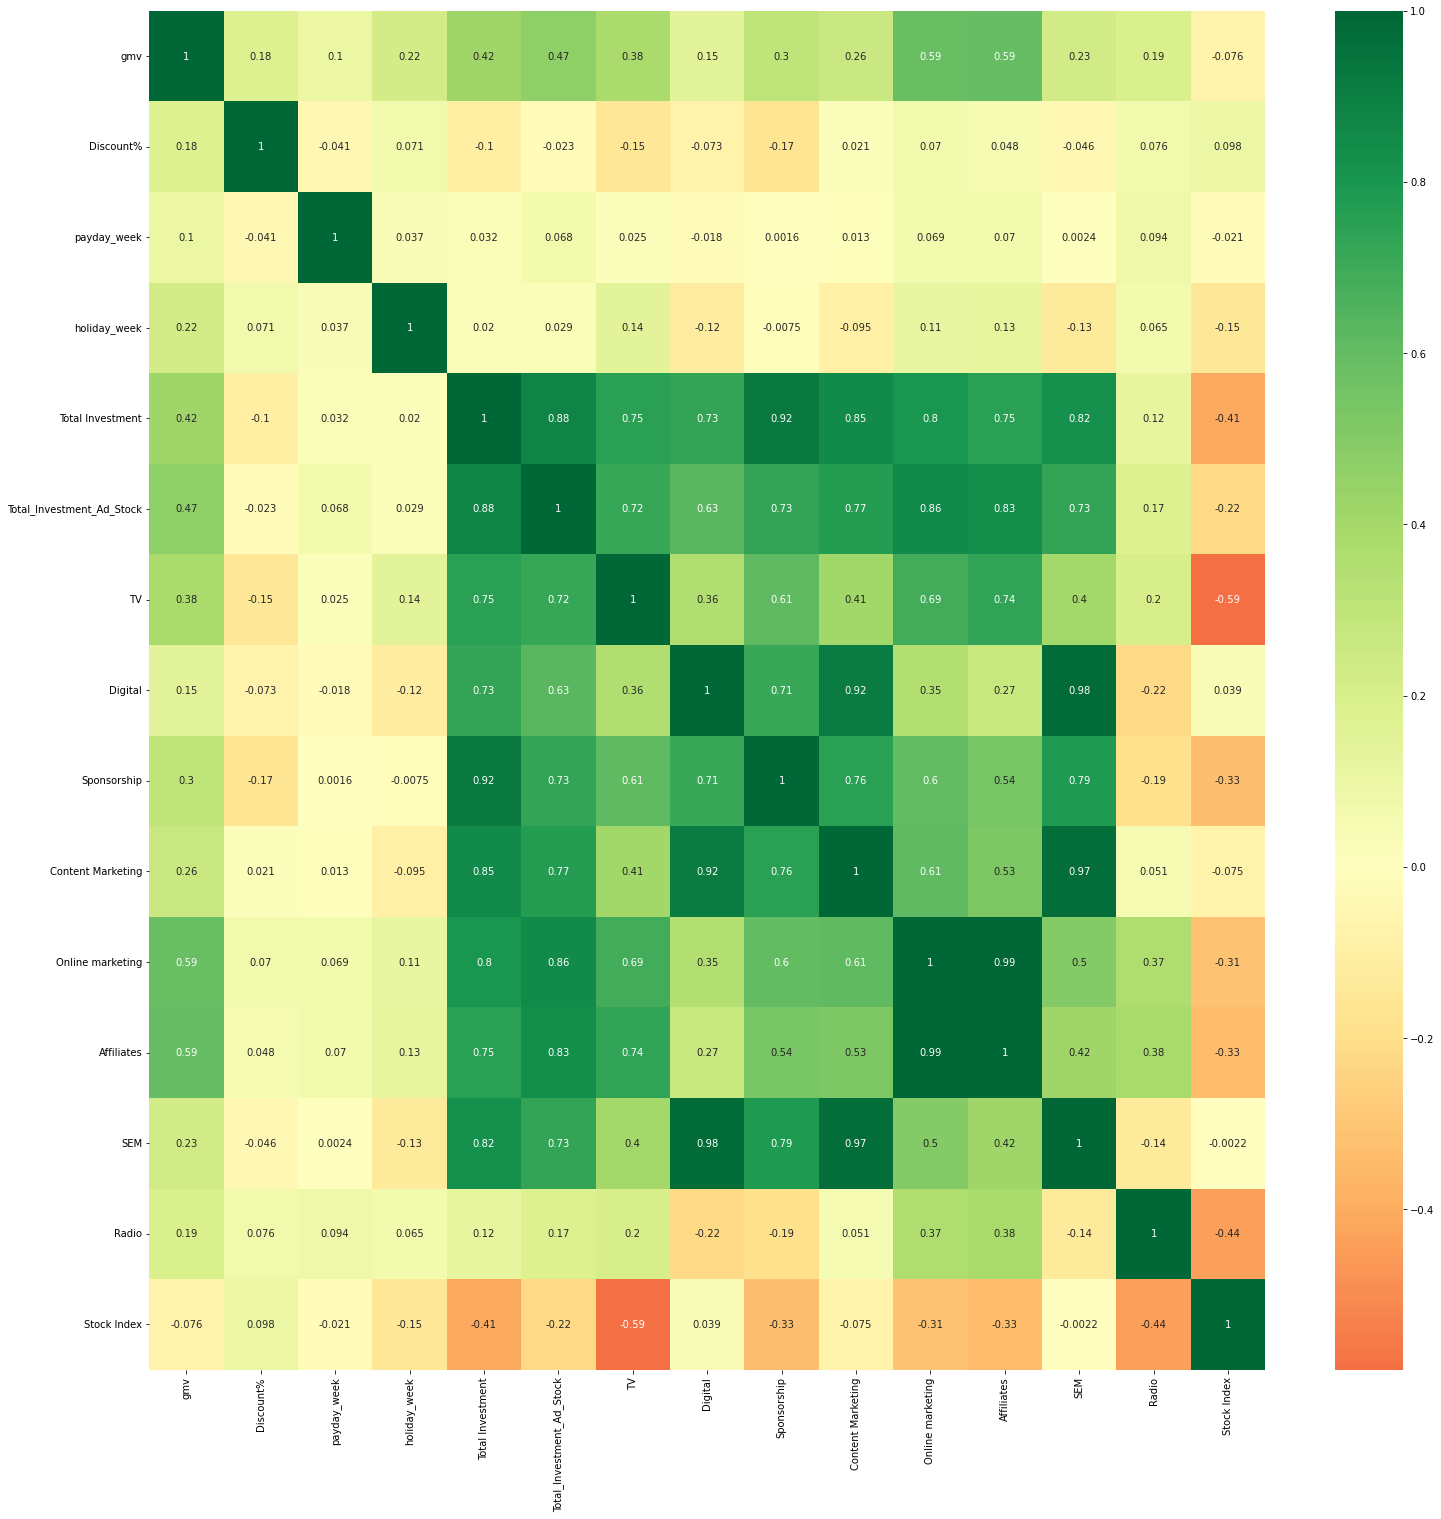

In [294]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df[imp_var].corr(), annot=True,cmap='RdYlGn',center=0) 

In [295]:
import statsmodels.api as sm
import statsmodels.formula.api as smf  # formula api

__Model with only Discount and Affiliates__

In [296]:
# Model wih discount and affiliates
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[['Discount%', 'Affiliates']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.899
Model:                            OLS   Adj. R-squared (uncentered):              0.895
Method:                 Least Squares   F-statistic:                              218.6
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    3.85e-25
Time:                        09:10:09   Log-Likelihood:                         -778.66
No. Observations:                  51   AIC:                                      1561.
Df Residuals:                      49   BIC:                                      1565.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

__Model with All Important Vars__

In [297]:
# Model wih all the important variables
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[imp_var[1:]]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.934
Model:                            OLS   Adj. R-squared (uncentered):              0.909
Method:                 Least Squares   F-statistic:                              37.45
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.49e-17
Time:                        09:10:09   Log-Likelihood:                         -767.83
No. Observations:                  51   AIC:                                      1564.
Df Residuals:                      37   BIC:                                      1591.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

__Inference__

- Coefficients of some of the components are -ve which is counter intuitive. We cannot fiix this model. Need a better model.

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Stepwise Model Selection Approach - Theory</h2>
</div>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Modified Stepwise Model Selection Approach</h2>
</div>

In [298]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.1, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # Step 1. forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded, dtype='float64')
        # Fit a model by including 1 var at a time. 
        # Then, Pick the once with least p-value and is within `threshold_in`
        for new_column in excluded:
#           print(new_column)
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
#           print(new_pval)
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # Step 2. backward step
        # Fit a model with included variables after the forward step. 
        # Then, Drop the one with largest p-value and is outside `threshold_out`
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [299]:
# Stepwise selection with initial list as import markeing variables
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], initial_list = ['Discount%', 'payday_week', 'holiday_week', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Affiliates', 'Radio'],  threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Drop payday_week                    with p-value 0.600806
Drop Total_Investment_Ad_Stock      with p-value 0.458576
Drop holiday_week                   with p-value 0.326255
resulting features:
['Discount%', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Affiliates', 'Radio']


In [300]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.915
Model:                            OLS   Adj. R-squared (uncentered):              0.902
Method:                 Least Squares   F-statistic:                              68.07
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.66e-21
Time:                        09:10:11   Log-Likelihood:                         -774.18
No. Observations:                  51   AIC:                                      1562.
Df Residuals:                      44   BIC:                                      1576.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## Determining Feature Elasicity

In [301]:
model.params

Discount%            1.456372e+03
TV                  -1.465637e+06
Digital              2.736203e+06
Sponsorship          8.845517e+04
Content Marketing   -1.157953e+07
Affiliates           3.028594e+06
Radio                2.684604e+06
dtype: float64

In [302]:
model_parameters = model.params.index.to_list()
model_parameters

['Discount%',
 'TV',
 'Digital',
 'Sponsorship',
 'Content Marketing',
 'Affiliates',
 'Radio']

__Compute Elasticity__

To understand which features are important, bring all to the same scale, by multiplying with mean of X by mean of Y.

In [303]:
def elasticity(model, var, data):
    elast = model.params[var]*np.mean(data[var])/np.mean(data['gmv'])
    return elast                                               

In [304]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Discount% 0.021643990723727313
TV -0.41685178577172594
Digital 0.5314765478506307
Sponsorship 0.21182511355975786
Content Marketing -0.5941526103504406
Affiliates 1.185001289007761
Radio 0.07053306713275914


### Inferences:
- Discount%, Digital, Sponsorship and Affiliaes have an overall positive impact on the gmv.
- Content Marketing has a slight negative impact on the gmv. May be there is some multicollinearity.
- product_vertical_gamepad and product_vertical_gamingheadset have the highest impact on gmv

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Check for Multicollinearity and rebuild</h2>
</div>

We can check for multi collinearity using Variance Inflation factor (VIF). It simply helps us understand if a given X variable is explained by other X variables in the model equation.

VIF = 1 / (1+ R2), where R2 is the R2 of the model with given X as the response and the remaining features are the explanatory variables.

In [305]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [306]:
# Add constant in order to compute VIF
X = add_constant(df.loc[:, model_parameters])
X.head()

const  Discount%     TV  Digital  Sponsorship  Content Marketing  Affiliates  Radio
0    1.0  40.174910  0.054    0.633        1.854                0.0       0.137    0.0
1    1.0  42.688931  0.054    0.633        1.854                0.0       0.137    0.0
2    1.0  37.110373  0.054    0.633        1.854                0.0       0.137    0.0
3    1.0  42.873608  0.054    0.633        1.854                0.0       0.137    0.0
4    1.0  62.937500  0.001    0.256        0.213                0.0       0.015    0.0

In [307]:
# Compute VIF
pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], 
           index=X.columns)

const                163.367166
Discount%              1.240743
TV                     8.435086
Digital               46.329353
Sponsorship            7.061516
Content Marketing     65.653386
Affiliates             9.830152
Radio                  4.396410
dtype: float64

Looks like digital and content marketing are highly correlated. Keep the one that the business wants to control in the model.

In this case, we keep Content marketing, because it has more correlation with gmv for this vertical.

__Rebuild the model__

In [308]:
model_parameters

['Discount%',
 'TV',
 'Digital',
 'Sponsorship',
 'Content Marketing',
 'Affiliates',
 'Radio']

In [309]:
model = sm.OLS(df['gmv'], df[['Discount%', 'TV', 'Sponsorship', 'Content Marketing',
                             'Affiliates', 'Radio']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.902
Model:                            OLS   Adj. R-squared (uncentered):              0.889
Method:                 Least Squares   F-statistic:                              68.74
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    5.16e-21
Time:                        09:10:12   Log-Likelihood:                         -778.04
No. Observations:                  51   AIC:                                      1568.
Df Residuals:                      45   BIC:                                      1580.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [310]:
# Compute VIF
X1 = X[['const', 'Discount%', 'TV', 'Sponsorship', 'Digital', 'Affiliates']]
pd.Series([variance_inflation_factor(X1.values, i) for i in range(X1.shape[1])], 
           index=X1.columns)

const          102.409961
Discount%        1.114164
TV               2.689764
Sponsorship      3.067363
Digital          2.103801
Affiliates       2.468311
dtype: float64

The multicollinearity seems to be fixed. But the p-value (significance) of the variables are impacted. 

So, we will revert to the previous model and leave it as it is for now. 

Key Features are: __'Discount%', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Affiliates', 'Radio'__

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Building Linear Regression model for `homeaudio` and `Camera Accessory` </h2>
</div>

In [311]:
df = homeaudio_org_df.copy()

df = df[df.columns.drop(list(df.filter(regex='product_vertical')))]

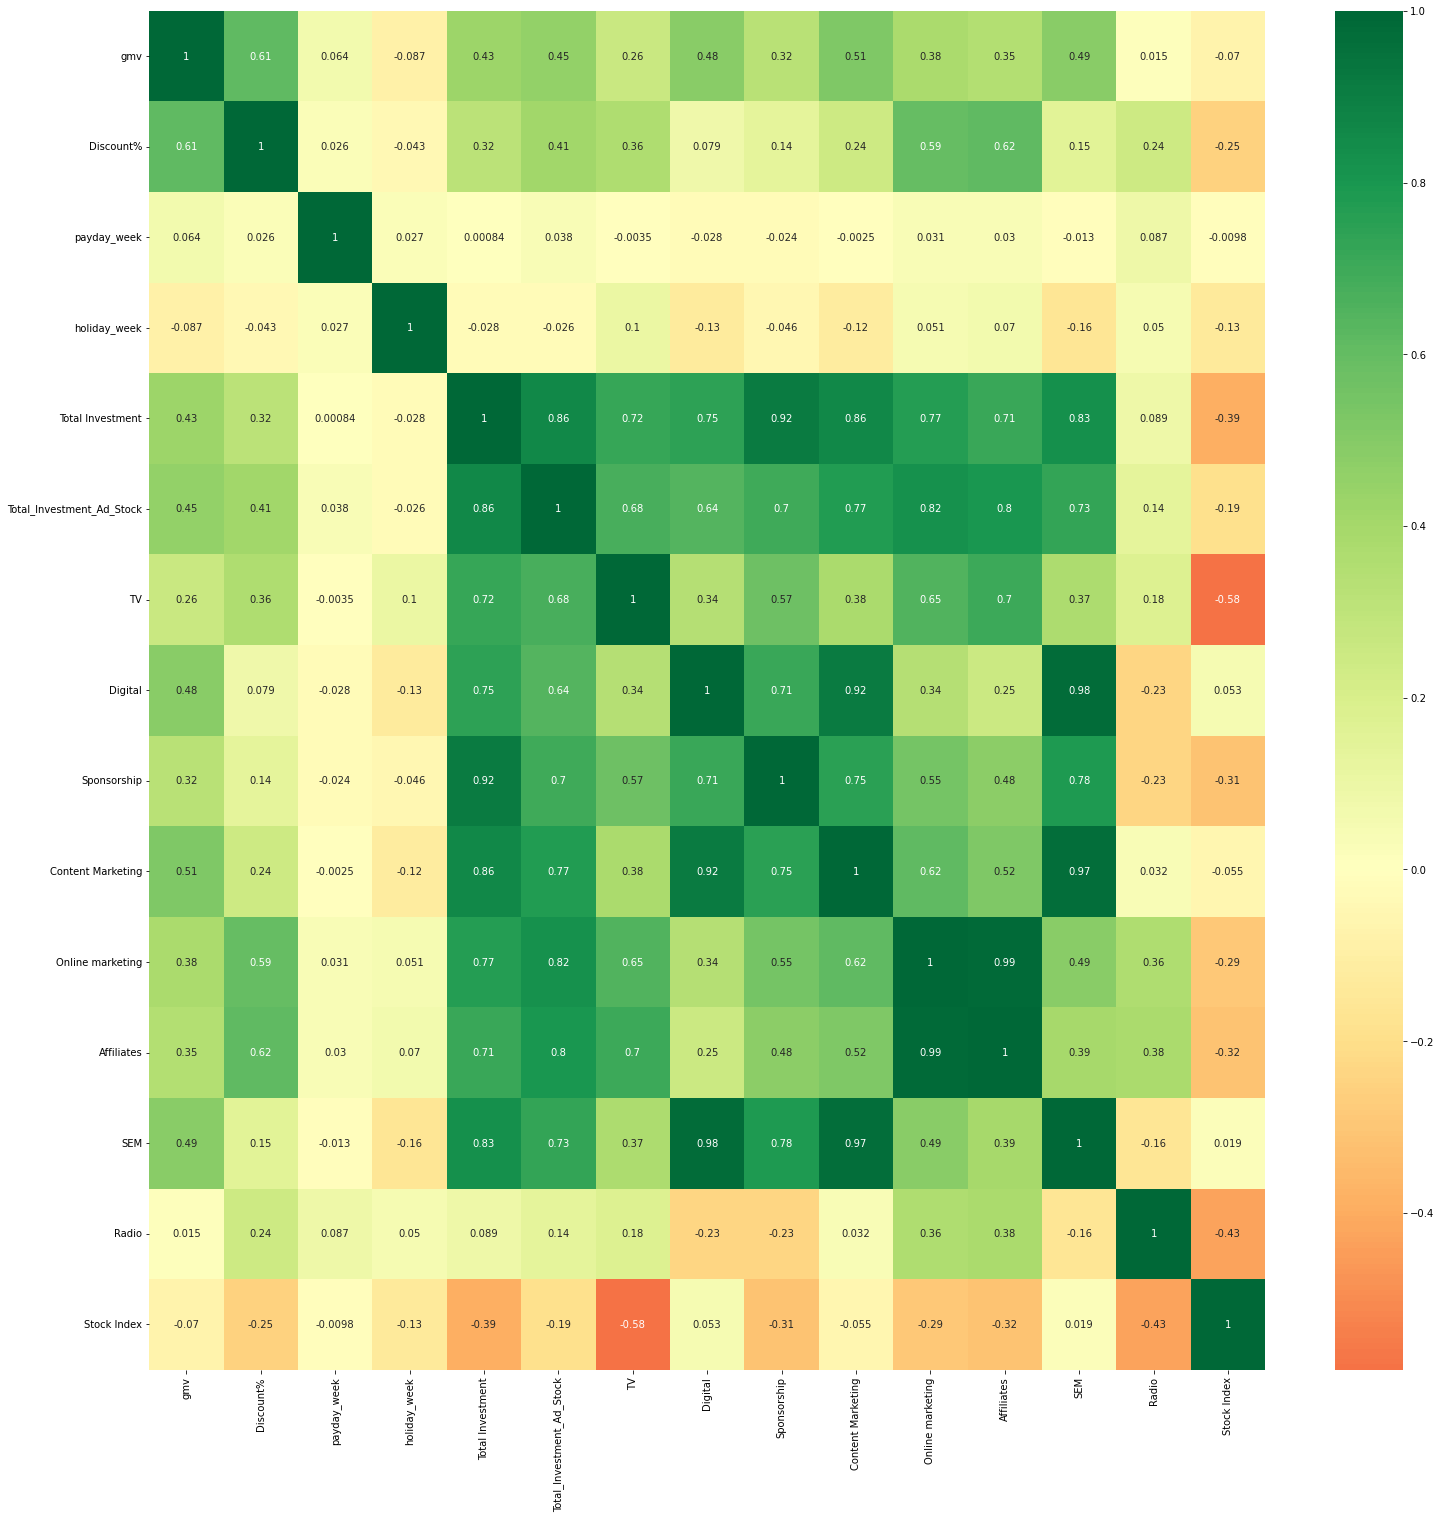

In [312]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df[imp_var].corr(), annot=True,cmap='RdYlGn',center=0) 

In [313]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[['Discount%', 'Affiliates']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.835
Model:                            OLS   Adj. R-squared (uncentered):              0.828
Method:                 Least Squares   F-statistic:                              116.6
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    9.74e-19
Time:                        09:10:14   Log-Likelihood:                         -769.73
No. Observations:                  48   AIC:                                      1543.
Df Residuals:                      46   BIC:                                      1547.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

__Base R2 is around 83%, good.__

In [314]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[imp_var[1:]]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.911
Model:                            OLS   Adj. R-squared (uncentered):              0.874
Method:                 Least Squares   F-statistic:                              24.86
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    8.21e-14
Time:                        09:10:14   Log-Likelihood:                         -754.94
No. Observations:                  48   AIC:                                      1538.
Df Residuals:                      34   BIC:                                      1564.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [315]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'],initial_list= ['Discount%', 'payday_week', 'holiday_week', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Affiliates', 'Radio'],  threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  product_procurement_sla        with p-value 0.000347011
Drop Affiliates                     with p-value 0.966018
Drop payday_week                    with p-value 0.750942
Drop holiday_week                   with p-value 0.64485
Drop Total_Investment_Ad_Stock      with p-value 0.436993
Drop Sponsorship                    with p-value 0.14006
Drop Radio                          with p-value 0.14646
resulting features:
['Discount%', 'TV', 'Digital', 'Content Marketing', 'product_procurement_sla']


In [316]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.928
Model:                            OLS   Adj. R-squared (uncentered):              0.920
Method:                 Least Squares   F-statistic:                              111.1
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.90e-23
Time:                        09:10:18   Log-Likelihood:                         -749.81
No. Observations:                  48   AIC:                                      1510.
Df Residuals:                      43   BIC:                                      1519.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

## Determining Feature Elasicity

In [317]:
model.params

Discount%                  5.141838e+05
TV                        -7.460022e+05
Digital                    2.717471e+06
Content Marketing         -5.186860e+06
product_procurement_sla   -5.133474e+06
dtype: float64

In [318]:
model_parameters = model.params.index.to_list()
model_parameters

['Discount%', 'TV', 'Digital', 'Content Marketing', 'product_procurement_sla']

In [319]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Discount% 3.787294639742296
TV -0.1386550940113146
Digital 0.3359965376981074
Content Marketing -0.1739330058761148
product_procurement_sla -2.8130830342344453


Let's skip the VIF for now. Will worry about it if we decide to go ahead with this model/approach finally.

## Building Linear Regression model for `cameraaccessory`

In [320]:
df = cameraaccessory_org_df.copy()
df = df[df.columns.drop(list(df.filter(regex='product_vertical')))]

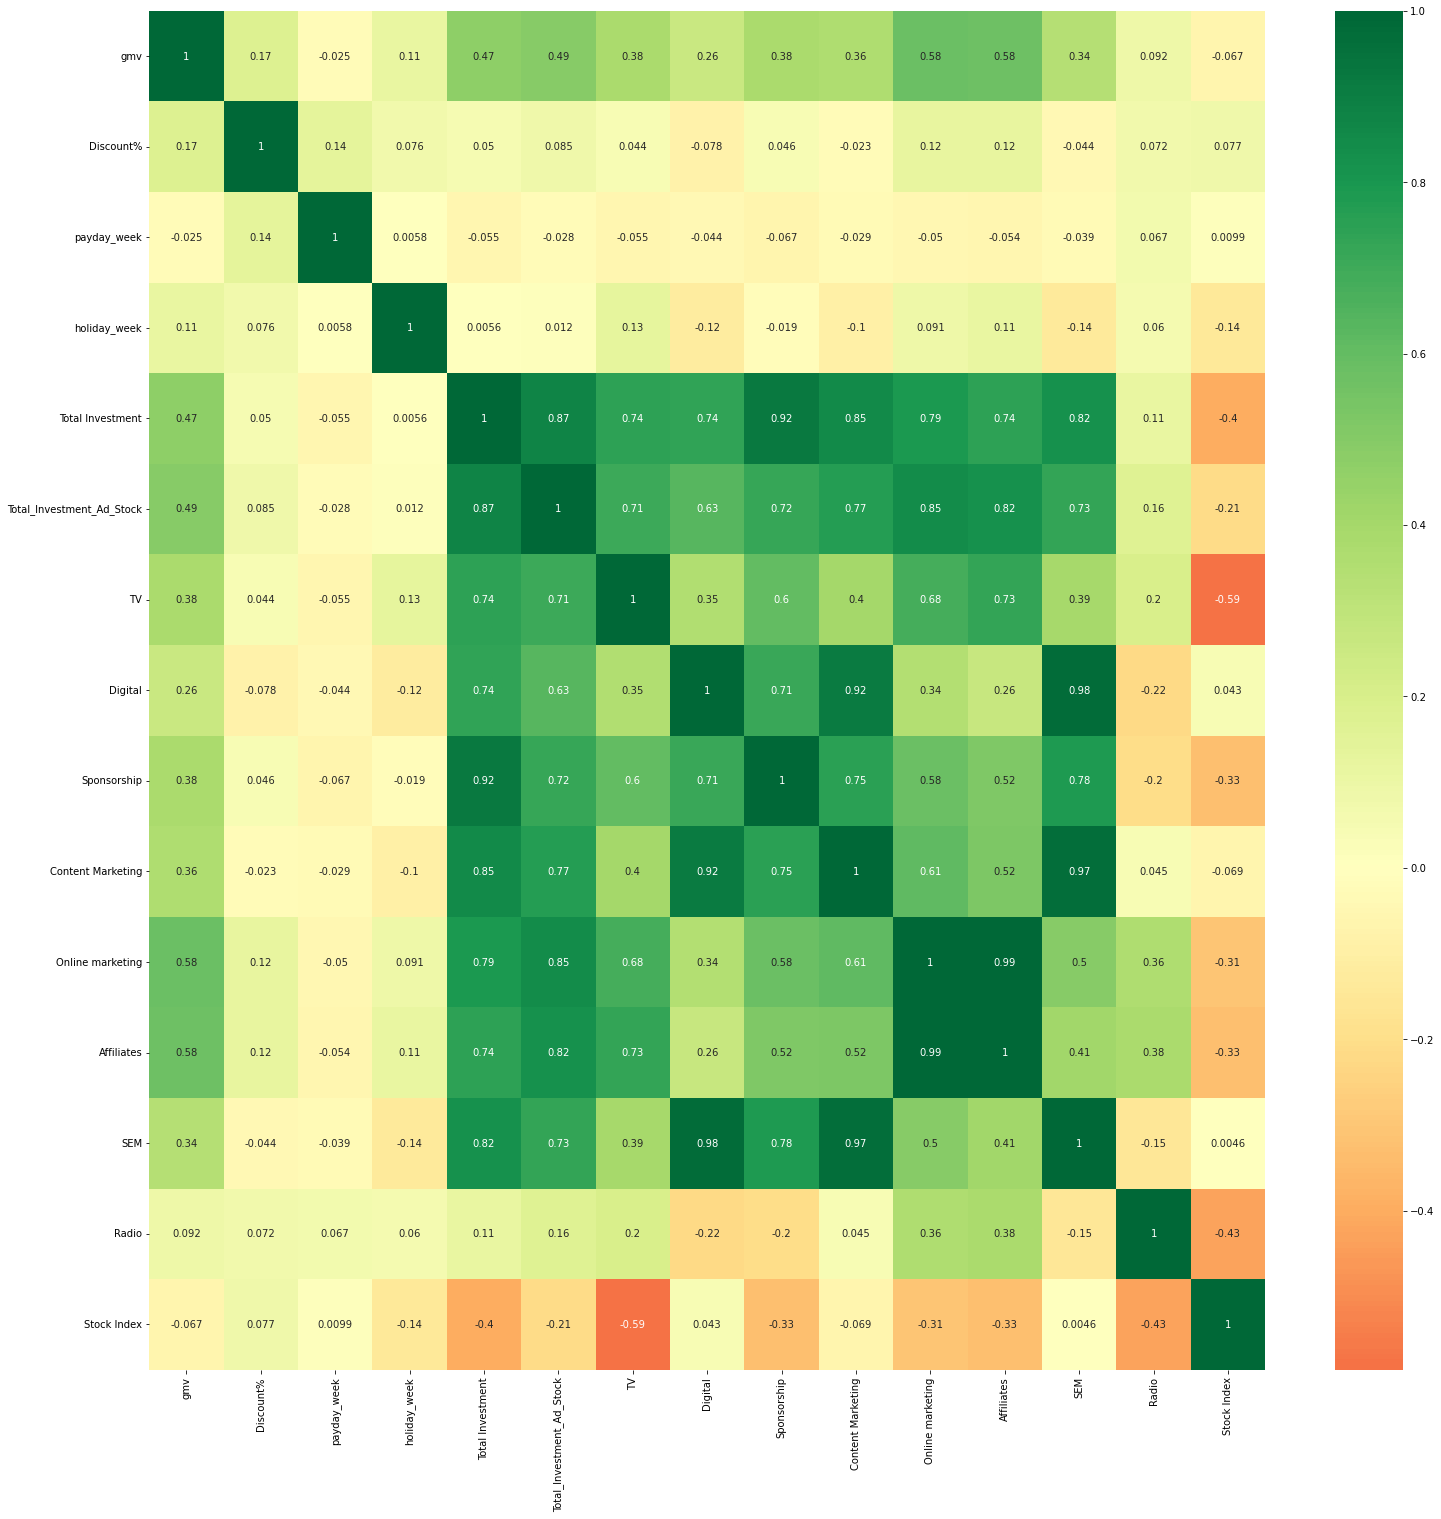

In [321]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df[imp_var].corr(), annot=True,cmap='RdYlGn',center=0) 

In [322]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[['Discount%', 'Affiliates']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.902
Model:                            OLS   Adj. R-squared (uncentered):              0.898
Method:                 Least Squares   F-statistic:                              220.2
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    6.59e-25
Time:                        09:10:19   Log-Likelihood:                         -787.41
No. Observations:                  50   AIC:                                      1579.
Df Residuals:                      48   BIC:                                      1583.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [323]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[imp_var[1:]]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.891
Method:                 Least Squares   F-statistic:                              30.24
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.05e-15
Time:                        09:10:19   Log-Likelihood:                         -781.75
No. Observations:                  50   AIC:                                      1592.
Df Residuals:                      36   BIC:                                      1618.
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [324]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], initial_list = ['Discount%', 'payday_week', 'holiday_week', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Affiliates', 'Radio'], threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  product_procurement_sla        with p-value 0.00161301
Drop Sponsorship                    with p-value 0.566994
Drop payday_week                    with p-value 0.578588
Drop Radio                          with p-value 0.444786
Drop TV                             with p-value 0.355255
Drop Content Marketing              with p-value 0.322843
Drop holiday_week                   with p-value 0.132858
Drop Digital                        with p-value 0.10434
Add  is_mass_market                 with p-value 0.0394338
Drop Total_Investment_Ad_Stock      with p-value 0.627072
resulting features:
['Discount%', 'Affiliates', 'product_procurement_sla', 'is_mass_market']


In [325]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.931
Model:                            OLS   Adj. R-squared (uncentered):              0.925
Method:                 Least Squares   F-statistic:                              156.0
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    3.91e-26
Time:                        09:10:23   Log-Likelihood:                         -778.44
No. Observations:                  50   AIC:                                      1565.
Df Residuals:                      46   BIC:                                      1573.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

## Determining Feature Elasicity

In [326]:
model.params

Discount%                  1.704497e+05
Affiliates                 1.344783e+06
product_procurement_sla    3.468966e+06
is_mass_market            -1.553597e+07
dtype: float64

In [327]:
model_parameters = model.params.index.to_list()
model_parameters

['Discount%', 'Affiliates', 'product_procurement_sla', 'is_mass_market']

In [328]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Discount% 1.6864755753108407
Affiliates 0.32503635421027155
product_procurement_sla 1.883619754582093
is_mass_market -2.895533412179593


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8.2. Multiplicative Model</h2>
</div>

*The Linear Regression Model that we built earlier is an additive model that has been an implicit assumption that the different KPIs affect the revenue additively.*

  __Y = α + β1X1 + β2X2 + β3X3 + β4X4 + β5X5 + ϵ__

*However when there are interactions between the KPIs, we go for a multiplicative model.*

*To fit a multiplicative model, take logarithms of the data(on both sides of the model), then analyse the log data as before.*

__Y = e^α . X1^β1 . X2^β2 . X3^β3 . X4^β4 . X5^β5 + ϵ__

__lnY = α + β1ln(X1) + β2ln(X2) + β3ln(X3) + β4ln(X4) + β5ln(X5) + ϵ'__

Note: Remember to take exp for the Y after prediction step.

In [329]:
homeaudio_org_df.head()

Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  

In [330]:
# Making copy of dataframes from the original ones
cameraaccessory_mul_df = cameraaccessory_org_df.copy()
gamingaccessory_mul_df = gamingaccessory_org_df.copy()
homeaudio_mul_df = homeaudio_org_df.copy()
homeaudio_mul_df.head()

Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  

### Taking Logarithm of both the Dependent and the independent variables

##### After taking log, all 0 values will be transformed to `inf`. Retransforming these values to 0.

In [331]:
cameraaccessory_mul_df = cameraaccessory_mul_df.applymap(lambda x: np.log(x))
cameraaccessory_mul_df = cameraaccessory_mul_df.replace([np.inf, -np.inf], 0)
cameraaccessory_mul_df = cameraaccessory_mul_df.replace(np.nan, 0)

gamingaccessory_mul_df = gamingaccessory_mul_df.applymap(lambda x: np.log(x))
gamingaccessory_mul_df = gamingaccessory_mul_df.replace([np.inf, -np.inf], 0)
gamingaccessory_mul_df = gamingaccessory_mul_df.replace(np.nan, 0)

homeaudio_mul_df = homeaudio_mul_df.applymap(lambda x: np.log(x))
homeaudio_mul_df = homeaudio_mul_df.replace([np.inf, -np.inf], 0)
homeaudio_mul_df = homeaudio_mul_df.replace(np.nan, 0)


homeaudio_mul_df.head()

Week        gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock        TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock   Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock       SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock  \
0  3.332205  15.335851   3.448425            0.0            0.0  1.997309                 1.051948 -0.278321       -0.425756          0.0           0.0          1.450442                0.000000                0.000000                1.450442                   1.450442 -2.918771  0.000000  0.000000 -2.918771    -2.918771 -0.457285       0.000000       0.000000      -0.457285         -0.457285     0.617345           0.000000           0.000000           0.617345              0.617345                0.0                      0.0                      0.0                      0.0                         0.0         -1.102620                0.000000                0.000000               -1.102620                  -1.102620   -1.987774          0.000000          0.000000         -1.987774            -1.987774  0.227932   0.000000   0.000000   0.227932      0.227932    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
1  3.367296  15.496622   3.495497            0.0            0.0  1.943745                 1.010261 -0.268768       -0.417402          0.0           0.0          1.450442                0.000000                0.000000                1.450442                   1.920446 -2.918771  0.000000  0.000000 -2.918771    -2.448768 -0.457285       0.000000       0.000000      -0.457285          0.012719     0.617345           0.000000           0.000000           0.617345              1.087349                0.0                      0.0                      0.0                      0.0                         0.0         -1.102620                0.000000                0.000000               -1.102620                  -0.632617   -1.987774          0.000000          0.000000         -1.987774            -1.517771  0.227932   0.000000   0.000000   0.227932      0.697936    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
2  3.401197  15.358772   3.476841            0.0            0.0  1.956108                 1.051010 -0.237825       -0.351563          0.0           0.0          1.450442                1.450442                0.000000                1.450442                   2.123387 -2.918771 -2.918771  0.000000 -2.918771    -2.245827 -0.457285      -0.457285       0.000000      -0.457285          0.215660     0.617345           0.617345           0.000000           0.617345              1.290290                0.0                      0.0                      0.0                      0.0                         0.0         -1.102620               -1.102620                0.000000               -1.102620                  -0.429676   -1.987774         -1.987774          0.000000         -1.987774            -1.314830  0.227932   0.227932   0.000000   0.227932      0.900877    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
3  3.433987  15.054

## Building Linear Regression model for `gamingaccessory`

In [332]:
df = gamingaccessory_mul_df.copy()
df = df[df.columns.drop(list(df.filter(regex='product_vertical')))]

In [333]:
imp_var = ['gmv', 'Discount%', 'Total Investment', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Stock Index']

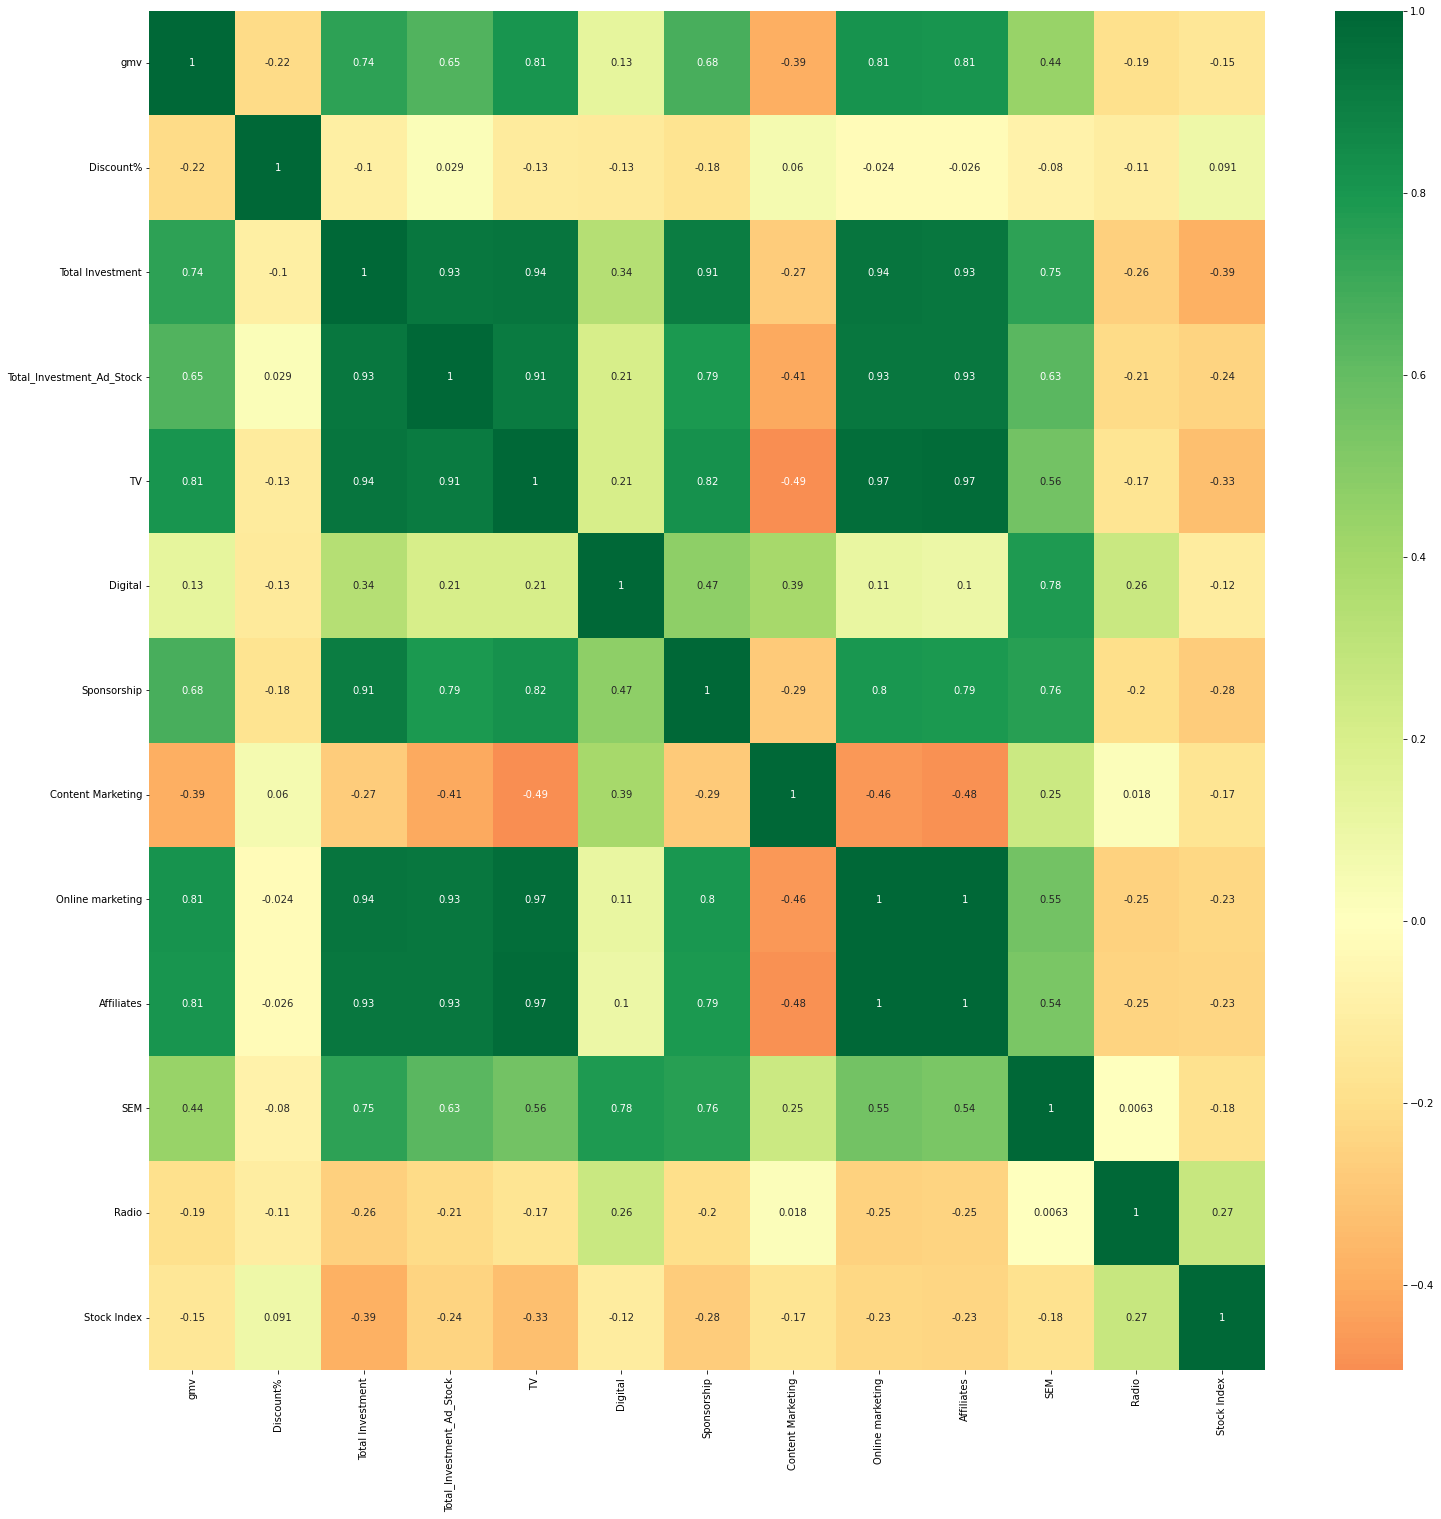

In [334]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df[imp_var].corr(), annot=True,cmap='RdYlGn',center=0) 

In [335]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[['Discount%', 'Affiliates']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              2744.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    5.03e-51
Time:                        09:10:25   Log-Likelihood:                         -88.240
No. Observations:                  51   AIC:                                      180.5
Df Residuals:                      49   BIC:                                      184.3
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [336]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[imp_var[1:]]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.996
Model:                            OLS   Adj. R-squared (uncentered):              0.995
Method:                 Least Squares   F-statistic:                              832.4
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    4.69e-43
Time:                        09:10:25   Log-Likelihood:                         -67.270
No. Observations:                  51   AIC:                                      158.5
Df Residuals:                      39   BIC:                                      181.7
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [337]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], initial_list = ['Discount%', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Affiliates', 'Radio'], threshold_in=0.01, threshold_out = 0.05)

print('resulting features:')
print(result)

Add  is_mass_market                 with p-value 3.39039e-06
Drop Radio                          with p-value 0.708735
Drop Discount%                      with p-value 0.397539
Drop Content Marketing              with p-value 0.141208
Drop TV                             with p-value 0.0888341
Add  Other_SMA_3                    with p-value 0.00641594
Drop Total_Investment_Ad_Stock      with p-value 0.0714758
Add  Sponsorship_SMA_5              with p-value 0.00643782
Add  SEM_SMA_5                      with p-value 0.00618945
Drop Digital                        with p-value 0.632977
Drop Sponsorship                    with p-value 0.78704
resulting features:
['Affiliates', 'is_mass_market', 'Other_SMA_3', 'Sponsorship_SMA_5', 'SEM_SMA_5']


In [338]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.948
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                              169.4
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.98e-28
Time:                        09:10:28   Log-Likelihood:                         -133.16
No. Observations:                  51   AIC:                                      276.3
Df Residuals:                      46   BIC:                                      286.0
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

## Determining Feature Elasicity

In [339]:
model.params

Affiliates            -1.647087
is_mass_market      -125.129868
Other_SMA_3            0.807355
Sponsorship_SMA_5      2.298079
SEM_SMA_5              1.446543
dtype: float64

In [340]:
model_parameters = model.params.index.to_list()
model_parameters

['Affiliates',
 'is_mass_market',
 'Other_SMA_3',
 'Sponsorship_SMA_5',
 'SEM_SMA_5']

In [341]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Affiliates 0.03578347151332229
is_mass_market 0.6233811037603161
Other_SMA_3 0.00971129909397296
Sponsorship_SMA_5 0.2441973972538523
SEM_SMA_5 0.03537417551848812


## Building Linear Regression model for `homeaudio`

In [342]:
homeaudio_mul_df.head()

Week        gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock        TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock   Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock       SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock  \
0  3.332205  15.335851   3.448425            0.0            0.0  1.997309                 1.051948 -0.278321       -0.425756          0.0           0.0          1.450442                0.000000                0.000000                1.450442                   1.450442 -2.918771  0.000000  0.000000 -2.918771    -2.918771 -0.457285       0.000000       0.000000      -0.457285         -0.457285     0.617345           0.000000           0.000000           0.617345              0.617345                0.0                      0.0                      0.0                      0.0                         0.0         -1.102620                0.000000                0.000000               -1.102620                  -1.102620   -1.987774          0.000000          0.000000         -1.987774            -1.987774  0.227932   0.000000   0.000000   0.227932      0.227932    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
1  3.367296  15.496622   3.495497            0.0            0.0  1.943745                 1.010261 -0.268768       -0.417402          0.0           0.0          1.450442                0.000000                0.000000                1.450442                   1.920446 -2.918771  0.000000  0.000000 -2.918771    -2.448768 -0.457285       0.000000       0.000000      -0.457285          0.012719     0.617345           0.000000           0.000000           0.617345              1.087349                0.0                      0.0                      0.0                      0.0                         0.0         -1.102620                0.000000                0.000000               -1.102620                  -0.632617   -1.987774          0.000000          0.000000         -1.987774            -1.517771  0.227932   0.000000   0.000000   0.227932      0.697936    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
2  3.401197  15.358772   3.476841            0.0            0.0  1.956108                 1.051010 -0.237825       -0.351563          0.0           0.0          1.450442                1.450442                0.000000                1.450442                   2.123387 -2.918771 -2.918771  0.000000 -2.918771    -2.245827 -0.457285      -0.457285       0.000000      -0.457285          0.215660     0.617345           0.617345           0.000000           0.617345              1.290290                0.0                      0.0                      0.0                      0.0                         0.0         -1.102620               -1.102620                0.000000               -1.102620                  -0.429676   -1.987774         -1.987774          0.000000         -1.987774            -1.314830  0.227932   0.227932   0.000000   0.227932      0.900877    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
3  3.433987  15.054

In [343]:
df = homeaudio_mul_df.copy()
df = df[df.columns.drop(list(df.filter(regex='product_vertical')))]
# df = df.drop(['payday_week', 'holiday_week'], axis = 1)

In [344]:
model = sm.OLS(df['gmv'], df[['Discount%', 'Affiliates']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.403e+04
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    8.33e-65
Time:                        09:10:28   Log-Likelihood:                         -44.841
No. Observations:                  48   AIC:                                      93.68
Df Residuals:                      46   BIC:                                      97.42
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [345]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[imp_var[1:]]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              4574.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.68e-53
Time:                        09:10:28   Log-Likelihood:                         -22.882
No. Observations:                  48   AIC:                                      69.76
Df Residuals:                      36   BIC:                                      92.22
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [346]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], initial_list = ['Discount%', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Affiliates', 'Radio'], threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  TV_Ad_Stock                    with p-value 4.75771e-07
Drop Sponsorship                    with p-value 0.349597
Add  sla                            with p-value 0.00214599
Add  Radio_EMA_8                    with p-value 0.00392394
resulting features:
['Discount%', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Content Marketing', 'Affiliates', 'Radio', 'TV_Ad_Stock', 'sla', 'Radio_EMA_8']


In [347]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              6786.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.43e-58
Time:                        09:10:30   Log-Likelihood:                         -19.086
No. Observations:                  48   AIC:                                      58.17
Df Residuals:                      38   BIC:                                      76.88
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

## Determining Feature Elasicity

In [348]:
model.params

Discount%                    4.258409
Total_Investment_Ad_Stock    0.157074
TV                           0.430380
Digital                      0.256712
Content Marketing           -0.131757
Affiliates                   0.782182
Radio                       -0.114271
TV_Ad_Stock                 -1.203277
sla                          0.064843
Radio_EMA_8                 -0.040312
dtype: float64

In [349]:
model_parameters = model.params.index.to_list()
model_parameters

['Discount%',
 'Total_Investment_Ad_Stock',
 'TV',
 'Digital',
 'Content Marketing',
 'Affiliates',
 'Radio',
 'TV_Ad_Stock',
 'sla',
 'Radio_EMA_8']

In [350]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Discount% 1.0001823659885056
Total_Investment_Ad_Stock 0.036635358756314414
TV -0.018974607658929808
Digital -0.01608675401960938
Content Marketing 0.01826629039308521
Affiliates -0.0035677736003223827
Radio 0.0023276068065970997
TV_Ad_Stock -0.028633227091933527
sla 0.007419883721861747
Radio_EMA_8 0.0026490313139193723


## Building Linear Regression model for `cameraaccessory`

In [351]:
df = cameraaccessory_mul_df.copy()
df = df[df.columns.drop(list(df.filter(regex='product_vertical')))]
# df = df.drop(['payday_week', 'holiday_week'], axis = 1)

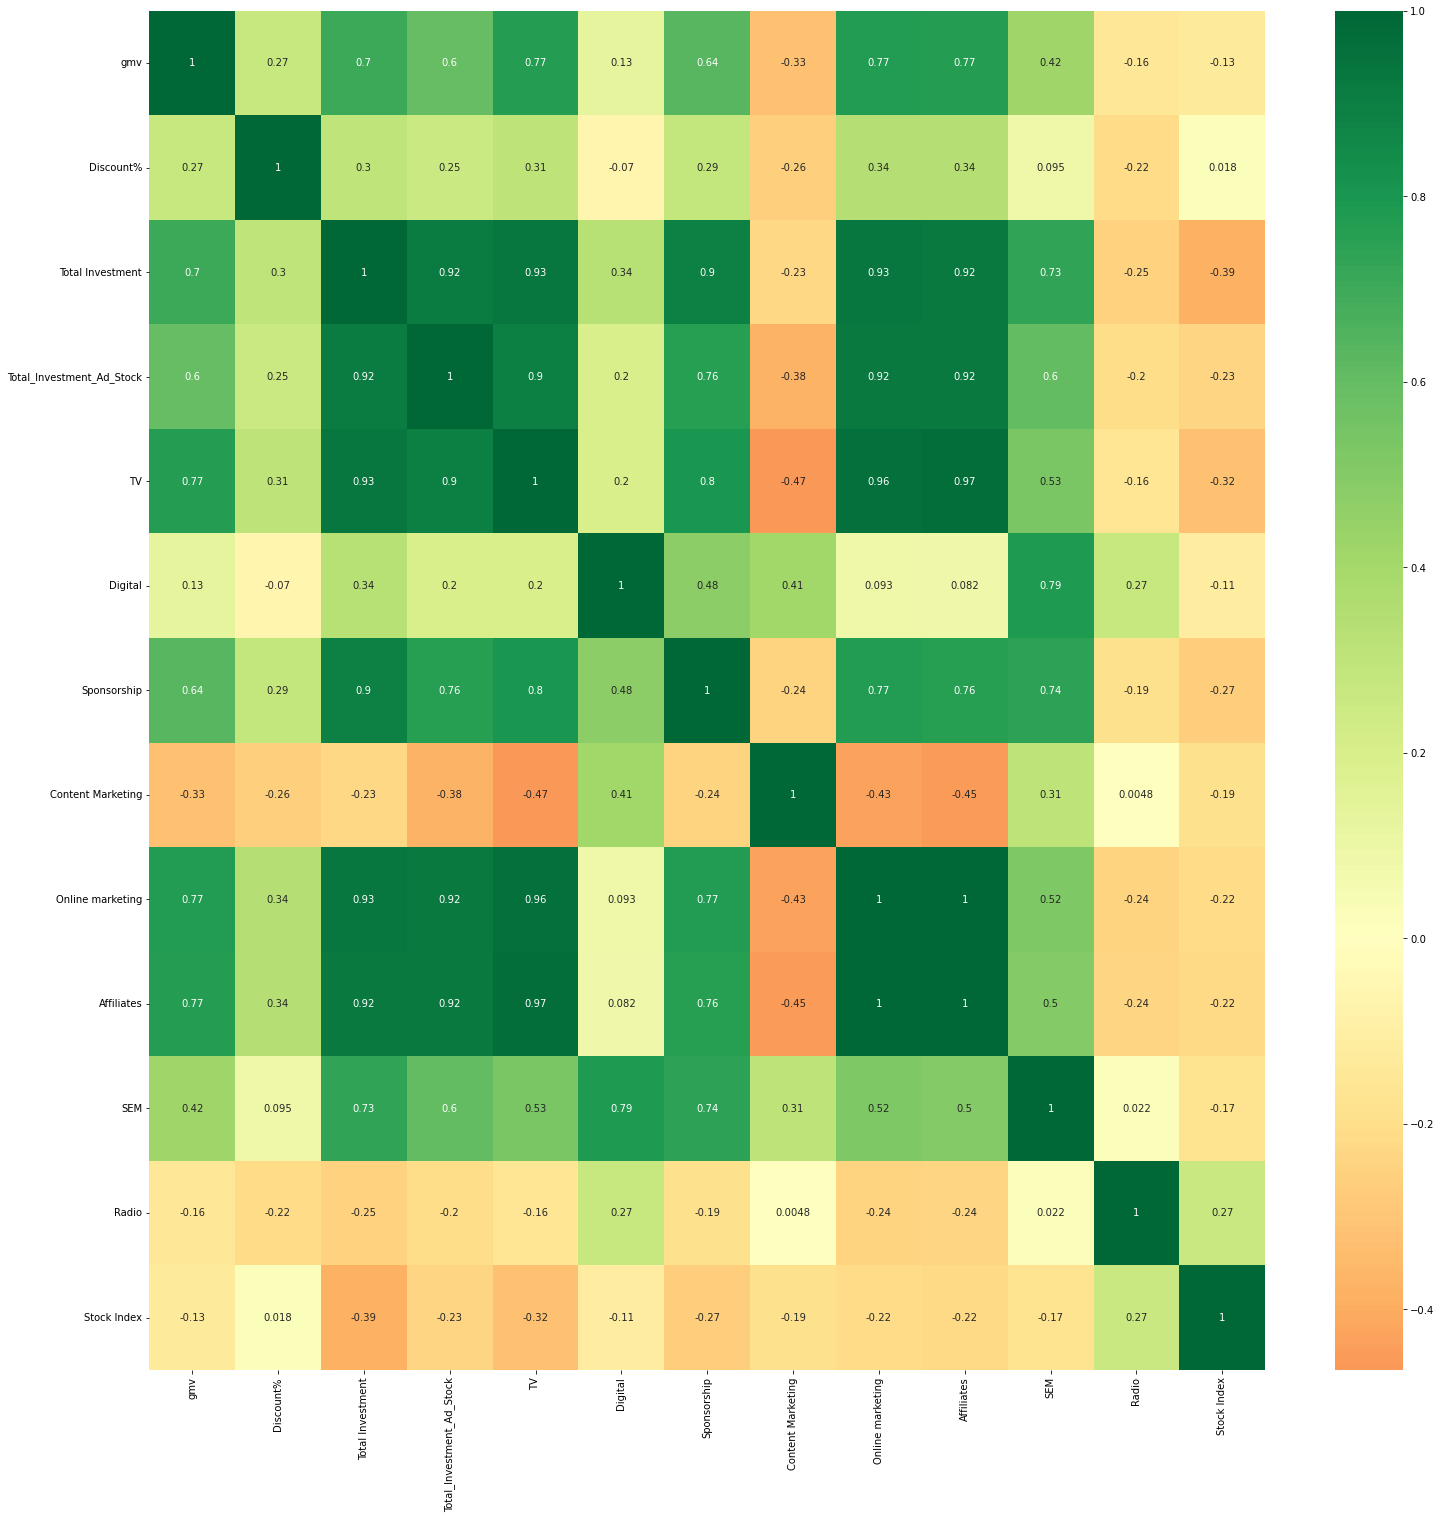

In [352]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df[imp_var].corr(), annot=True,cmap='RdYlGn',center=0) 

In [353]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[['Discount%', 'Affiliates']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.989
Method:                 Least Squares   F-statistic:                              2272.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    2.89e-48
Time:                        09:10:31   Log-Likelihood:                         -92.518
No. Observations:                  50   AIC:                                      189.0
Df Residuals:                      48   BIC:                                      192.9
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [354]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[imp_var[1:]]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              682.9
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.73e-40
Time:                        09:10:31   Log-Likelihood:                         -72.083
No. Observations:                  50   AIC:                                      168.2
Df Residuals:                      38   BIC:                                      191.1
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

In [355]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], initial_list = ['Discount%', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Affiliates', 'Radio'], threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  product_procurement_sla        with p-value 5.34499e-14
Drop TV                             with p-value 0.864833
Add  is_mass_market                 with p-value 0.00930373
Add  Digital_EMA_8                  with p-value 0.0197464
Drop Total_Investment_Ad_Stock      with p-value 0.116314
Add  NPS                            with p-value 0.0304214
Drop Content Marketing              with p-value 0.380042
resulting features:
['Discount%', 'Digital', 'Sponsorship', 'Affiliates', 'Radio', 'product_procurement_sla', 'is_mass_market', 'Digital_EMA_8', 'NPS']


In [356]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                              2884.
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.72e-54
Time:                        09:10:34   Log-Likelihood:                         -45.236
No. Observations:                  50   AIC:                                      108.5
Df Residuals:                      41   BIC:                                      125.7
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

## Determining Feature Elasicity

In [357]:
model.params

Discount%                   5.435450
Digital                     0.565155
Sponsorship                -0.556524
Affiliates                  0.568359
Radio                      -0.335678
product_procurement_sla     8.683195
is_mass_market            -19.088065
Digital_EMA_8              -0.974694
NPS                        -3.967029
dtype: float64

In [358]:
model_parameters = model.params.index.to_list()
model_parameters

['Discount%',
 'Digital',
 'Sponsorship',
 'Affiliates',
 'Radio',
 'product_procurement_sla',
 'is_mass_market',
 'Digital_EMA_8',
 'NPS']

In [359]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Discount% 1.4092331477446975
Digital -0.03667189212095607
Sponsorship -0.054392159827537166
Affiliates -0.008934974428069311
Radio 0.006681353414179545
product_procurement_sla 0.5652804744719361
is_mass_market 0.11039789817838429
Digital_EMA_8 0.04579369112901993
NPS -1.0372099367034395


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8.3. Koyck Model of Distributed Lags</h2>
</div>

Koyck (1954) introduced an ingeniuous method of using distributed lags to model the Y.

__Yt__ = __α__ + __µ1Yt-1__ + __µ2Yt-2__ + __µ3Yt-3__

What it postulates is that each successive coefficient is numerically less than each preceding coeff, implying that as one goes back into the distant past, the effect of that lag on Yt becomes progressively smaller, which is a quite plausible assumption. 

After all, the most recent values are expected to affect current value more heavily than those from the distant past. 


___________________________

__The Carry Over Effect__

*The Additive and Multiplicative Linear Models that we have built till now can capture the current effect of the KPIs. However, if we want to capture the carry-over effect, we would want to model the current revenue figures based on the past figures of the KPIs.*

*The Koyck tells us that the current revenue generated is not just influenced by the different independent attributes, but also because of the revenue generated over the last periods. ie. Current revenue(Yt) is also dependent on the past revenue values(Yt-1).*

The coefficients (Betas) of the subsequent lags decay geometrically, such that Bk = B0.(lambda^k). that is the successive lags have a lower impact on the predictor. The value of lambda typically lies between 0 and 1. 


__1.__

  __Yt__ = __α__ +             __β1X1__ + __β2X2__ + __β3X3__ + __β4X4__ + __β5X5__ + __ϵ__


__2.__

  __Yt__ = __α__ + __µYt-1__ + __β1X1__ + __β2X2__ + __β3X3__ + __β4X4__ + __β5X5__ + __ϵ__  -- (sale at time t is dependent on sale at time t-1)


__3.__

  __Yt__ = __α__ + __µ1Yt-1__ + __µ2Yt-2__ + __µ3Yt-3__ . . . + __β1X1__ + __β2X2__ + __β3X3__ + __β4X4__ + __β5X5__ + __ϵ__  -- (sale at time t is dependent on sale at time t-1)


Referring to eqn 2:

*If `X1` is the advertising effect, β1 is the current effect of advertising, carry over effect of advertising is:

__β1 * µ/(1-µ)*__

__*Therefore the total effect of advertising  = Current effect + Carry over effect*__

                                            = β1 + β1 * µ/(1-µ)	

											= β1/(1-µ)

In [360]:
homeaudio_org_df.head()

Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  

In [361]:
# Making copy of dataframes from the original ones
cameraaccessory_koy_df = cameraaccessory_org_df.copy()
gamingaccessory_koy_df = gamingaccessory_org_df.copy()
homeaudio_koy_df = homeaudio_org_df.copy()
homeaudio_koy_df.head()

Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  

### Creating a new variable which is the Lag of 1 week of the dependent variable (GMV)

In [362]:
GMV_Lag = ['gmv']

In [363]:
def lag_variables(df,var,n):
    for i in var:
        loc_index = df.columns.get_loc(i) + 1
        df.insert(loc=loc_index,column= i+'_lag'+np.str(n),value=df[i].shift(n))
    return df

In [364]:
cameraaccessory_koy_df = lag_variables(cameraaccessory_koy_df,GMV_Lag,1) 
gamingaccessory_koy_df = lag_variables(gamingaccessory_koy_df,GMV_Lag,1) 
homeaudio_koy_df = lag_variables(homeaudio_koy_df,GMV_Lag,1) 
homeaudio_koy_df.head()

Week           gmv      gmv_lag1  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  \
0    28  4.573783e+06           NaN  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0   
1    29  5.371525e+06  4.573783e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0   
2    30  4.679828e+06  5.371525e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0   
3    31  3.451151e+06  4.679828e+06  32.207530         

__Impute missing values__

In [365]:
# Imputing all null values with 0
cameraaccessory_koy_df.fillna(value=0, inplace=True)
gamingaccessory_koy_df.fillna(value=0, inplace=True)
homeaudio_koy_df.fillna(value=0, inplace=True)
homeaudio_koy_df.head(10)

Week           gmv      gmv_lag1  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  \
0    28  4.573783e+06  0.000000e+00  31.450813       0.000000       0.000000  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                0.000000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854           0.000000             0.0000           1.854000              1.854000              0.000                    0.000                   0.0000                 0.000000                    0.000000             0.332                0.000000                  0.0000                0.332000                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256   0.000000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0   
1    29  5.371525e+06  4.573783e+06  32.966657       0.000000       0.000000  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                0.000000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854           0.000000             0.0000           1.854000              2.966400              0.000                    0.000                   0.0000                 0.000000                    0.000000             0.332                0.000000                  0.0000                0.332000                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256   0.000000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0   
2    30  4.679828e+06  5.371525e+06  32.357350       0.000000       0.000000  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                4.265000                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854           1.854000             0.0000           1.854000              3.633840              0.000                    0.000                   0.0000                 0.000000                    0.000000             0.332                0.332000                  0.0000                0.332000                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256   1.256000     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0   
3    31  3.451151e+06  4.679828e+06  32.207530       0.

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Approach 2: Koyck Model for `homeaudio`</h2>
</div>

In [574]:
df = homeaudio_koy_df.copy()

In [575]:
imp_var = ['gmv', 'gmv_lag1', 'Discount%', 'payday_week', 'holiday_week', 
           'Total Investment', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 
           'Sponsorship', 'Content Marketing', 'Online marketing', 
           'Affiliates', 'SEM', 'Radio', 'Stock Index']
imp_var

['gmv',
 'gmv_lag1',
 'Discount%',
 'payday_week',
 'holiday_week',
 'Total Investment',
 'Total_Investment_Ad_Stock',
 'TV',
 'Digital',
 'Sponsorship',
 'Content Marketing',
 'Online marketing',
 'Affiliates',
 'SEM',
 'Radio',
 'Stock Index']

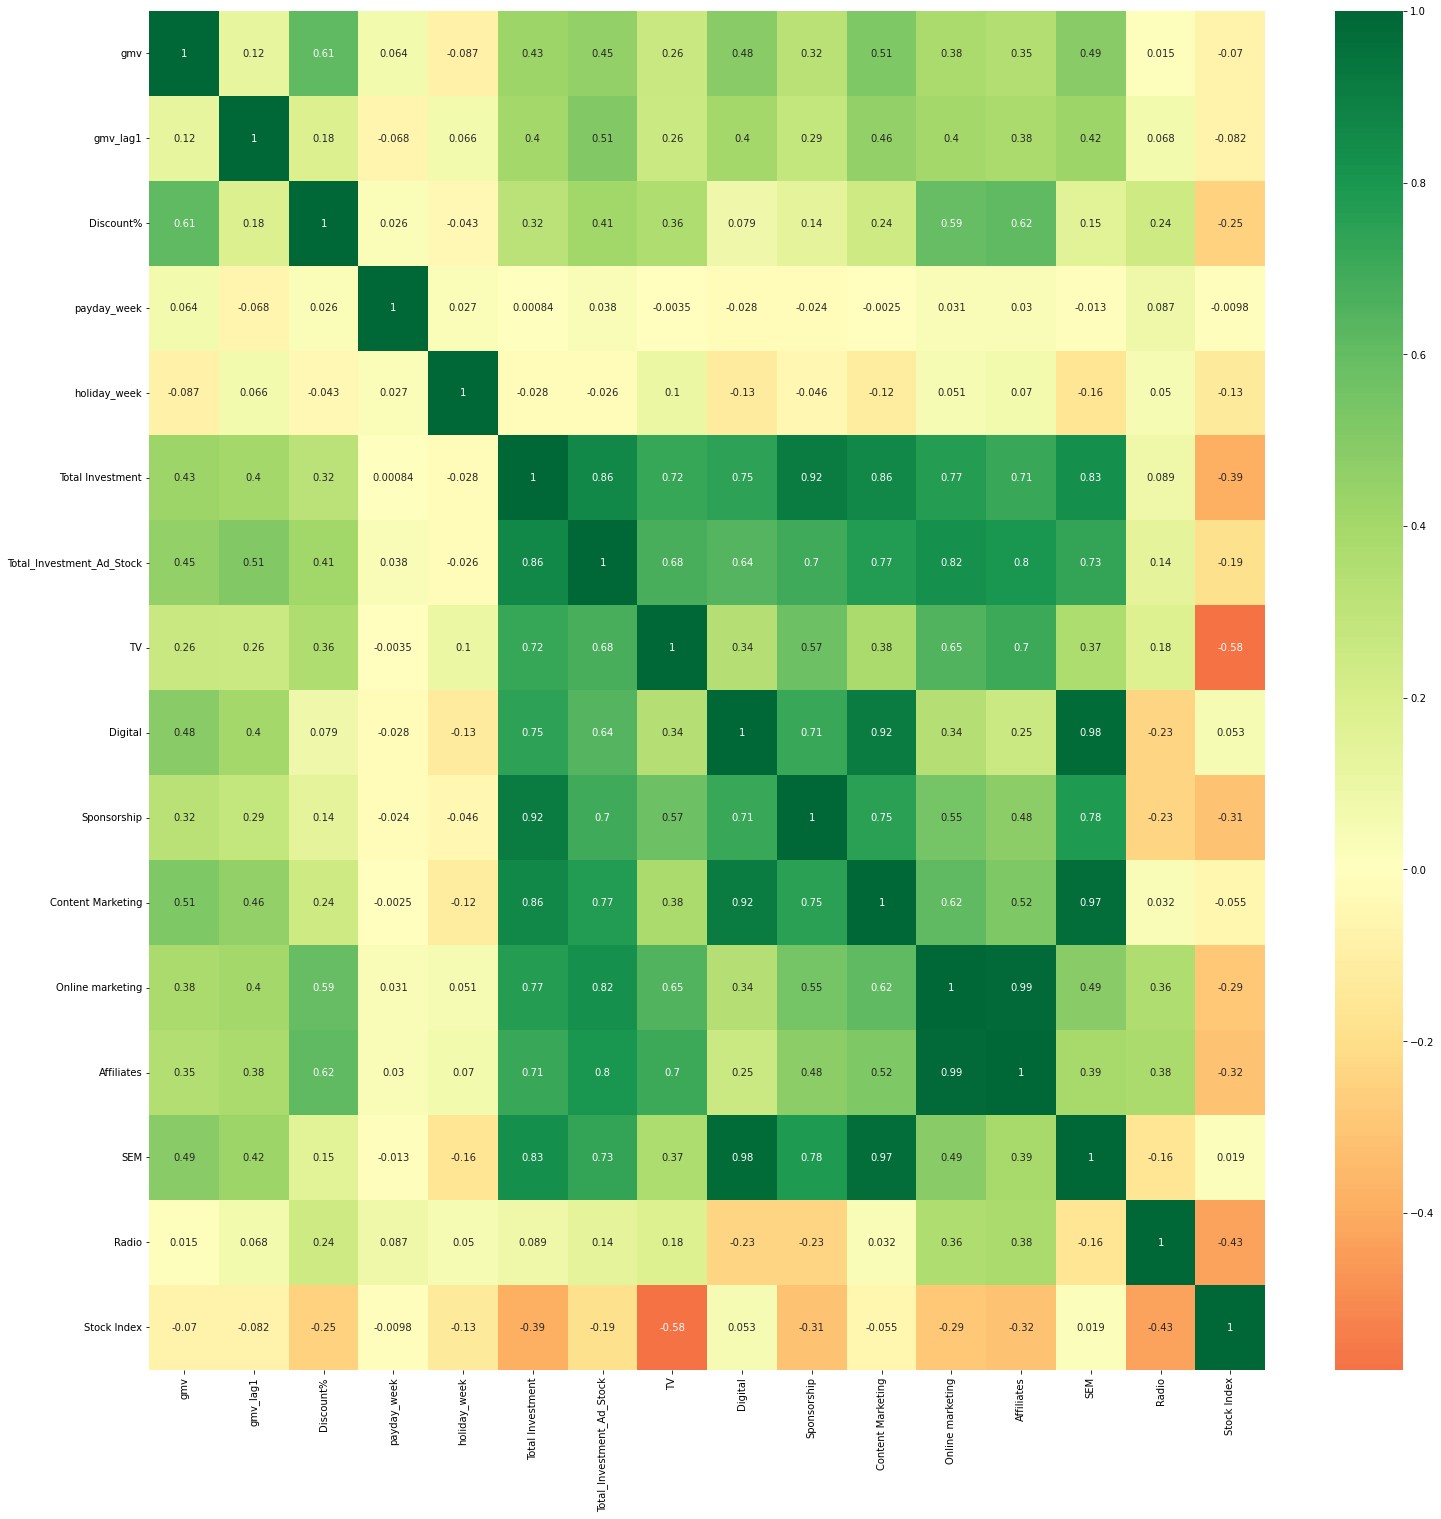

In [368]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df[imp_var].corr(), annot=True,cmap='RdYlGn',center=0) 

__Note:__ Observe which vars are more correlated with GMV. Clearly, some of the variables are more correlated than lag1 of GMV. Interesting.

In [576]:
model = sm.OLS(df['gmv'], df[['gmv_lag1']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.645
Model:                            OLS   Adj. R-squared (uncentered):              0.638
Method:                 Least Squares   F-statistic:                              85.46
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    3.80e-12
Time:                        09:38:06   Log-Likelihood:                         -788.14
No. Observations:                  48   AIC:                                      1578.
Df Residuals:                      47   BIC:                                      1580.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Lag1 forms a significant model with +ve coeff and a R2 not so bad.

In [370]:
model = sm.OLS(df['gmv'], df[imp_var]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          7.741e+28
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                        0.00
Time:                        09:10:37   Log-Likelihood:                          766.81
No. Observations:                  48   AIC:                                     -1502.
Df Residuals:                      32   BIC:                                     -1472.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

_Clear case of overfitting, with insignificant p-values and extremely high R2, indicating the model is excessively complex. We need to reduce the vars_

Let's do __Stepwise Selection__

_Homework:_ What would be interesting is to define a new method, that keeps the sign of the variable as a retention criteria as well. Try designing one. 

In [577]:
result = stepwise_selection(df.drop("gmv", axis=1), 
                            df['gmv'], 
                            initial_list = ['gmv_lag1', 'Discount%', 'payday_week', 
                                            'holiday_week', 'Total_Investment_Ad_Stock', 
                                            'TV', 'Digital', 'Sponsorship', 'Content Marketing', 
                                            'Affiliates', 'Radio'], 
                            threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  product_procurement_sla        with p-value 0.000802919
Drop Affiliates                     with p-value 0.946994
Drop payday_week                    with p-value 0.825308
Drop holiday_week                   with p-value 0.77425
Drop Total_Investment_Ad_Stock      with p-value 0.67955
Drop Sponsorship                    with p-value 0.242431
Drop Radio                          with p-value 0.137177
Drop Content Marketing              with p-value 0.14092
Add  Stock Index_SMA_5              with p-value 0.0271156
Drop TV                             with p-value 0.243272
resulting features:
['gmv_lag1', 'Discount%', 'Digital', 'product_procurement_sla', 'Stock Index_SMA_5']


In [578]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.929
Model:                            OLS   Adj. R-squared (uncentered):              0.921
Method:                 Least Squares   F-statistic:                              112.6
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.45e-23
Time:                        09:38:23   Log-Likelihood:                         -749.51
No. Observations:                  48   AIC:                                      1509.
Df Residuals:                      43   BIC:                                      1518.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

### Determining Feature Elasicity

In [579]:
model.params

gmv_lag1                  -1.724675e-01
Discount%                  4.600704e+05
Digital                    1.450726e+06
product_procurement_sla   -3.916878e+06
Stock Index_SMA_5         -1.159397e+03
dtype: float64

In [580]:
model_parameters = model.params.index.to_list()
model_parameters

['gmv_lag1',
 'Discount%',
 'Digital',
 'product_procurement_sla',
 'Stock Index_SMA_5']

In [375]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

gmv_lag1 -0.17125270309244403
Discount% 3.3887145079982264
Digital 0.17937222800354974
product_procurement_sla -2.146403116451679
Stock Index_SMA_5 -0.2549535168443902


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Determining Total Effect of Influencers from Koyck model</h2>
</div>

*Equation for Koyck Model:*

__Yt__ = __α__ + __µYt-1__ + __β1X1__ + __β2X2__ + __β3X3__ + __β4X4__ + __β5X5__ + __ϵ__  -- (sale at time t is dependent on sale at time t-1)

*If 	X1 is the advertising effect, β1 is the current effect of advertising, carry over effect of advertising is β1 * µ/(1-µ).*

*Therefore the total effect of advertising  = Current effect + Carry over effect*

                                            = β1 + β1 * µ/(1-µ)	

											= β1/(1-µ)

In [584]:
# Effect of Digital
param_discount = model.params['Discount%']/(1 - model.params['gmv_lag1'])
param_discount

392394.9783571847

__Elasticity function for corrected variable contribution__

In [583]:
def elasticity_var(model, var, data):
    param = model.params[var]/(1 - model.params['gmv_lag1'])
    elast = param * np.mean(data[var])/np.mean(data['gmv'])
    return elast       

In [585]:
elasticity_var(model, 'Discount%', df)

2.890241632170988

__Originally it was:__

In [586]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

gmv_lag1 -0.17125270309244403
Discount% 3.3887145079982264
Digital 0.17937222800354974
product_procurement_sla -2.146403116451679
Stock Index_SMA_5 -0.2549535168443902


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Koyck Model implementation - part 2</h2>
</div>

## Building Linear Regression model for `gamingaccessory`

In [377]:
df = gamingaccessory_koy_df.copy()

In [378]:
imp_var = ['gmv', 'gmv_lag1', 'Discount%', 'payday_week', 'holiday_week', 'Total Investment', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Stock Index']

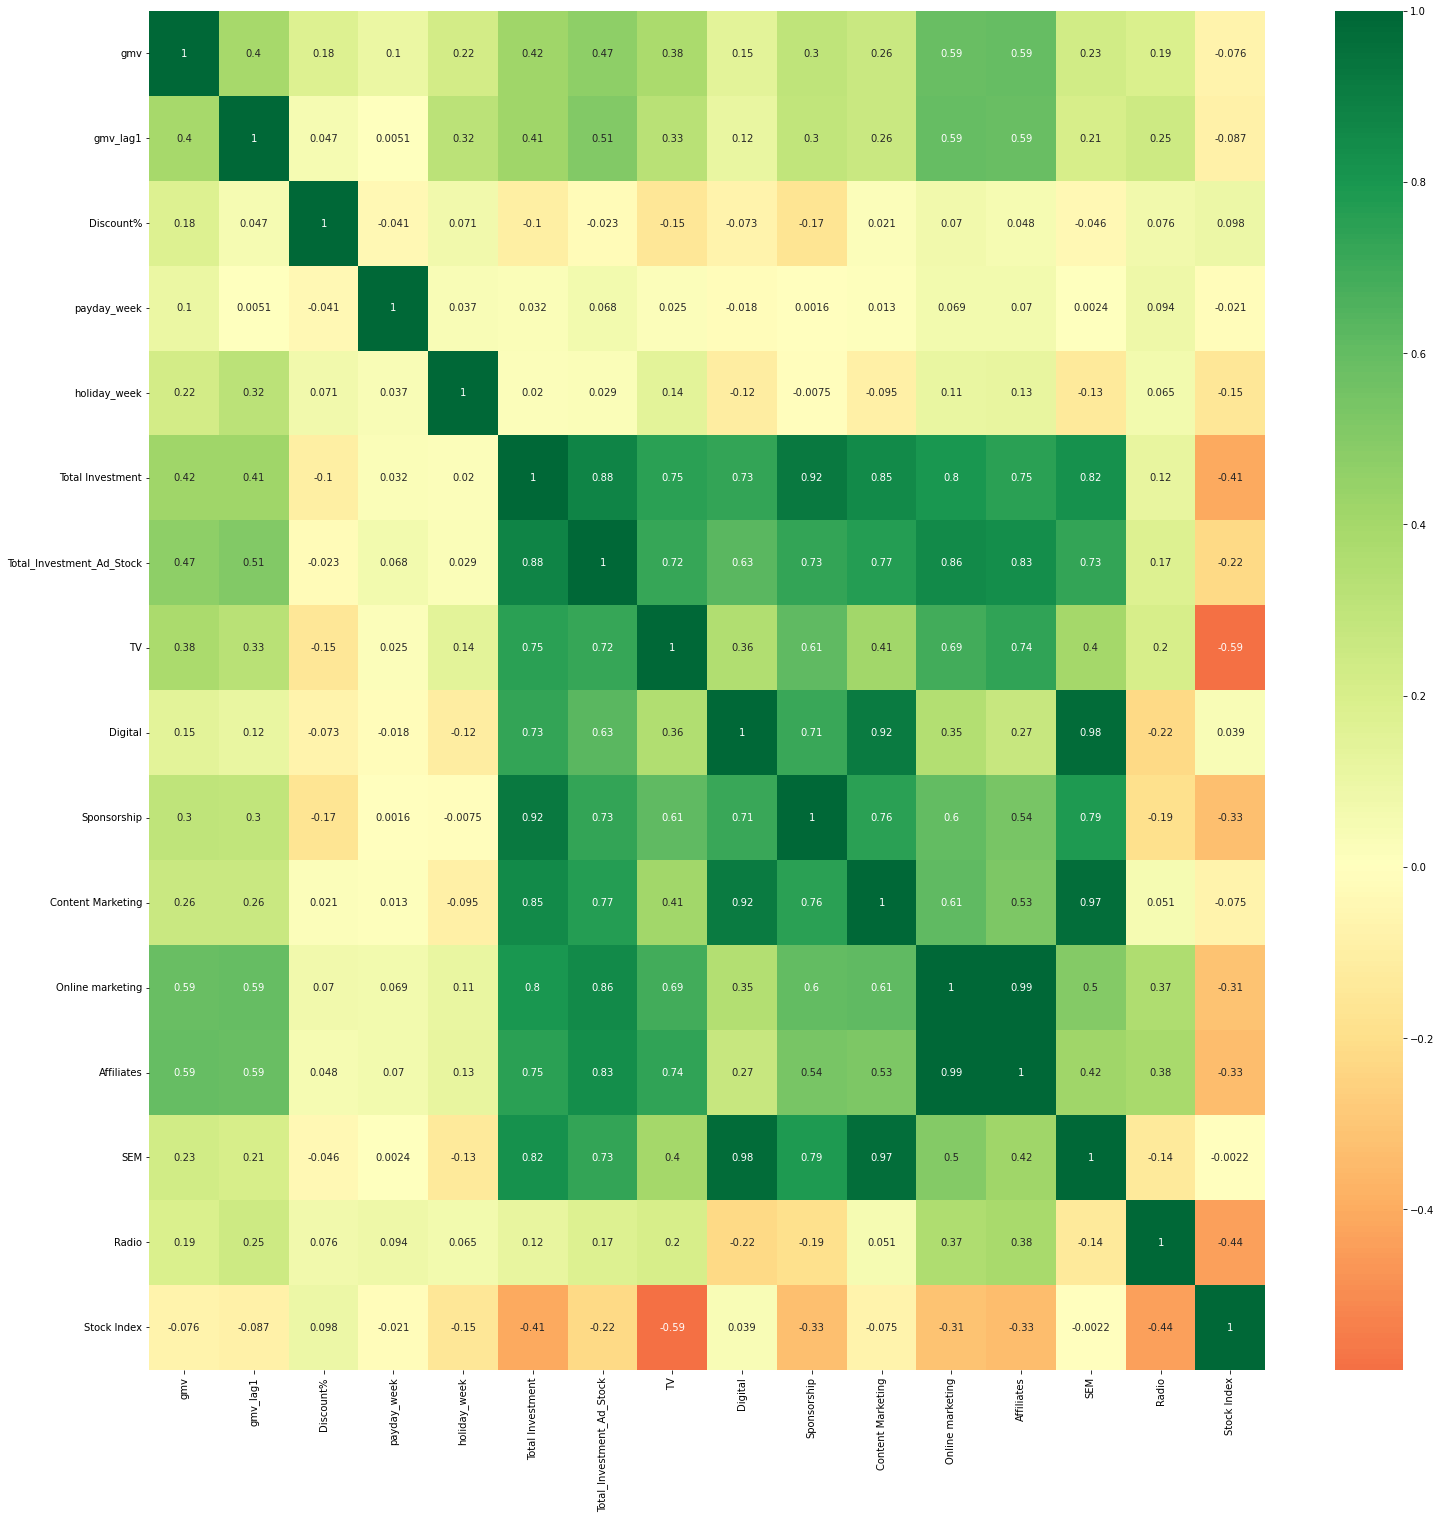

In [379]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df[imp_var].corr(), annot=True,cmap='RdYlGn',center=0) 

The correlation with the lag of GMV is stronger this time. So, can expect a higher R2 as well.

In [380]:
model = sm.OLS(df['gmv'], df[['gmv_lag1']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.807
Model:                            OLS   Adj. R-squared (uncentered):              0.803
Method:                 Least Squares   F-statistic:                              209.1
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.70e-19
Time:                        09:10:45   Log-Likelihood:                         -795.22
No. Observations:                  51   AIC:                                      1592.
Df Residuals:                      50   BIC:                                      1594.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

The P-values are significant and the model has a higher R2 compared to the prev category.

In [381]:
# df = sm.add_constant(df)
model = sm.OLS(df['gmv'], df[imp_var]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.263e+30
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                        0.00
Time:                        09:10:45   Log-Likelihood:                          910.29
No. Observations:                  51   AIC:                                     -1789.
Df Residuals:                      35   BIC:                                     -1758.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

Many variables are not significant. The signs of the coeffs don't go well.

Let's so stepwise selection.

In [382]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], initial_list = ['gmv_lag1', 'Discount%', 
                                                                               'payday_week', 'holiday_week', 
                                                                               'Total_Investment_Ad_Stock', 'TV', 
                                                                               'Digital', 'Sponsorship', 
                                                                               'Content Marketing', 'Affiliates', 
                                                                               'Radio'], threshold_in=0.05, threshold_out = 0.15)

print('resulting features:')
print(result)

Drop payday_week                    with p-value 0.741304
Drop Total_Investment_Ad_Stock      with p-value 0.646164
resulting features:
['gmv_lag1', 'Discount%', 'holiday_week', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Affiliates', 'Radio']


In [383]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.922
Model:                            OLS   Adj. R-squared (uncentered):              0.905
Method:                 Least Squares   F-statistic:                              55.13
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    2.17e-20
Time:                        09:10:47   Log-Likelihood:                         -772.14
No. Observations:                  51   AIC:                                      1562.
Df Residuals:                      42   BIC:                                      1580.
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### Determining Feature Elasicity

In [384]:
model.params

gmv_lag1            -2.155921e-01
Discount%           -1.163897e+03
holiday_week         6.032616e+05
TV                  -1.923335e+06
Digital              3.373397e+06
Sponsorship          1.152889e+05
Content Marketing   -1.410975e+07
Affiliates           3.691288e+06
Radio                3.499327e+06
dtype: float64

In [385]:
model_parameters = model.params.index.to_list()
model_parameters

['gmv_lag1',
 'Discount%',
 'holiday_week',
 'TV',
 'Digital',
 'Sponsorship',
 'Content Marketing',
 'Affiliates',
 'Radio']

In [386]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

gmv_lag1 -0.2130281373401053
Discount% -0.01729735254089267
holiday_week 0.04361910236372586
TV -0.5470288749274351
Digital 0.6552442977681607
Sponsorship 0.27608418738132867
Content Marketing -0.7239793924874048
Affiliates 1.4442944201475358
Radio 0.09193843001037078


The affiliates seem to be most impactful, followed by digital and sponsorship.

However, this is not a final and valid inference, since we don't have an answer for why the sign of the variables are negative.  May be it's because of mulicollinearity (check the VIF), may be there could be some explained business reason, only an expert could asnwer about what really happens in the field.

## Building Linear Regression model for `cameraaccessory`

In [587]:
df = cameraaccessory_koy_df.copy()

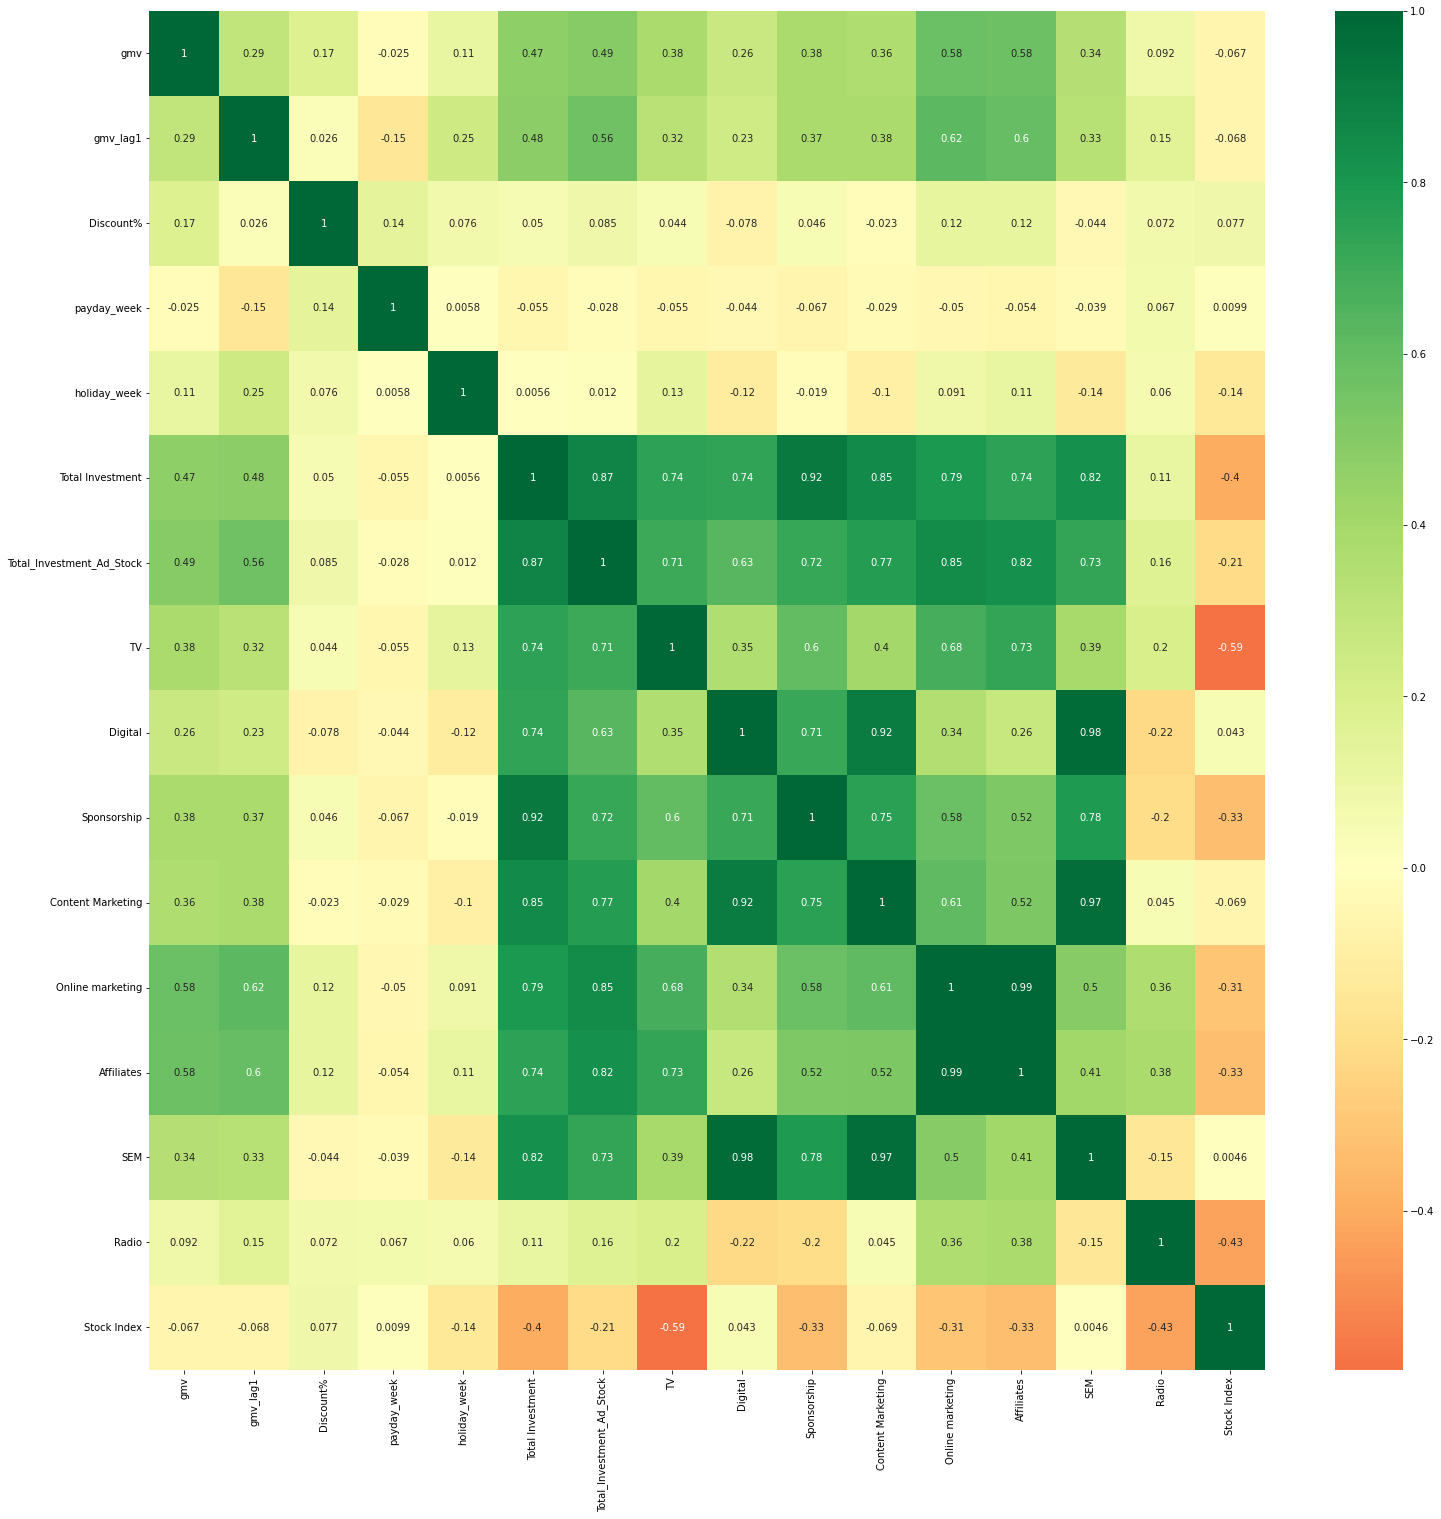

In [588]:
# Check the multicollinearity of features using the correlation matric
plt.figure(figsize=(25,25))
p = sns.heatmap(df[imp_var].corr(), annot=True,cmap='RdYlGn',center=0) 

In [589]:
model = sm.OLS(df['gmv'], df[['gmv_lag1']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.788
Method:                 Least Squares   F-statistic:                              187.0
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    2.37e-18
Time:                        13:58:06   Log-Likelihood:                         -806.11
No. Observations:                  50   AIC:                                      1614.
Df Residuals:                      49   BIC:                                      1616.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [590]:
model = sm.OLS(df['gmv'], df[imp_var]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          6.934e+29
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                        0.00
Time:                        13:58:07   Log-Likelihood:                          853.53
No. Observations:                  50   AIC:                                     -1675.
Df Residuals:                      34   BIC:                                     -1644.
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

__Select the variables with stepwise__


In [591]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], 
                            initial_list = ['gmv_lag1', 'Discount%', 'payday_week', 
                                            'holiday_week', 'Total_Investment_Ad_Stock', 
                                            'TV', 'Digital', 'Sponsorship', 
                                            'Content Marketing', 'Affiliates', 'Radio'], 
                            threshold_in=0.05, 
                            threshold_out = 0.1)

print('resulting features:')
print(result)

Add  product_procurement_sla        with p-value 0.00380959
Drop payday_week                    with p-value 0.71244
Add  sla                            with p-value 0.0233011
Drop gmv_lag1                       with p-value 0.152681
Drop Sponsorship                    with p-value 0.110847
Add  Online marketing               with p-value 0.0227004
Drop Affiliates                     with p-value 0.206163
resulting features:
['Discount%', 'holiday_week', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Content Marketing', 'Radio', 'product_procurement_sla', 'sla', 'Online marketing']


In [592]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.925
Model:                            OLS   Adj. R-squared (uncentered):              0.907
Method:                 Least Squares   F-statistic:                              49.48
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    2.37e-19
Time:                        13:58:19   Log-Likelihood:                         -780.58
No. Observations:                  50   AIC:                                      1581.
Df Residuals:                      40   BIC:                                      1600.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

We are not able to get a model with significant features. Let's go ahead and compute the feature elasticity anyways. We will have to explore other options anyway.

### Determining Feature Elasicity

In [593]:
model.params

Discount%                    4.233317e+04
holiday_week                 2.233440e+05
Total_Investment_Ad_Stock   -3.009171e+04
TV                          -6.789453e+05
Digital                      2.750663e+06
Content Marketing           -8.786947e+06
Radio                        6.741428e+05
product_procurement_sla      1.487890e+06
sla                         -6.477011e+05
Online marketing             1.173455e+06
dtype: float64

In [594]:
model_parameters = model.params.index.to_list()
model_parameters

['Discount%',
 'holiday_week',
 'Total_Investment_Ad_Stock',
 'TV',
 'Digital',
 'Content Marketing',
 'Radio',
 'product_procurement_sla',
 'sla',
 'Online marketing']

In [595]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Discount% 0.41885578748877417
holiday_week 0.009978302402973068
Total_Investment_Ad_Stock -0.24687678431588464
TV -0.11931397927977827
Digital 0.3272697034783298
Content Marketing -0.2785840852657699
Radio 0.010943993360250454
product_procurement_sla 0.8079119770467371
sla -0.822646168260692
Online marketing 0.8954735393039056


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8.4. Distributive Lag Model(Additive)</h2>
</div>

*The Additive and Multiplicative Linear Models that we have built till now can capture the current effect of the KPIs. However, if we want to capture the carry-over effect, we would want to model the current revenue figures based on the past figures of the KPIs.*

*In the distributed lag model, not only is the dependent variable entered in its lagged version, but the independent variables are as well. This is a more generalist model and captures the carry-over effect of all the variables. Thus, the Koyck model is a special type of distributed lag model, which includes the lag value of only the dependent variable.*


  __Yt__ = α+ µ1Yt-1 + µ2Yt-2 + µ3Yt-3 + ....

        + β1X1t + β1X1t-1 + β1X1t-2 + ....

        + β2X2t + β2X2t-1 + β2X2t-2 + ....

        + β3X3t + β3X3t-1 + β3X3t-2 + ....

        + β4X4t + β4X4t-1 + β4X4t-2 + ....

        + β5X5t + β5X5t-1 + β5X5t-2 + ....

        + ϵ

In [396]:
homeaudio_org_df.head()

Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  

__Make Copies__

In [397]:
# Making copy of dataframes from the original ones
cameraaccessory_dladd_df = cameraaccessory_org_df.copy()
gamingaccessory_dladd_df = gamingaccessory_org_df.copy()
homeaudio_dladd_df = homeaudio_org_df.copy()
homeaudio_dladd_df.head()

Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  

#### We will drop the `Week` column as it is a row identifier and will not help in prediction of revenue

In [398]:
# removing columns
cameraaccessory_dladd_df = cameraaccessory_dladd_df.drop('Week', axis=1)
gamingaccessory_dladd_df = gamingaccessory_dladd_df.drop('Week', axis=1)
homeaudio_dladd_df = homeaudio_dladd_df.drop('Week', axis=1)
homeaudio_dladd_df.head()

gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  3.451151e+06  32.207530          

### Creating new lag(Lag of 3 weeks) variables for the dependent variable (GMV) as well as independent variables

In [399]:
cameraaccessory_dladd_df_columns = cameraaccessory_dladd_df.columns
gamingaccessory_dladd_df_columns = gamingaccessory_dladd_df.columns
homeaudio_dladd_df_columns = homeaudio_dladd_df.columns

In [400]:
cameraaccessory_dladd_df = lag_variables(cameraaccessory_dladd_df,cameraaccessory_dladd_df_columns,3)
gamingaccessory_dladd_df = lag_variables(gamingaccessory_dladd_df,gamingaccessory_dladd_df_columns,3)
homeaudio_dladd_df = lag_variables(homeaudio_dladd_df,homeaudio_dladd_df_columns,3)
homeaudio_dladd_df.head()

gmv      gmv_lag3  Discount%  Discount%_lag3  deliverybdays  deliverybdays_lag3  deliverycdays  deliverycdays_lag3       sla  sla_lag3  product_procurement_sla  product_procurement_sla_lag3    is_cod  is_cod_lag3  is_mass_market  is_mass_market_lag3  payday_week  payday_week_lag3  holiday_week  holiday_week_lag3  Total Investment  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag3  Total Investment_SMA_5  Total Investment_SMA_5_lag3  Total Investment_EMA_8  Total Investment_EMA_8_lag3  Total_Investment_Ad_Stock  Total_Investment_Ad_Stock_lag3     TV  TV_lag3  TV_SMA_3  TV_SMA_3_lag3  TV_SMA_5  TV_SMA_5_lag3  TV_EMA_8  TV_EMA_8_lag3  TV_Ad_Stock  TV_Ad_Stock_lag3  Digital  Digital_lag3  Digital_SMA_3  Digital_SMA_3_lag3  Digital_SMA_5  Digital_SMA_5_lag3  Digital_EMA_8  Digital_EMA_8_lag3  Digital_Ad_Stock  Digital_Ad_Stock_lag3  Sponsorship  Sponsorship_lag3  Sponsorship_SMA_3  Sponsorship_SMA_3_lag3  Sponsorship_SMA_5  Sponsorship_SMA_5_lag3  \
0  4.573783e+06           NaN  31.450813             NaN            0.0                 NaN            0.0                 NaN  7.369201       NaN                 2.863223                           NaN  0.757054          NaN        0.653276                  NaN            0               NaN             0                NaN             4.265                    NaN                   0.000                          NaN                  0.0000                          NaN                4.265000                          NaN                   4.265000                             NaN  0.054      NaN  0.000000            NaN    0.0000            NaN  0.054000            NaN     0.054000               NaN    0.633           NaN       0.000000                 NaN         0.0000                 NaN       0.633000                 NaN          0.633000                    NaN        1.854               NaN              0.000                     NaN             0.0000                     NaN   
1  5.371525e+06           NaN  32.966657             NaN            0.0                 NaN            0.0                 NaN  6.984861       NaN                 2.746318                           NaN  0.764321          NaN        0.658756                  NaN            1               NaN             0                NaN             4.265                    NaN                   0.000                          NaN                  0.0000                          NaN                4.265000                          NaN                   6.824000                             NaN  0.054      NaN  0.000000            NaN    0.0000            NaN  0.054000            NaN     0.086400               NaN    0.633           NaN       0.000000                 NaN         0.0000                 NaN       0.633000                 NaN          1.012800                    NaN        1.854               NaN              0.000                     NaN             0.0000                     NaN   
2  4.679828e+06           NaN  32.357350             NaN            0.0                 NaN            0.0                 NaN  7.071749       NaN                 2.860538                           NaN  0.788341          NaN        0.703587                  NaN            0               NaN             0                NaN             4.265                    NaN                   4.265                          NaN                  0.0000                          NaN                4.265000                          NaN                   8.359400                             NaN  0.054      NaN  0.054000            NaN    0.0000            NaN  0.054000            NaN     0.105840               NaN    0.633           NaN       0.633000                 NaN         0.0000                 NaN       0.633000                 NaN          1.240680                    NaN        1.854               NaN              1.854                     NaN             0.0000                     NaN   
3  3.451151e+06  4.573783e+0

### Creating new lag(Lag of 2 weeks) variables for the dependent variable (GMV) as well as independent variables

In [401]:
cameraaccessory_dladd_df = lag_variables(cameraaccessory_dladd_df,cameraaccessory_dladd_df_columns,2)
gamingaccessory_dladd_df = lag_variables(gamingaccessory_dladd_df,gamingaccessory_dladd_df_columns,2)
homeaudio_dladd_df = lag_variables(homeaudio_dladd_df,homeaudio_dladd_df_columns,2)
homeaudio_dladd_df.head()

gmv      gmv_lag2      gmv_lag3  Discount%  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag2  deliverycdays_lag3       sla  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag2  product_procurement_sla_lag3    is_cod  is_cod_lag2  is_cod_lag3  is_mass_market  is_mass_market_lag2  is_mass_market_lag3  payday_week  payday_week_lag2  payday_week_lag3  holiday_week  holiday_week_lag2  holiday_week_lag3  Total Investment  Total Investment_lag2  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag2  Total Investment_SMA_3_lag3  Total Investment_SMA_5  Total Investment_SMA_5_lag2  Total Investment_SMA_5_lag3  Total Investment_EMA_8  Total Investment_EMA_8_lag2  Total Investment_EMA_8_lag3  Total_Investment_Ad_Stock  Total_Investment_Ad_Stock_lag2  Total_Investment_Ad_Stock_lag3     TV  TV_lag2  TV_lag3  TV_SMA_3  TV_SMA_3_lag2  TV_SMA_3_lag3  TV_SMA_5  TV_SMA_5_lag2  \
0  4.573783e+06           NaN           NaN  31.450813             NaN             NaN            0.0                 NaN                 NaN            0.0                 NaN                 NaN  7.369201       NaN       NaN                 2.863223                           NaN                           NaN  0.757054          NaN          NaN        0.653276                  NaN                  NaN            0               NaN               NaN             0                NaN                NaN             4.265                    NaN                    NaN                   0.000                          NaN                          NaN                  0.0000                          NaN                          NaN                4.265000                          NaN                          NaN                   4.265000                             NaN                             NaN  0.054      NaN      NaN  0.000000            NaN            NaN    0.0000            NaN   
1  5.371525e+06           NaN           NaN  32.966657             NaN             NaN            0.0                 NaN                 NaN            0.0                 NaN                 NaN  6.984861       NaN       NaN                 2.746318                           NaN                           NaN  0.764321          NaN          NaN        0.658756                  NaN                  NaN            1               NaN               NaN             0                NaN                NaN             4.265                    NaN                    NaN                   0.000                          NaN                          NaN                  0.0000                          NaN                          NaN                4.265000                          NaN                          NaN                   6.824000                             NaN                             NaN  0.054      NaN      NaN  0.000000            NaN            NaN    0.0000            NaN   
2  4.679828e+06  4.573783e+06           NaN  32.357350       31.450813             NaN            0.0                 0.0                 NaN            0.0                 0.0                 NaN  7.071749  7.369201       NaN                 2.860538                      2.863223                           NaN  0.788341     0.757054          NaN        0.703587             0.653276                  NaN            0               0.0               NaN             0                0.0                NaN             4.265                  4.265                    NaN                   4.265                        0.000                          NaN                  0.0000                          0.0                          NaN                4.265000                        4.265                          NaN                   8.359400                          4.2650                             NaN  0.054    0.054      NaN  0.054000          0.000            NaN    0.0000            0.0   
3  3.451

### Creating new lag(Lag of 1 week) variables for the dependent variable (GMV) as well as independent variables

In [402]:
cameraaccessory_dladd_df = lag_variables(cameraaccessory_dladd_df,cameraaccessory_dladd_df_columns,1)
gamingaccessory_dladd_df = lag_variables(gamingaccessory_dladd_df,gamingaccessory_dladd_df_columns,1)
homeaudio_dladd_df = lag_variables(homeaudio_dladd_df,homeaudio_dladd_df_columns,1)
homeaudio_dladd_df.head()

gmv      gmv_lag1      gmv_lag2      gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3       sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3    is_cod  is_cod_lag1  is_cod_lag2  is_cod_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  payday_week  payday_week_lag1  payday_week_lag2  payday_week_lag3  holiday_week  holiday_week_lag1  holiday_week_lag2  holiday_week_lag3  Total Investment  Total Investment_lag1  Total Investment_lag2  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag1  Total Investment_SMA_3_lag2  Total Investment_SMA_3_lag3  Total Investment_SMA_5  Total Investment_SMA_5_lag1  Total Investment_SMA_5_lag2  Total Investment_SMA_5_lag3  \
0  4.573783e+06           NaN           NaN           NaN  31.450813             NaN             NaN             NaN            0.0                 NaN                 NaN                 NaN            0.0                 NaN                 NaN                 NaN  7.369201       NaN       NaN       NaN                 2.863223                           NaN                           NaN                           NaN  0.757054          NaN          NaN          NaN        0.653276                  NaN                  NaN                  NaN            0               NaN               NaN               NaN             0                NaN                NaN                NaN             4.265                    NaN                    NaN                    NaN                   0.000                          NaN                          NaN                          NaN                  0.0000                          NaN                          NaN                          NaN   
1  5.371525e+06  4.573783e+06           NaN           NaN  32.966657       31.450813             NaN             NaN            0.0                 0.0                 NaN                 NaN            0.0                 0.0                 NaN                 NaN  6.984861  7.369201       NaN       NaN                 2.746318                      2.863223                           NaN                           NaN  0.764321     0.757054          NaN          NaN        0.658756             0.653276                  NaN                  NaN            1               0.0               NaN               NaN             0                0.0                NaN                NaN             4.265                  4.265                    NaN                    NaN                   0.000                        0.000                          NaN                          NaN                  0.0000                          0.0                          NaN                          NaN   
2  4.679828e+06  5.371525e+06  4.573783e+06           NaN  32.357350       32.966657       31.450813             NaN            0.0                 0.0                 0.0                 NaN            0.0                 0.0                 0.0                 NaN  7.071749  6.984861  7.369201       NaN                 2.860538                      2.746318                      2.863223                           NaN  0.788341     0.764321     0.757054          NaN        0.703587             0.658756             0.653276                  NaN            0               1.0               0.0               NaN             0                0.0                0.0                NaN             4.265                  4.265                  4.265                    NaN                   4.265                        0.000                        0.000                          NaN                  0.0000                          0.0                          0.0                          NaN   
3  3.451151e

####  Imputing all null values with 0

In [403]:
# Imputing all null values with 0
cameraaccessory_dladd_df.fillna(value=0, inplace=True)
gamingaccessory_dladd_df.fillna(value=0, inplace=True)
homeaudio_dladd_df.fillna(value=0, inplace=True)
homeaudio_dladd_df.head(10)

gmv      gmv_lag1      gmv_lag2      gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3       sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3    is_cod  is_cod_lag1  is_cod_lag2  is_cod_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  payday_week  payday_week_lag1  payday_week_lag2  payday_week_lag3  holiday_week  holiday_week_lag1  holiday_week_lag2  holiday_week_lag3  Total Investment  Total Investment_lag1  Total Investment_lag2  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag1  Total Investment_SMA_3_lag2  Total Investment_SMA_3_lag3  Total Investment_SMA_5  Total Investment_SMA_5_lag1  Total Investment_SMA_5_lag2  Total Investment_SMA_5_lag3  \
0  4.573783e+06  0.000000e+00  0.000000e+00  0.000000e+00  31.450813        0.000000        0.000000        0.000000       0.000000                 0.0                 0.0                 0.0       0.000000                 0.0                 0.0                 0.0  7.369201  0.000000  0.000000  0.000000                 2.863223                      0.000000                      0.000000                      0.000000  0.757054     0.000000     0.000000     0.000000        0.653276             0.000000             0.000000             0.000000            0               0.0               0.0               0.0             0                0.0                0.0                0.0             4.265                  0.000                  0.000                  0.000                0.000000                     0.000000                     0.000000                     0.000000                  0.0000                       0.0000                       0.0000                       0.0000   
1  5.371525e+06  4.573783e+06  0.000000e+00  0.000000e+00  32.966657       31.450813        0.000000        0.000000       0.000000                 0.0                 0.0                 0.0       0.000000                 0.0                 0.0                 0.0  6.984861  7.369201  0.000000  0.000000                 2.746318                      2.863223                      0.000000                      0.000000  0.764321     0.757054     0.000000     0.000000        0.658756             0.653276             0.000000             0.000000            1               0.0               0.0               0.0             0                0.0                0.0                0.0             4.265                  4.265                  0.000                  0.000                0.000000                     0.000000                     0.000000                     0.000000                  0.0000                       0.0000                       0.0000                       0.0000   
2  4.679828e+06  5.371525e+06  4.573783e+06  0.000000e+00  32.357350       32.966657       31.450813        0.000000       0.000000                 0.0                 0.0                 0.0       0.000000                 0.0                 0.0                 0.0  7.071749  6.984861  7.369201  0.000000                 2.860538                      2.746318                      2.863223                      0.000000  0.788341     0.764321     0.757054     0.000000        0.703587             0.658756             0.653276             0.000000            0               1.0               0.0               0.0             0                0.0                0.0                0.0             4.265                  4.265                  4.265                  0.000                4.265000                     0.000000                     0.000000                     0.000000                  0.0000                       0.0000                       0.0000                       0.0000   
3  3.451151e

## Building Linear Regression model for `gamingaccessory`

In [404]:
df = gamingaccessory_dladd_df.copy()

In [405]:
# # Check the multicollinearity of features using the correlation matric
# plt.figure(figsize=(25,25))
# p = sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0) 

In [406]:
model = sm.OLS(df['gmv'], df[['gmv_lag1', 'gmv_lag2', 'gmv_lag3']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.852
Model:                            OLS   Adj. R-squared (uncentered):              0.842
Method:                 Least Squares   F-statistic:                              91.89
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    6.65e-20
Time:                        09:11:03   Log-Likelihood:                         -788.51
No. Observations:                  51   AIC:                                      1583.
Df Residuals:                      48   BIC:                                      1589.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

__Include all variables and build! Just for the gags, usually a bad idea!__

In [407]:
model = sm.OLS(df['gmv'], df.drop(['gmv'], axis = 1)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                nan
Time:                        09:11:03   Log-Likelihood:                 366.24
No. Observations:                  51   AIC:                            -630.5
Df Residuals:                       0   BIC:                            -531.9
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
gmv_lag1  

### Determining Feature Elasicity

In [408]:
model.params

gmv_lag1                               -0.521043
gmv_lag2                               -0.788099
gmv_lag3                               -0.282350
Discount%                          126103.000671
Discount%_lag1                      32676.389425
Discount%_lag2                      51251.111094
Discount%_lag3                     -67465.410211
deliverybdays                       57001.504034
deliverybdays_lag1                  -9906.499737
deliverybdays_lag2                   4056.137106
deliverybdays_lag3                  46319.973443
deliverycdays                       69930.293056
deliverycdays_lag1                  -9382.899471
deliverycdays_lag2                   5156.005084
deliverycdays_lag3                  54119.219832
sla                                 61006.774577
sla_lag1                           -26300.884421
sla_lag2                            32350.068271
sla_lag3                          -112249.542054
product_procurement_sla              8964.507089
product_procurement_

In [409]:
model_parameters = model.params.index.to_list()
# model_parameters

In [410]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

gmv_lag1 -0.5148465363412074
gmv_lag2 -0.7624414144005215
gmv_lag3 -0.26683863629197635
Discount% 1.8740897031829014
Discount%_lag1 0.47682980503009975
Discount%_lag2 0.7336856047948542
Discount%_lag3 -0.9460700385629383
deliverybdays 0.01934016783011094
deliverybdays_lag1 -0.0031369293080054077
deliverybdays_lag2 0.0011885212635132343
deliverybdays_lag3 0.01244119470063538
deliverycdays 0.02808500375960307
deliverycdays_lag1 -0.0035225935670743663
deliverycdays_lag2 0.0017924956347411358
deliverycdays_lag3 0.017248363388437427
sla 0.11574371956872238
sla_lag1 -0.04903176981950166
sla_lag2 0.059090100879806894
sla_lag3 -0.20074833125607644
product_procurement_sla 0.007679461733951768
product_procurement_sla_lag1 -0.005773136537056541
product_procurement_sla_lag2 -0.006461906505114582
product_procurement_sla_lag3 0.006580320237313166
is_cod -0.00013605892078596347
is_cod_lag1 -0.0004960374520205534
is_cod_lag2 0.0016245562475076475
is_cod_lag3 -0.001954980689286999
is_mass_market -0.000

__Run stepwise__

In [411]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  Online_marketing_Ad_Stock      with p-value 1.38963e-06
Add  Digital_EMA_8_lag2             with p-value 0.0034735
Add  NPS_SMA_5                      with p-value 0.0245932
resulting features:
['Online_marketing_Ad_Stock', 'Digital_EMA_8_lag2', 'NPS_SMA_5']


In [412]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.881
Model:                            OLS   Adj. R-squared (uncentered):              0.873
Method:                 Least Squares   F-statistic:                              117.9
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    3.77e-22
Time:                        09:11:09   Log-Likelihood:                         -783.00
No. Observations:                  51   AIC:                                      1572.
Df Residuals:                      48   BIC:                                      1578.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

We should ideally remove the Digital_EMA terms as well. It's probably retained for a lack of better model.

### Determining Feature Elasicity

In [413]:
model.params

Online_marketing_Ad_Stock    262151.854575
Digital_EMA_8_lag2          -628541.556335
NPS_SMA_5                     17391.333467
dtype: float64

In [414]:
model_parameters = model.params.index.to_list()
# model_parameters

In [415]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Online_marketing_Ad_Stock 0.7946672858054304
Digital_EMA_8_lag2 -0.12325962689432364
NPS_SMA_5 0.2660186566788374


## Building Linear Regression model for `cameraaccessory`

In [416]:
df = cameraaccessory_dladd_df.copy()

In [417]:
# # Check the multicollinearity of features using the correlation matric
# plt.figure(figsize=(25,25))
# p = sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0) 

In [418]:
model = sm.OLS(df['gmv'], df[['gmv_lag1', 'gmv_lag2', 'gmv_lag3']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.836
Model:                            OLS   Adj. R-squared (uncentered):              0.825
Method:                 Least Squares   F-statistic:                              79.58
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.93e-18
Time:                        09:11:09   Log-Likelihood:                         -800.28
No. Observations:                  50   AIC:                                      1607.
Df Residuals:                      47   BIC:                                      1612.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

__Note:__

The first two lags are significant. 

In [419]:
model = sm.OLS(df['gmv'], df.drop(['gmv'], axis = 1)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                nan
Time:                        09:11:09   Log-Likelihood:                 340.22
No. Observations:                  50   AIC:                            -580.4
Df Residuals:                       0   BIC:                            -484.8
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
gmv_lag1  

### Determining Feature Elasicity

In [420]:
model.params

gmv_lag1                               -0.914423
gmv_lag2                               -0.924840
gmv_lag3                               -0.621401
Discount%                           90171.937335
Discount%_lag1                     -18030.227799
Discount%_lag2                     109285.064062
Discount%_lag3                      97230.684645
deliverybdays                       37675.158780
deliverybdays_lag1                 -15952.708950
deliverybdays_lag2                   4296.919282
deliverybdays_lag3                  61499.723528
deliverycdays                       47407.914083
deliverycdays_lag1                 -18522.966090
deliverycdays_lag2                   3409.153183
deliverycdays_lag3                  73460.779735
sla                                 87031.510861
sla_lag1                           -81474.531581
sla_lag2                            18454.966845
sla_lag3                           -28767.134862
product_procurement_sla             13526.451271
product_procurement_

In [421]:
model_parameters = model.params.index.to_list()
# model_parameters

In [422]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

gmv_lag1 -0.9043640842908797
gmv_lag2 -0.8995077532152239
gmv_lag3 -0.5917812655149065
Discount% 0.8921854691425284
Discount%_lag1 -0.1748359525479605
Discount%_lag2 1.0383233627613797
Discount%_lag3 0.9030597426153923
deliverybdays 0.007683550520203064
deliverybdays_lag1 -0.00302416577106275
deliverybdays_lag2 0.0007500394865326605
deliverybdays_lag3 0.009802837237891852
deliverycdays 0.01145955354552536
deliverycdays_lag1 -0.004161735454754284
deliverycdays_lag2 0.0007052170094871372
deliverycdays_lag3 0.01387549016197237
sla 0.1105388548546295
sla_lag1 -0.10168816045580464
sla_lag2 0.022584994761957806
sla_lag3 -0.03454089511023774
product_procurement_sla 0.00734475053275879
product_procurement_sla_lag1 -0.0007336272654444109
product_procurement_sla_lag2 -0.005400217331960442
product_procurement_sla_lag3 -0.0047977959604448735
is_cod 0.0012656783593678724
is_cod_lag1 0.00011170496010329447
is_cod_lag2 0.0013996888012452798
is_cod_lag3 -0.0017144381091035387
is_mass_market 0.00028082

__Curious what features get retained__


In [423]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  NPS                            with p-value 5.46845e-06
Add  Cool Deg Days_lag1             with p-value 0.0155153
Add  Digital_EMA_8_lag3             with p-value 0.0174136
resulting features:
['NPS', 'Cool Deg Days_lag1', 'Digital_EMA_8_lag3']


In [424]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.871
Model:                            OLS   Adj. R-squared (uncentered):              0.863
Method:                 Least Squares   F-statistic:                              105.8
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    6.52e-21
Time:                        09:11:14   Log-Likelihood:                         -794.21
No. Observations:                  50   AIC:                                      1594.
Df Residuals:                      47   BIC:                                      1600.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

### Determining Feature Elasicity

In [425]:
model.params

NPS                   121833.886400
Cool Deg Days_lag1   -649549.651047
Digital_EMA_8_lag3   -515730.321054
dtype: float64

In [426]:
model_parameters = model.params.index.to_list()
# model_parameters

In [427]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

NPS 1.2255764428945275
Cool Deg Days_lag1 -0.18230605487319862
Digital_EMA_8_lag3 -0.06103843608087797


## Building Linear Regression model for `homeaudio`

In [428]:
df = homeaudio_dladd_df.copy()

In [429]:
# # Check the multicollinearity of features using the correlation matric
# plt.figure(figsize=(25,25))
# p = sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0) 

In [430]:
model = sm.OLS(df['gmv'], df[['gmv_lag1', 'gmv_lag2', 'gmv_lag3']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.734
Model:                            OLS   Adj. R-squared (uncentered):              0.716
Method:                 Least Squares   F-statistic:                              41.43
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    5.32e-13
Time:                        09:11:14   Log-Likelihood:                         -781.21
No. Observations:                  48   AIC:                                      1568.
Df Residuals:                      45   BIC:                                      1574.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

All variables are significant and the R2 is not bad either.

In [431]:
model = sm.OLS(df['gmv'], df.drop(['gmv'], axis = 1)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                nan
Time:                        09:11:14   Log-Likelihood:                 284.08
No. Observations:                  48   AIC:                            -472.2
Df Residuals:                       0   BIC:                            -382.3
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
gmv_lag1  

### Determining Feature Elasicity

In [432]:
model.params

gmv_lag1                               -0.644164
gmv_lag2                               -0.709607
gmv_lag3                               -0.749403
Discount%                          256063.870387
Discount%_lag1                    -100054.338512
Discount%_lag2                     -25314.953496
Discount%_lag3                     218563.748639
deliverybdays                      -46878.891775
deliverybdays_lag1                 -97824.118354
deliverybdays_lag2                  -6050.251697
deliverybdays_lag3                  14374.343437
deliverycdays                      -59452.168402
deliverycdays_lag1                -111819.377684
deliverycdays_lag2                  -7360.213331
deliverycdays_lag3                  17850.766209
sla                                 64032.026728
sla_lag1                           -90118.079466
sla_lag2                            63681.240146
sla_lag3                           -32631.668058
product_procurement_sla            -13154.701914
product_procurement_

In [433]:
model_parameters = model.params.index.to_list()
# model_parameters

In [434]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

gmv_lag1 -0.6396264143955274
gmv_lag2 -0.694396787460619
gmv_lag3 -0.7211672794537519
Discount% 1.8860752545488981
Discount%_lag1 -0.7237105060277828
Discount%_lag2 -0.17972015568924407
Discount%_lag3 1.5237528152595368
deliverybdays -0.00919227227833666
deliverybdays_lag1 -0.018033816314391868
deliverybdays_lag2 -0.0010444192918877232
deliverybdays_lag3 0.002267189151083519
deliverycdays -0.013809398214114097
deliverycdays_lag1 -0.02446538079515325
deliverycdays_lag2 -0.0015084699970338649
deliverycdays_lag3 0.0033432283048054913
sla 0.07581639717598683
sla_lag1 -0.10513263657323775
sla_lag2 0.07311077449344819
sla_lag3 -0.036748306993965196
product_procurement_sla -0.007208621435622321
product_procurement_sla_lag1 0.007013151996211567
product_procurement_sla_lag2 -0.013348583847600523
product_procurement_sla_lag3 0.013776801514821956
is_cod 0.0013041932121793164
is_cod_lag1 0.0028237629419467078
is_cod_lag2 0.004593794728895154
is_cod_lag3 -0.0004349689650710111
is_mass_market 0.0002

In [435]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  Content Marketing_lag1         with p-value 3.55494e-06
Add  Discount%                      with p-value 0.000100558
Add  SEM_lag2                       with p-value 0.00228091
Add  Digital_lag1                   with p-value 0.0126667
Drop Content Marketing_lag1         with p-value 0.401641
Add  product_procurement_sla        with p-value 0.00450841
Add  NPS_SMA_3_lag1                 with p-value 0.00846606
Add  Cool Deg Days_lag3             with p-value 0.0317073
Add  payday_week_lag2               with p-value 0.0480849
resulting features:
['Discount%', 'SEM_lag2', 'Digital_lag1', 'product_procurement_sla', 'NPS_SMA_3_lag1', 'Cool Deg Days_lag3', 'payday_week_lag2']


In [436]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.946
Method:                 Least Squares   F-statistic:                              120.8
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    2.70e-25
Time:                        09:11:28   Log-Likelihood:                         -739.23
No. Observations:                  48   AIC:                                      1492.
Df Residuals:                      41   BIC:                                      1506.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

### Determining Feature Elasicity

In [437]:
model.params

Discount%                  4.746848e+05
SEM_lag2                  -5.372544e+05
Digital_lag1               2.073649e+06
product_procurement_sla   -4.019154e+06
NPS_SMA_3_lag1            -5.087358e+04
Cool Deg Days_lag3         2.486852e+05
payday_week_lag2           7.385982e+05
dtype: float64

In [438]:
model_parameters = model.params.index.to_list()
# model_parameters

In [439]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Discount% 3.496358948333286
SEM_lag2 -0.2002781355524129
Digital_lag1 0.25322998306080746
product_procurement_sla -2.2024491961307597
NPS_SMA_3_lag1 -0.4814421453989399
Cool Deg Days_lag3 0.05378783637659292
payday_week_lag2 0.07614973976908698


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8.5. Distributive Lag Model(Multiplicative)</h2>
</div>

*The Distributive Lag Model(Additive) helped us capture the not only the current, but also the carry-over effect of all the variables(depedent and independent).*


  __Yt__ = α+ µ1Yt-1 + µ2Yt-2 + µ3Yt-3 + ....

        + β1X1t + β1X1t-1 + β1X1t-2 + ....

        + β2X2t + β2X2t-1 + β2X2t-2 + ....

        + β3X3t + β3X3t-1 + β3X3t-2 + ....

        + β4X4t + β4X4t-1 + β4X4t-2 + ....

        + β5X5t + β5X5t-1 + β5X5t-2 + ....

        + ϵ
        
*Now the Distributive Lag Model(Multiplicative) will help us capture the interactions between current and carry over effects of the KPIs.*

*To fit a multiplicative model, take logarithms of the data(on both sides of the model), then analyse the log data as before.*

  __ln(Yt)__ = α+ µ1ln(Yt-1) + µ2ln(Yt-2) + µ3ln(Yt-3) + ....

        + β1ln(X1t) + β1ln(X1t-1) + β1ln(X1t-2) + ....

        + β2ln(X2t) + β2ln(X2t-1) + β2ln(X2t-2) + ....

        + β3ln(X3t) + β3ln(X3t-1) + β3ln(X3t-2) + ....

        + β4ln(X4t) + β4ln(X4t-1) + β4ln(X4t-2) + ....

        + β5ln(X5t) + β5ln(X5t-1) + β5ln(X5t-2) + ....

        + ϵ'

In [440]:
homeaudio_org_df.head()

Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  

In [441]:
# Making copy of dataframes from the original ones
cameraaccessory_dlmul_df = cameraaccessory_org_df.copy()
gamingaccessory_dlmul_df = gamingaccessory_org_df.copy()
homeaudio_dlmul_df = homeaudio_org_df.copy()
homeaudio_dlmul_df.head()

Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  

In [442]:
# removing columns
cameraaccessory_dlmul_df = cameraaccessory_dlmul_df.drop('Week', axis=1)
gamingaccessory_dlmul_df = gamingaccessory_dlmul_df.drop('Week', axis=1)
homeaudio_dlmul_df = homeaudio_dlmul_df.drop('Week', axis=1)
homeaudio_dlmul_df.head()

gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock        NPS  \
0  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
1  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
2  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0  54.599588   
3  3.451151e+06  32.207530          

### Creating new lag(Lag of 3 weeks) variables for the dependent variable (GMV) as well as independent variables

In [443]:
cameraaccessory_dlmul_df_columns = cameraaccessory_dlmul_df.columns
gamingaccessory_dlmul_df_columns = gamingaccessory_dlmul_df.columns
homeaudio_dlmul_df_columns = homeaudio_dlmul_df.columns

In [444]:
cameraaccessory_dlmul_df = lag_variables(cameraaccessory_dlmul_df,cameraaccessory_dlmul_df_columns,3)
gamingaccessory_dlmul_df = lag_variables(gamingaccessory_dlmul_df,gamingaccessory_dlmul_df_columns,3)
homeaudio_dlmul_df = lag_variables(homeaudio_dlmul_df,homeaudio_dlmul_df_columns,3)
homeaudio_dlmul_df.head()

gmv      gmv_lag3  Discount%  Discount%_lag3  deliverybdays  deliverybdays_lag3  deliverycdays  deliverycdays_lag3       sla  sla_lag3  product_procurement_sla  product_procurement_sla_lag3    is_cod  is_cod_lag3  is_mass_market  is_mass_market_lag3  payday_week  payday_week_lag3  holiday_week  holiday_week_lag3  Total Investment  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag3  Total Investment_SMA_5  Total Investment_SMA_5_lag3  Total Investment_EMA_8  Total Investment_EMA_8_lag3  Total_Investment_Ad_Stock  Total_Investment_Ad_Stock_lag3     TV  TV_lag3  TV_SMA_3  TV_SMA_3_lag3  TV_SMA_5  TV_SMA_5_lag3  TV_EMA_8  TV_EMA_8_lag3  TV_Ad_Stock  TV_Ad_Stock_lag3  Digital  Digital_lag3  Digital_SMA_3  Digital_SMA_3_lag3  Digital_SMA_5  Digital_SMA_5_lag3  Digital_EMA_8  Digital_EMA_8_lag3  Digital_Ad_Stock  Digital_Ad_Stock_lag3  Sponsorship  Sponsorship_lag3  Sponsorship_SMA_3  Sponsorship_SMA_3_lag3  Sponsorship_SMA_5  Sponsorship_SMA_5_lag3  \
0  4.573783e+06           NaN  31.450813             NaN            0.0                 NaN            0.0                 NaN  7.369201       NaN                 2.863223                           NaN  0.757054          NaN        0.653276                  NaN            0               NaN             0                NaN             4.265                    NaN                   0.000                          NaN                  0.0000                          NaN                4.265000                          NaN                   4.265000                             NaN  0.054      NaN  0.000000            NaN    0.0000            NaN  0.054000            NaN     0.054000               NaN    0.633           NaN       0.000000                 NaN         0.0000                 NaN       0.633000                 NaN          0.633000                    NaN        1.854               NaN              0.000                     NaN             0.0000                     NaN   
1  5.371525e+06           NaN  32.966657             NaN            0.0                 NaN            0.0                 NaN  6.984861       NaN                 2.746318                           NaN  0.764321          NaN        0.658756                  NaN            1               NaN             0                NaN             4.265                    NaN                   0.000                          NaN                  0.0000                          NaN                4.265000                          NaN                   6.824000                             NaN  0.054      NaN  0.000000            NaN    0.0000            NaN  0.054000            NaN     0.086400               NaN    0.633           NaN       0.000000                 NaN         0.0000                 NaN       0.633000                 NaN          1.012800                    NaN        1.854               NaN              0.000                     NaN             0.0000                     NaN   
2  4.679828e+06           NaN  32.357350             NaN            0.0                 NaN            0.0                 NaN  7.071749       NaN                 2.860538                           NaN  0.788341          NaN        0.703587                  NaN            0               NaN             0                NaN             4.265                    NaN                   4.265                          NaN                  0.0000                          NaN                4.265000                          NaN                   8.359400                             NaN  0.054      NaN  0.054000            NaN    0.0000            NaN  0.054000            NaN     0.105840               NaN    0.633           NaN       0.633000                 NaN         0.0000                 NaN       0.633000                 NaN          1.240680                    NaN        1.854               NaN              1.854                     NaN             0.0000                     NaN   
3  3.451151e+06  4.573783e+0

### Creating new lag(Lag of 2 weeks) variables for the dependent variable (GMV) as well as independent variables

In [445]:
cameraaccessory_dlmul_df = lag_variables(cameraaccessory_dlmul_df,cameraaccessory_dlmul_df_columns,2)
gamingaccessory_dlmul_df = lag_variables(gamingaccessory_dlmul_df,gamingaccessory_dlmul_df_columns,2)
homeaudio_dlmul_df = lag_variables(homeaudio_dlmul_df,homeaudio_dlmul_df_columns,2)
homeaudio_dlmul_df.head()

gmv      gmv_lag2      gmv_lag3  Discount%  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag2  deliverycdays_lag3       sla  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag2  product_procurement_sla_lag3    is_cod  is_cod_lag2  is_cod_lag3  is_mass_market  is_mass_market_lag2  is_mass_market_lag3  payday_week  payday_week_lag2  payday_week_lag3  holiday_week  holiday_week_lag2  holiday_week_lag3  Total Investment  Total Investment_lag2  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag2  Total Investment_SMA_3_lag3  Total Investment_SMA_5  Total Investment_SMA_5_lag2  Total Investment_SMA_5_lag3  Total Investment_EMA_8  Total Investment_EMA_8_lag2  Total Investment_EMA_8_lag3  Total_Investment_Ad_Stock  Total_Investment_Ad_Stock_lag2  Total_Investment_Ad_Stock_lag3     TV  TV_lag2  TV_lag3  TV_SMA_3  TV_SMA_3_lag2  TV_SMA_3_lag3  TV_SMA_5  TV_SMA_5_lag2  \
0  4.573783e+06           NaN           NaN  31.450813             NaN             NaN            0.0                 NaN                 NaN            0.0                 NaN                 NaN  7.369201       NaN       NaN                 2.863223                           NaN                           NaN  0.757054          NaN          NaN        0.653276                  NaN                  NaN            0               NaN               NaN             0                NaN                NaN             4.265                    NaN                    NaN                   0.000                          NaN                          NaN                  0.0000                          NaN                          NaN                4.265000                          NaN                          NaN                   4.265000                             NaN                             NaN  0.054      NaN      NaN  0.000000            NaN            NaN    0.0000            NaN   
1  5.371525e+06           NaN           NaN  32.966657             NaN             NaN            0.0                 NaN                 NaN            0.0                 NaN                 NaN  6.984861       NaN       NaN                 2.746318                           NaN                           NaN  0.764321          NaN          NaN        0.658756                  NaN                  NaN            1               NaN               NaN             0                NaN                NaN             4.265                    NaN                    NaN                   0.000                          NaN                          NaN                  0.0000                          NaN                          NaN                4.265000                          NaN                          NaN                   6.824000                             NaN                             NaN  0.054      NaN      NaN  0.000000            NaN            NaN    0.0000            NaN   
2  4.679828e+06  4.573783e+06           NaN  32.357350       31.450813             NaN            0.0                 0.0                 NaN            0.0                 0.0                 NaN  7.071749  7.369201       NaN                 2.860538                      2.863223                           NaN  0.788341     0.757054          NaN        0.703587             0.653276                  NaN            0               0.0               NaN             0                0.0                NaN             4.265                  4.265                    NaN                   4.265                        0.000                          NaN                  0.0000                          0.0                          NaN                4.265000                        4.265                          NaN                   8.359400                          4.2650                             NaN  0.054    0.054      NaN  0.054000          0.000            NaN    0.0000            0.0   
3  3.451

### Creating new lag(Lag of 1 week) variables for the dependent variable (GMV) as well as independent variables

In [446]:
cameraaccessory_dlmul_df = lag_variables(cameraaccessory_dlmul_df,cameraaccessory_dlmul_df_columns,1)
gamingaccessory_dlmul_df = lag_variables(gamingaccessory_dlmul_df,gamingaccessory_dlmul_df_columns,1)
homeaudio_dlmul_df = lag_variables(homeaudio_dlmul_df,homeaudio_dlmul_df_columns,1)
homeaudio_dlmul_df.head()

gmv      gmv_lag1      gmv_lag2      gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3       sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3    is_cod  is_cod_lag1  is_cod_lag2  is_cod_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  payday_week  payday_week_lag1  payday_week_lag2  payday_week_lag3  holiday_week  holiday_week_lag1  holiday_week_lag2  holiday_week_lag3  Total Investment  Total Investment_lag1  Total Investment_lag2  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag1  Total Investment_SMA_3_lag2  Total Investment_SMA_3_lag3  Total Investment_SMA_5  Total Investment_SMA_5_lag1  Total Investment_SMA_5_lag2  Total Investment_SMA_5_lag3  \
0  4.573783e+06           NaN           NaN           NaN  31.450813             NaN             NaN             NaN            0.0                 NaN                 NaN                 NaN            0.0                 NaN                 NaN                 NaN  7.369201       NaN       NaN       NaN                 2.863223                           NaN                           NaN                           NaN  0.757054          NaN          NaN          NaN        0.653276                  NaN                  NaN                  NaN            0               NaN               NaN               NaN             0                NaN                NaN                NaN             4.265                    NaN                    NaN                    NaN                   0.000                          NaN                          NaN                          NaN                  0.0000                          NaN                          NaN                          NaN   
1  5.371525e+06  4.573783e+06           NaN           NaN  32.966657       31.450813             NaN             NaN            0.0                 0.0                 NaN                 NaN            0.0                 0.0                 NaN                 NaN  6.984861  7.369201       NaN       NaN                 2.746318                      2.863223                           NaN                           NaN  0.764321     0.757054          NaN          NaN        0.658756             0.653276                  NaN                  NaN            1               0.0               NaN               NaN             0                0.0                NaN                NaN             4.265                  4.265                    NaN                    NaN                   0.000                        0.000                          NaN                          NaN                  0.0000                          0.0                          NaN                          NaN   
2  4.679828e+06  5.371525e+06  4.573783e+06           NaN  32.357350       32.966657       31.450813             NaN            0.0                 0.0                 0.0                 NaN            0.0                 0.0                 0.0                 NaN  7.071749  6.984861  7.369201       NaN                 2.860538                      2.746318                      2.863223                           NaN  0.788341     0.764321     0.757054          NaN        0.703587             0.658756             0.653276                  NaN            0               1.0               0.0               NaN             0                0.0                0.0                NaN             4.265                  4.265                  4.265                    NaN                   4.265                        0.000                        0.000                          NaN                  0.0000                          0.0                          0.0                          NaN   
3  3.451151e

####  Imputing all null values with 0

In [447]:
# Imputing all null values with 0
cameraaccessory_dlmul_df.fillna(value=0, inplace=True)
gamingaccessory_dlmul_df.fillna(value=0, inplace=True)
homeaudio_dlmul_df.fillna(value=0, inplace=True)
homeaudio_dlmul_df.head(10)

gmv      gmv_lag1      gmv_lag2      gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3       sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3    is_cod  is_cod_lag1  is_cod_lag2  is_cod_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  payday_week  payday_week_lag1  payday_week_lag2  payday_week_lag3  holiday_week  holiday_week_lag1  holiday_week_lag2  holiday_week_lag3  Total Investment  Total Investment_lag1  Total Investment_lag2  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag1  Total Investment_SMA_3_lag2  Total Investment_SMA_3_lag3  Total Investment_SMA_5  Total Investment_SMA_5_lag1  Total Investment_SMA_5_lag2  Total Investment_SMA_5_lag3  \
0  4.573783e+06  0.000000e+00  0.000000e+00  0.000000e+00  31.450813        0.000000        0.000000        0.000000       0.000000                 0.0                 0.0                 0.0       0.000000                 0.0                 0.0                 0.0  7.369201  0.000000  0.000000  0.000000                 2.863223                      0.000000                      0.000000                      0.000000  0.757054     0.000000     0.000000     0.000000        0.653276             0.000000             0.000000             0.000000            0               0.0               0.0               0.0             0                0.0                0.0                0.0             4.265                  0.000                  0.000                  0.000                0.000000                     0.000000                     0.000000                     0.000000                  0.0000                       0.0000                       0.0000                       0.0000   
1  5.371525e+06  4.573783e+06  0.000000e+00  0.000000e+00  32.966657       31.450813        0.000000        0.000000       0.000000                 0.0                 0.0                 0.0       0.000000                 0.0                 0.0                 0.0  6.984861  7.369201  0.000000  0.000000                 2.746318                      2.863223                      0.000000                      0.000000  0.764321     0.757054     0.000000     0.000000        0.658756             0.653276             0.000000             0.000000            1               0.0               0.0               0.0             0                0.0                0.0                0.0             4.265                  4.265                  0.000                  0.000                0.000000                     0.000000                     0.000000                     0.000000                  0.0000                       0.0000                       0.0000                       0.0000   
2  4.679828e+06  5.371525e+06  4.573783e+06  0.000000e+00  32.357350       32.966657       31.450813        0.000000       0.000000                 0.0                 0.0                 0.0       0.000000                 0.0                 0.0                 0.0  7.071749  6.984861  7.369201  0.000000                 2.860538                      2.746318                      2.863223                      0.000000  0.788341     0.764321     0.757054     0.000000        0.703587             0.658756             0.653276             0.000000            0               1.0               0.0               0.0             0                0.0                0.0                0.0             4.265                  4.265                  4.265                  0.000                4.265000                     0.000000                     0.000000                     0.000000                  0.0000                       0.0000                       0.0000                       0.0000   
3  3.451151e

In [448]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(homeaudio_dladd_df.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(homeaudio_dladd_df.isnull().sum()/homeaudio_dladd_df.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])

pd.concat([total, percentage], axis = 1).head()

Total  Percentage
gmv                   0         0.0
Radio                 0         0.0
Radio_SMA_3_lag3      0         0.0
Radio_SMA_3_lag2      0         0.0
Radio_SMA_3_lag1      0         0.0

### Taking Logarithm of both the Dependent and the independent variables

##### After taking log, all 0 values will be transformed to `inf`. Retransforming these values to 0.

In [449]:
cameraaccessory_dlmul_df = cameraaccessory_dlmul_df.applymap(lambda x: np.log(x))
cameraaccessory_dlmul_df = cameraaccessory_dlmul_df.replace([np.inf, -np.inf], 0)
cameraaccessory_dlmul_df = cameraaccessory_dlmul_df.replace(np.nan, 0)

gamingaccessory_dlmul_df = gamingaccessory_dlmul_df.applymap(lambda x: np.log(x))
gamingaccessory_dlmul_df = gamingaccessory_dlmul_df.replace([np.inf, -np.inf], 0)
gamingaccessory_dlmul_df = gamingaccessory_dlmul_df.replace(np.nan, 0)

homeaudio_dlmul_df = homeaudio_dlmul_df.applymap(lambda x: np.log(x))
homeaudio_dlmul_df = homeaudio_dlmul_df.replace([np.inf, -np.inf], 0)
homeaudio_dlmul_df = homeaudio_dlmul_df.replace(np.nan, 0)


homeaudio_dlmul_df.head()

gmv   gmv_lag1   gmv_lag2   gmv_lag3  Discount%  Discount%_lag1  Discount%_lag2  Discount%_lag3  deliverybdays  deliverybdays_lag1  deliverybdays_lag2  deliverybdays_lag3  deliverycdays  deliverycdays_lag1  deliverycdays_lag2  deliverycdays_lag3       sla  sla_lag1  sla_lag2  sla_lag3  product_procurement_sla  product_procurement_sla_lag1  product_procurement_sla_lag2  product_procurement_sla_lag3    is_cod  is_cod_lag1  is_cod_lag2  is_cod_lag3  is_mass_market  is_mass_market_lag1  is_mass_market_lag2  is_mass_market_lag3  payday_week  payday_week_lag1  payday_week_lag2  payday_week_lag3  holiday_week  holiday_week_lag1  holiday_week_lag2  holiday_week_lag3  Total Investment  Total Investment_lag1  Total Investment_lag2  Total Investment_lag3  Total Investment_SMA_3  Total Investment_SMA_3_lag1  Total Investment_SMA_3_lag2  Total Investment_SMA_3_lag3  Total Investment_SMA_5  Total Investment_SMA_5_lag1  Total Investment_SMA_5_lag2  Total Investment_SMA_5_lag3  \
0  15.335851   0.000000   0.000000   0.000000   3.448425        0.000000        0.000000        0.000000            0.0                 0.0                 0.0                 0.0            0.0                 0.0                 0.0                 0.0  1.997309  0.000000  0.000000  0.000000                 1.051948                      0.000000                      0.000000                      0.000000 -0.278321     0.000000     0.000000     0.000000       -0.425756             0.000000             0.000000             0.000000          0.0               0.0               0.0               0.0           0.0                0.0                0.0                0.0          1.450442               0.000000               0.000000               0.000000                0.000000                     0.000000                     0.000000                          0.0                0.000000                          0.0                          0.0                          0.0   
1  15.496622  15.335851   0.000000   0.000000   3.495497        3.448425        0.000000        0.000000            0.0                 0.0                 0.0                 0.0            0.0                 0.0                 0.0                 0.0  1.943745  1.997309  0.000000  0.000000                 1.010261                      1.051948                      0.000000                      0.000000 -0.268768    -0.278321     0.000000     0.000000       -0.417402            -0.425756             0.000000             0.000000          0.0               0.0               0.0               0.0           0.0                0.0                0.0                0.0          1.450442               1.450442               0.000000               0.000000                0.000000                     0.000000                     0.000000                          0.0                0.000000                          0.0                          0.0                          0.0   
2  15.358772  15.496622  15.335851   0.000000   3.476841        3.495497        3.448425        0.000000            0.0                 0.0                 0.0                 0.0            0.0                 0.0                 0.0                 0.0  1.956108  1.943745  1.997309  0.000000                 1.051010                      1.010261                      1.051948                      0.000000 -0.237825    -0.268768    -0.278321     0.000000       -0.351563            -0.417402            -0.425756             0.000000          0.0               0.0               0.0               0.0           0.0                0.0                0.0                0.0          1.450442               1.450442               1.450442               0.000000                1.450442                     0.000000                     0.000000                          0.0                0.000000                          0.0                          0.0                          0.0   
3  15.054218  15.358772  15.496622  15.335851   3.472200 

In [450]:
# Checking for total count and percentage of null values in all columns of the dataframe.

total = pd.DataFrame(homeaudio_dlmul_df.isnull().sum().sort_values(ascending=False), columns=['Total'])
percentage = pd.DataFrame(round(100*(homeaudio_dlmul_df.isnull().sum()/homeaudio_dlmul_df.shape[0]),2).sort_values(ascending=False)\
                          ,columns=['Percentage'])

pd.concat([total, percentage], axis = 1).head()

Total  Percentage
gmv                   0         0.0
Radio                 0         0.0
Radio_SMA_3_lag3      0         0.0
Radio_SMA_3_lag2      0         0.0
Radio_SMA_3_lag1      0         0.0

## Building Linear Regression model for `gamingaccessory`

In [451]:
df = gamingaccessory_dlmul_df.copy()

In [452]:
# # Check the multicollinearity of features using the correlation matric
# plt.figure(figsize=(25,25))
# p = sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0) 

In [453]:
model = sm.OLS(df['gmv'], df[['gmv_lag1', 'gmv_lag2', 'gmv_lag3']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.970
Model:                            OLS   Adj. R-squared (uncentered):              0.968
Method:                 Least Squares   F-statistic:                              513.8
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    1.83e-36
Time:                        09:11:42   Log-Likelihood:                         -119.54
No. Observations:                  51   AIC:                                      245.1
Df Residuals:                      48   BIC:                                      250.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

__Observe:__ Only lag1 is significant. 

In [454]:
model = sm.OLS(df['gmv'], df.drop(['gmv'], axis = 1)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                nan
Time:                        09:11:42   Log-Likelihood:                 1561.4
No. Observations:                  51   AIC:                            -3021.
Df Residuals:                       0   BIC:                            -2922.
Df Model:                          50                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
gmv_lag1  

### Determining Feature Elasicity

In [455]:
model.params

gmv_lag1                           1.443006e-01
gmv_lag2                          -1.184870e-01
gmv_lag3                           6.905169e-02
Discount%                          3.713578e-01
Discount%_lag1                    -6.905069e-02
Discount%_lag2                     1.152735e-01
Discount%_lag3                    -1.113988e-01
deliverybdays                     -6.743524e-02
deliverybdays_lag1                 5.332273e-02
deliverybdays_lag2                -2.798508e-02
deliverybdays_lag3                 4.816514e-02
deliverycdays                     -5.638352e-03
deliverycdays_lag1                -6.811803e-02
deliverycdays_lag2                 6.572109e-03
deliverycdays_lag3                 9.589895e-02
sla                                2.182349e-01
sla_lag1                           1.777777e-01
sla_lag2                          -2.090482e-01
sla_lag3                          -5.326203e-02
product_procurement_sla            1.342460e-01
product_procurement_sla_lag1      -1.343

In [456]:
model_parameters = model.params.index.to_list()
# model_parameters

In [457]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

gmv_lag1 0.1414638351701078
gmv_lag2 -0.11373901086339389
gmv_lag3 0.06486761862824111
Discount% 0.0978459978442731
Discount%_lag1 -0.017843869828899038
Discount%_lag2 0.029200246048648265
Discount%_lag3 -0.0276418811286401
deliverybdays 0.0075300540864062645
deliverybdays_lag1 -0.00604417325054391
deliverybdays_lag2 0.003220995990134919
deliverybdays_lag3 -0.005629919123414208
deliverycdays 0.0005704793257446927
deliverycdays_lag1 0.007020540039191208
deliverycdays_lag2 -0.0006902727817070564
deliverycdays_lag3 -0.010266276005443876
sla 0.02616815108382319
sla_lag1 0.020925895982378272
sla_lag2 -0.024108642420205863
sla_lag3 -0.006014649049009073
product_procurement_sla 0.008707655021641862
product_procurement_sla_lag1 -0.000856610058045068
product_procurement_sla_lag2 0.0015017769827297331
product_procurement_sla_lag3 0.002397234285580665
is_cod -0.0026409348667161127
is_cod_lag1 -0.001705503561140994
is_cod_lag2 -0.0022028230200918982
is_cod_lag3 0.005086946591635268
is_mass_market 

In [458]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  Online marketing               with p-value 6.46089e-13
Add  sla_lag2                       with p-value 2.6054e-07
Add  NPS_SMA_3                      with p-value 1.62202e-06
Add  NPS_SMA_3_lag2                 with p-value 5.76633e-09
Add  Content Marketing              with p-value 0.000955286
Add  TV_SMA_5                       with p-value 0.00353599
Add  TV_lag2                        with p-value 0.00170398
Add  Content Marketing_lag1         with p-value 0.0117906
Add  Total Rain (mm)_lag2           with p-value 0.0142565
Add  Content Marketing_lag3         with p-value 0.0486799
Add  Sale                           with p-value 0.0447776
Add  is_mass_market_lag2            with p-value 0.0499616
Add  deliverybdays_lag2             with p-value 0.018837
Add  Affiliates                     with p-value 0.0431389
Drop Online marketing               with p-value 0.549366
resulting features:
['sla_lag2', 'NPS_SMA_3', 'NPS_SMA_3_lag2', 'Content Marketing', 'TV_SMA_5', 'TV_lag2'

In [459]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              75.60
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    5.07e-23
Time:                        09:12:10   Log-Likelihood:                         -124.87
No. Observations:                  51   AIC:                                      275.7
Df Residuals:                      38   BIC:                                      300.9
Df Model:                          13                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

### Determining Feature Elasicity

In [460]:
model.params

sla_lag2                 -14.296337
NPS_SMA_3                  8.564983
NPS_SMA_3_lag2             1.806301
Content Marketing         -0.479148
TV_SMA_5                   4.490615
TV_lag2                   -0.509585
Content Marketing_lag1     0.535463
Total Rain (mm)_lag2      -0.157133
Content Marketing_lag3    -0.589445
Sale                       1.137315
is_mass_market_lag2       12.080895
deliverybdays_lag2        -0.019027
Affiliates                -2.016560
dtype: float64

In [461]:
model_parameters = model.params.index.to_list()
# model_parameters

In [462]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

sla_lag2 -1.648736225238554
NPS_SMA_3 2.2340033814232316
NPS_SMA_3_lag2 0.4518039323179411
Content Marketing 0.06604402900196611
TV_SMA_5 -0.16828512793339806
TV_lag2 0.035525834686055045
Content Marketing_lag1 -0.0705114074407533
Total Rain (mm)_lag2 -0.006939648834321506
Content Marketing_lag3 0.07036596317274812
Sale 0.018626258809564453
is_mass_market_lag2 -0.056894009992687976
deliverybdays_lag2 0.0021898949828446142
Affiliates 0.04381036721943794


## Building Linear Regression model for `cameraaccessory`

In [463]:
df = cameraaccessory_dlmul_df.copy()

In [464]:
# # Check the multicollinearity of features using the correlation matric
# plt.figure(figsize=(25,25))
# p = sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0) 

In [465]:
model = sm.OLS(df['gmv'], df[['gmv_lag1', 'gmv_lag2', 'gmv_lag3']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              484.4
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    2.48e-35
Time:                        09:12:10   Log-Likelihood:                         -119.96
No. Observations:                  50   AIC:                                      245.9
Df Residuals:                      47   BIC:                                      251.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

__Observe:__ Lag > 1 is not significant 

In [466]:
model = sm.OLS(df['gmv'], df.drop(['gmv'], axis = 1)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                nan
Time:                        09:12:10   Log-Likelihood:                 1505.9
No. Observations:                  50   AIC:                            -2912.
Df Residuals:                       0   BIC:                            -2816.
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
gmv_lag1  

### Determining Feature Elasicity

In [467]:
model.params

gmv_lag1                           7.507901e-02
gmv_lag2                          -6.257495e-02
gmv_lag3                          -1.528785e-01
Discount%                          4.601480e-01
Discount%_lag1                    -1.576338e-02
Discount%_lag2                     1.070264e-01
Discount%_lag3                    -2.809392e-02
deliverybdays                     -1.257347e-02
deliverybdays_lag1                -3.205813e-02
deliverybdays_lag2                 2.493776e-03
deliverybdays_lag3                 5.875169e-02
deliverycdays                     -4.143507e-02
deliverycdays_lag1                 5.512977e-03
deliverycdays_lag2                 3.635437e-02
deliverycdays_lag3                -5.663238e-02
sla                                2.169090e-01
sla_lag1                          -1.194188e-02
sla_lag2                           4.736118e-03
sla_lag3                           4.439802e-02
product_procurement_sla            1.555908e-01
product_procurement_sla_lag1       1.891

In [468]:
model_parameters = model.params.index.to_list()
# model_parameters

In [469]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

gmv_lag1 0.07358775415749194
gmv_lag2 -0.060055687022162414
gmv_lag3 -0.1435617462824373
Discount% 0.11930120931722005
Discount%_lag1 -0.004004826238173723
Discount%_lag2 0.02663478729136763
Discount%_lag3 -0.006842287147308408
deliverybdays 0.0013826665197188442
deliverybdays_lag1 0.0035796594563188423
deliverybdays_lag2 -0.0002828319358013969
deliverybdays_lag3 -0.006767079181870453
deliverycdays 0.004109777447325325
deliverycdays_lag1 -0.0005574124866759183
deliverycdays_lag2 -0.0037478503055657073
deliverycdays_lag3 0.0059513217631135895
sla 0.02657768235038799
sla_lag1 -0.0014361706684552467
sla_lag2 0.0005582178738734393
sla_lag3 0.005129481307829513
product_procurement_sla 0.010129040076275232
product_procurement_sla_lag1 0.0012066476746110414
product_procurement_sla_lag2 -0.003730121540401235
product_procurement_sla_lag3 0.0018046324331930693
is_cod -0.004778198123470597
is_cod_lag1 -0.0008156309093203659
is_cod_lag2 -0.00297834296669673
is_cod_lag3 0.005418613068255909
is_mass

In [470]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  Online marketing               with p-value 5.23394e-11
Add  product_procurement_sla_lag2   with p-value 5.35066e-09
Add  is_mass_market                 with p-value 3.78462e-05
Add  Discount%_lag2                 with p-value 0.0054311
Add  NPS_SMA_3_lag2                 with p-value 3.58356e-05
Add  NPS_SMA_5_lag3                 with p-value 2.18012e-12
Drop Discount%_lag2                 with p-value 0.641579
Add  product_procurement_sla        with p-value 3.3706e-05
Drop is_mass_market                 with p-value 0.811561
Add  Heat Deg Days_lag3             with p-value 0.00810409
Drop Online marketing               with p-value 0.233401
Add  is_mass_market_lag2            with p-value 0.0197644
Drop product_procurement_sla_lag2   with p-value 0.33237
Add  Content Marketing_SMA_3_lag3   with p-value 0.0239869
Add  Total Snow (cm)_lag2           with p-value 0.0334483
Add  Mean Temp_lag2                 with p-value 0.00948745
Add  Discount%                      with p-value

In [471]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          2.663e+04
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    5.79e-72
Time:                        09:12:34   Log-Likelihood:                          16.567
No. Observations:                  50   AIC:                                     -11.13
Df Residuals:                      39   BIC:                                      9.898
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------

__Observe: Looks fairly good__

### Determining Feature Elasicity

In [472]:
model.params

NPS_SMA_3_lag2                 -1.539338
NPS_SMA_5_lag3                  1.443355
product_procurement_sla         5.038218
Heat Deg Days_lag3              0.152674
is_mass_market_lag2             2.720372
Content Marketing_SMA_3_lag3   -0.121798
Total Snow (cm)_lag2            0.501554
Mean Temp_lag2                  0.100451
Discount%                       2.647305
Other_Ad_Stock_lag2             0.166266
Total Precip (mm)_lag3         -0.070073
dtype: float64

In [473]:
model_parameters = model.params.index.to_list()
# model_parameters

In [474]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

NPS_SMA_3_lag2 -0.36996978347947246
NPS_SMA_5_lag3 0.3242508403696104
product_procurement_sla 0.3279905930745685
Heat Deg Days_lag3 0.014498263604173129
is_mass_market_lag2 -0.014961284152379071
Content Marketing_SMA_3_lag3 0.01319586862458311
Total Snow (cm)_lag2 0.0023416354688110923
Mean Temp_lag2 0.013204655455092721
Discount% 0.6863590490427057
Other_Ad_Stock_lag2 0.006248139142726113
Total Precip (mm)_lag3 -0.0032178056731023046


## Building Linear Regression model for `homeaudio`

In [475]:
df = homeaudio_dlmul_df.copy()

In [476]:
# # Check the multicollinearity of features using the correlation matric
# plt.figure(figsize=(25,25))
# p = sns.heatmap(df.corr(), annot=True,cmap='RdYlGn',center=0) 

In [477]:
model = sm.OLS(df['gmv'], df[['gmv_lag1', 'gmv_lag2', 'gmv_lag3']]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.967
Method:                 Least Squares   F-statistic:                              474.4
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    4.72e-34
Time:                        09:12:34   Log-Likelihood:                         -115.16
No. Observations:                  48   AIC:                                      236.3
Df Residuals:                      45   BIC:                                      241.9
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [478]:
model = sm.OLS(df['gmv'], df.drop(['gmv'], axis = 1)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    gmv   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                nan
Time:                        09:12:34   Log-Likelihood:                 1425.1
No. Observations:                  48   AIC:                            -2754.
Df Residuals:                       0   BIC:                            -2664.
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
gmv_lag1  

### Determining Feature Elasicity

In [479]:
model.params

gmv_lag1                          -6.639293e-02
gmv_lag2                          -3.446420e-02
gmv_lag3                          -1.001186e-02
Discount%                          5.042108e-01
Discount%_lag1                     3.011874e-02
Discount%_lag2                    -7.643105e-03
Discount%_lag3                     1.570131e-02
deliverybdays                      2.350105e-02
deliverybdays_lag1                 2.941509e-02
deliverybdays_lag2                -4.224303e-02
deliverybdays_lag3                 1.759165e-02
deliverycdays                      5.803421e-02
deliverycdays_lag1                 1.256479e-02
deliverycdays_lag2                -4.722367e-02
deliverycdays_lag3                -5.546175e-02
sla                                2.127588e-01
sla_lag1                           7.430975e-03
sla_lag2                           4.083498e-02
sla_lag3                          -1.729666e-02
product_procurement_sla            1.268517e-01
product_procurement_sla_lag1       4.481

In [480]:
model_parameters = model.params.index.to_list()
# model_parameters

In [481]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

gmv_lag1 -0.06508910255810875
gmv_lag2 -0.033076788314830914
gmv_lag3 -0.009400728518712794
Discount% 0.11842513704118024
Discount%_lag1 0.0069323392916102325
Discount%_lag2 -0.0017231220666174914
Discount%_lag3 0.003466738073633429
deliverybdays -0.001631231778967715
deliverybdays_lag1 -0.0020823013294353045
deliverybdays_lag2 0.003048602715977984
deliverybdays_lag3 -0.0012995816974190487
deliverycdays -0.003537444560054607
deliverycdays_lag1 -0.0007856029175268152
deliverycdays_lag2 0.0030284601288487188
deliverycdays_lag3 0.00366437131165807
sla 0.024345822763043215
sla_lag1 0.0008360388180987377
sla_lag2 0.004512300339702596
sla_lag3 -0.0018726117665537941
product_procurement_sla 0.008151261407111065
product_procurement_sla_lag1 0.002821742615113761
product_procurement_sla_lag2 -0.0018465229197174196
product_procurement_sla_lag3 0.0010562011751245337
is_cod -0.002570483857478207
is_cod_lag1 -0.0009332566816261385
is_cod_lag2 0.0008467727925581733
is_cod_lag3 0.004458641702622014
is

In [482]:
result = stepwise_selection(df.drop("gmv", axis=1), df['gmv'], threshold_in=0.05, threshold_out = 0.1)

print('resulting features:')
print(result)

Add  Discount%                      with p-value 3.76479e-15
Add  Heat Deg Days_lag1             with p-value 4.6994e-05
Add  Affiliates_SMA_5               with p-value 0.00118107
Add  deliverybdays_lag3             with p-value 0.017455
Add  Radio_SMA_5_lag1               with p-value 0.0188123
Add  gmv_lag1                       with p-value 0.0217421
Add  NPS_lag1                       with p-value 0.00540494
Drop Radio_SMA_5_lag1               with p-value 0.306068
Add  TV_SMA_5_lag1                  with p-value 0.0117314
Add  sla                            with p-value 0.0344963
Add  Total Investment_lag1          with p-value 0.00829004
Add  TV_Ad_Stock                    with p-value 0.0177869
Add  Other_SMA_5                    with p-value 0.00884712
Add  TV_SMA_3_lag1                  with p-value 0.0113032
Add  is_mass_market_lag1            with p-value 0.0443362
Add  is_mass_market                 with p-value 0.00953076
resulting features:
['Discount%', 'Heat Deg Days_l

In [483]:
model = sm.OLS(df['gmv'], df[result]).fit()
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                    gmv   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.264e+04
Date:                Sat, 06 Aug 2022   Prob (F-statistic):                    6.70e-59
Time:                        09:12:59   Log-Likelihood:                          6.5678
No. Observations:                  48   AIC:                                      14.86
Df Residuals:                      34   BIC:                                      41.06
Df Model:                          14                                                  
Covariance Type:            nonrobust                                                  
                            coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

### Determining Feature Elasicity

In [484]:
model.params

Discount%                3.390888
Heat Deg Days_lag1      -0.033799
Affiliates_SMA_5         1.957033
deliverybdays_lag3      -0.071514
gmv_lag1                -0.694798
NPS_lag1                 2.670510
TV_SMA_5_lag1           -0.809568
sla                      1.129408
Total Investment_lag1    0.557166
TV_Ad_Stock             -0.400375
Other_SMA_5             -0.183176
TV_SMA_3_lag1            0.283569
is_mass_market_lag1      1.677356
is_mass_market          -0.838555
dtype: float64

In [485]:
model_parameters = model.params.index.to_list()
# model_parameters

In [486]:
for var in model_parameters:
    print(var, elasticity(model, var, df))

Discount% 0.7964256312714837
Heat Deg Days_lag1 -0.0032583198136991154
Affiliates_SMA_5 0.013527914631439493
deliverybdays_lag3 0.005283092028817064
gmv_lag1 -0.6811532976772884
NPS_lag1 0.6701584072540686
TV_SMA_5_lag1 0.016483243189423565
sla 0.1292372983967029
Total Investment_lag1 0.09385078023561914
TV_Ad_Stock -0.009527343488091287
Other_SMA_5 -0.0013520330184010338
TV_SMA_3_lag1 -0.008201809164042857
is_mass_market_lag1 -0.043697992264070326
is_mass_market 0.02241037674915258


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>8.6 GAM - Generalized Additive Models</h2>
</div>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Introduction to GAM - Generalized Additive Models</h2>
</div>

With Generalized Additive models, you can fit flexible, nonlinear functions to model the data, without the risk of overfitting. 

They are excellent for capturing the real non-linear relationships between the features.

It models the Y as a function of smaller functions called splines.

In Python, GAM is implemented in the [pygam package.](https://pygam.readthedocs.io/en/latest/)

GAM [Reference](https://noamross.github.io/gams-in-r-course/chapter1)

In [487]:
# pip install pygam

## Building GAM model for `gamingaccessory`

In [488]:
df = gamingaccessory_org_df.copy()
df = sm.add_constant(df)
df.head()

const  Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock  \
0    1.0    28  2.688958e+06  40.174910       0.000000       0.000000  5.429812                 3.213343  0.739402        0.912092            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
1    1.0    29  2.270363e+06  42.688931       0.000000       0.000000  5.326652                 2.721232  0.764291        0.912398            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
2    1.0    30  2.588844e+06  37.110373       0.000000       0.000000  5.420082                 2.603279  0.767623        0.888934            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
3    1.0    31  1.9

In [489]:
from pygam import LinearGAM

In [490]:
# Larget the number of splines, closer the fit.
gam = LinearGAM(n_splines=6).fit(df[['const', 'Discount%', 'Affiliates', 'Sponsorship', 'TV']], df['gmv'])

In [491]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.4679
Link Function:                     IdentityLink Log Likelihood:                                 -1453.8483
Number of Samples:                           51 AIC:                                             2926.6324
                                                AICc:                                            2931.5228
                                                GCV:                                    1355827210166.5247
                                                Scale:                                   957786523182.9552
                                                Pseudo R-Squared:                                   0.5327
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

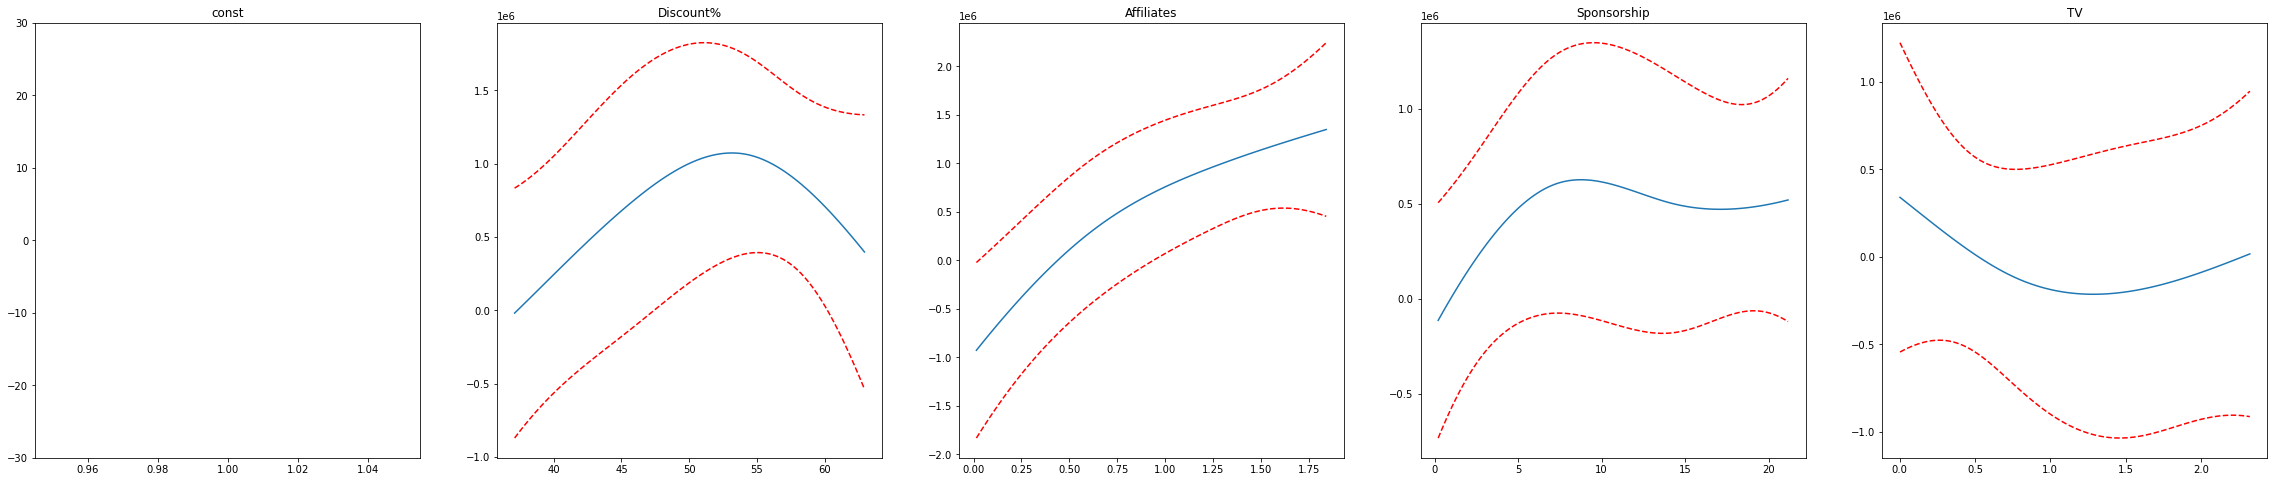

In [492]:
titles = df[['const', 'Discount%', 'Affiliates', 'Sponsorship', 'TV']].columns[0:11]
plt.figure()
fig, axs = plt.subplots(1,5,figsize=(40, 8))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

In [493]:
imp_var = ['const', 'Discount%', 'payday_week', 'holiday_week', 'Total Investment', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Stock Index']

In [494]:
gam = LinearGAM(n_splines=6).fit(df[imp_var], df['gmv'])

In [495]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.4529
Link Function:                     IdentityLink Log Likelihood:                                   -1454.76
Number of Samples:                           51 AIC:                                             2932.4256
                                                AICc:                                            2939.8255
                                                GCV:                                    1524654815491.6548
                                                Scale:                                   975061661800.8098
                                                Pseudo R-Squared:                                   0.5465
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

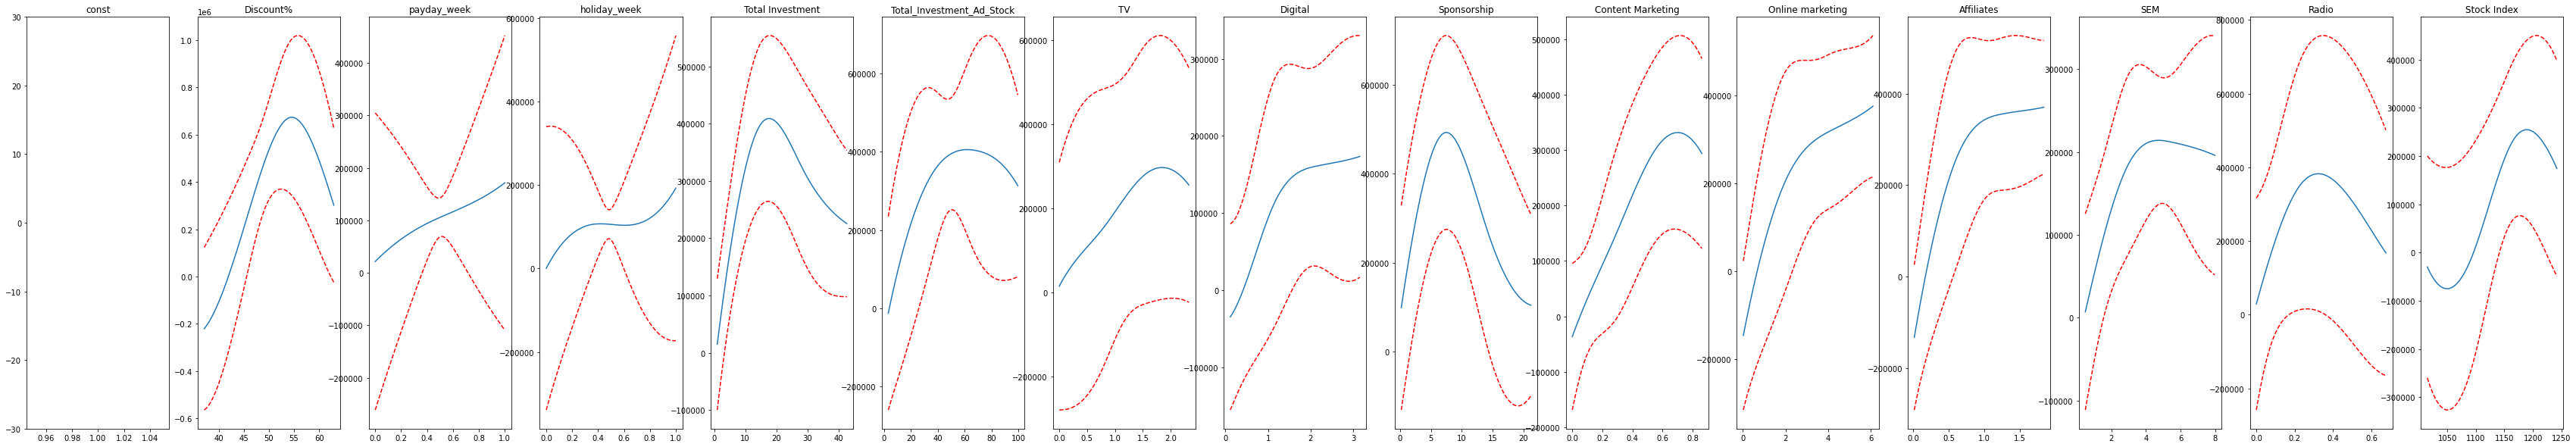

In [496]:
titles = df[imp_var].columns[0:15]
plt.figure()
fig, axs = plt.subplots(1,15,figsize=(60, 10))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

__Homework:__ Make plots with the actual datapoints plotted.

## Building GAM model for `cameraaccessory`

In [596]:
df = cameraaccessory_org_df.copy()
df = sm.add_constant(df)
df.head()

const  Week        gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock  \
0    1.0    28  3975505.0  43.971082       0.000000       0.000000  6.959162                 2.780803  0.666318        0.889703            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
1    1.0    29  4390316.0  44.334867       0.000000       0.000000  6.395062                 2.812865  0.660494        0.886615            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
2    1.0    30  4368719.0  43.608101       0.002629       0.005258  6.414394                 2.865922  0.674663        0.888925            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
3    1.0    31  2790458.0  42.9

In [598]:
gam = LinearGAM(n_splines=6).fit(df[['const', 'Discount%', 'Affiliates', 'Sponsorship']], df['gmv'])

In [599]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       6.595
Link Function:                     IdentityLink Log Likelihood:                                 -1477.6047
Number of Samples:                           50 AIC:                                             2970.3994
                                                AICc:                                            2973.5526
                                                GCV:                                     3557243717829.251
                                                Scale:                                   2724089501197.861
                                                Pseudo R-Squared:                                   0.4344
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

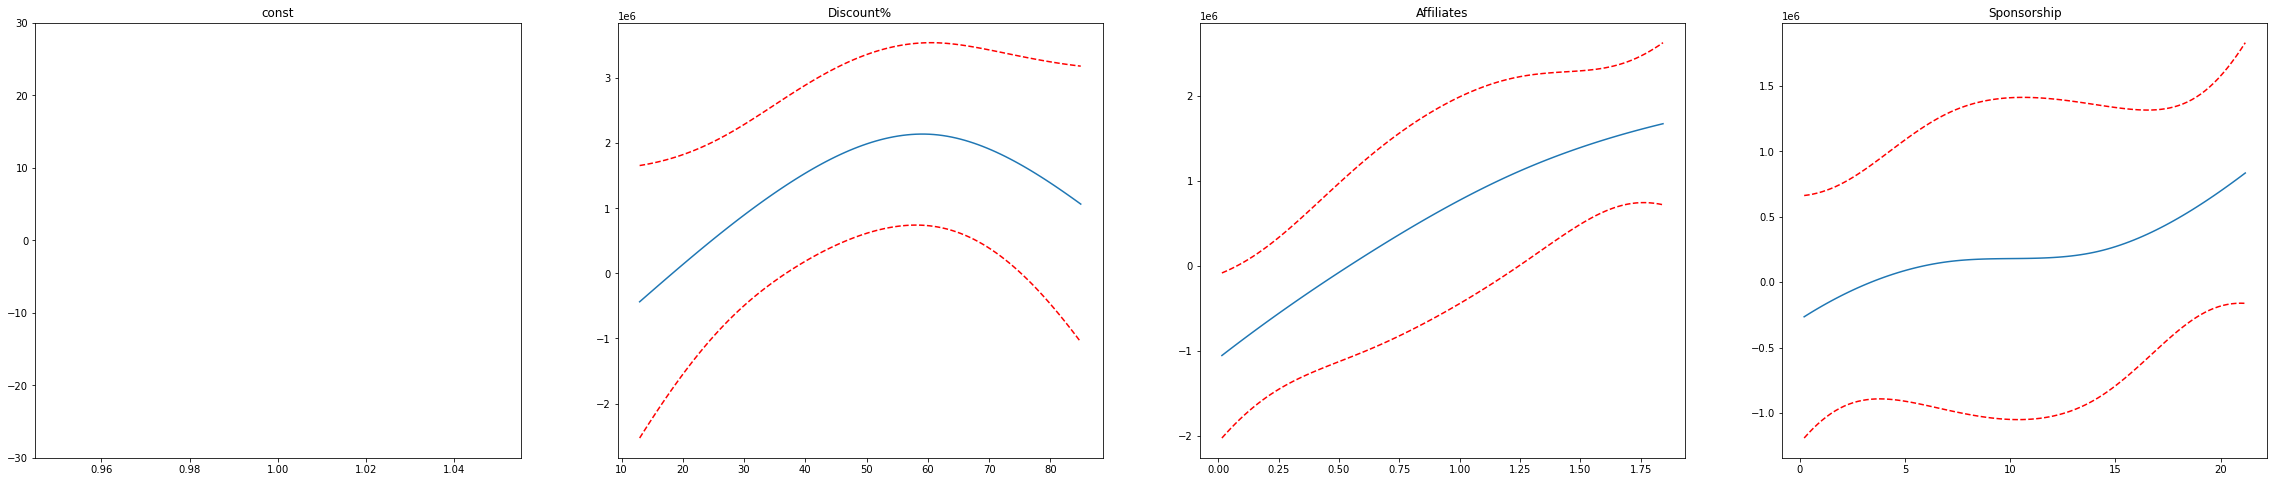

In [601]:
titles = df[['const', 'Discount%', 'Affiliates', 'Sponsorship']].columns[0:11]
plt.figure()
fig, axs = plt.subplots(1,4,figsize=(40, 8))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

In [602]:
imp_var = ['const', 'Discount%', 'payday_week', 'holiday_week', 'Total Investment', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Stock Index']

In [603]:
gam = LinearGAM(n_splines=6).fit(df[imp_var], df['gmv'])

In [604]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       9.913
Link Function:                     IdentityLink Log Likelihood:                                 -1481.6274
Number of Samples:                           50 AIC:                                             2985.0808
                                                AICc:                                            2991.9076
                                                GCV:                                     4535202295719.624
                                                Scale:                                   2952310484068.657
                                                Pseudo R-Squared:                                   0.4339
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

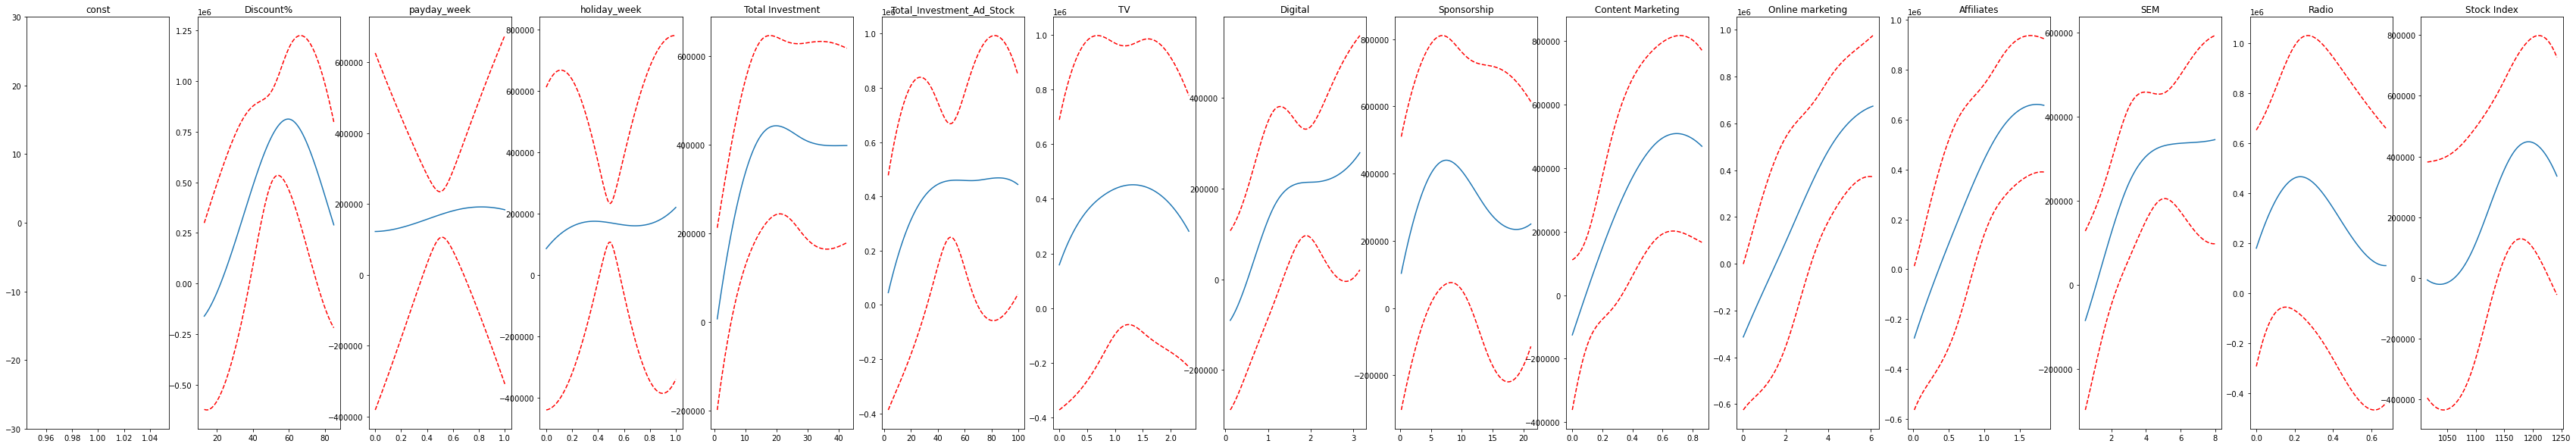

In [605]:
titles = df[imp_var].columns[0:15]
plt.figure()
fig, axs = plt.subplots(1,15,figsize=(60, 10))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

## Building GAM model for `homeaudio`

In [606]:
df = homeaudio_org_df.copy()
df = sm.add_constant(df)
df.head()

const  Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock  \
0    1.0    28  4.573783e+06  31.450813            0.0            0.0  7.369201                 2.863223  0.757054        0.653276            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
1    1.0    29  5.371525e+06  32.966657            0.0            0.0  6.984861                 2.746318  0.764321        0.658756            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
2    1.0    30  4.679828e+06  32.357350            0.0            0.0  7.071749                 2.860538  0.788341        0.703587            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
3    1.0    31  3.4

In [607]:
gam = LinearGAM(n_splines=6).fit(df[['const', 'Discount%', 'Affiliates', 'Sponsorship', 'TV']], df['gmv'])

In [608]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.3808
Link Function:                     IdentityLink Log Likelihood:                                 -1427.3758
Number of Samples:                           48 AIC:                                             2873.5132
                                                AICc:                                            2878.6904
                                                GCV:                                     4738602526372.223
                                                Scale:                                   3277353136154.352
                                                Pseudo R-Squared:                                   0.5923
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

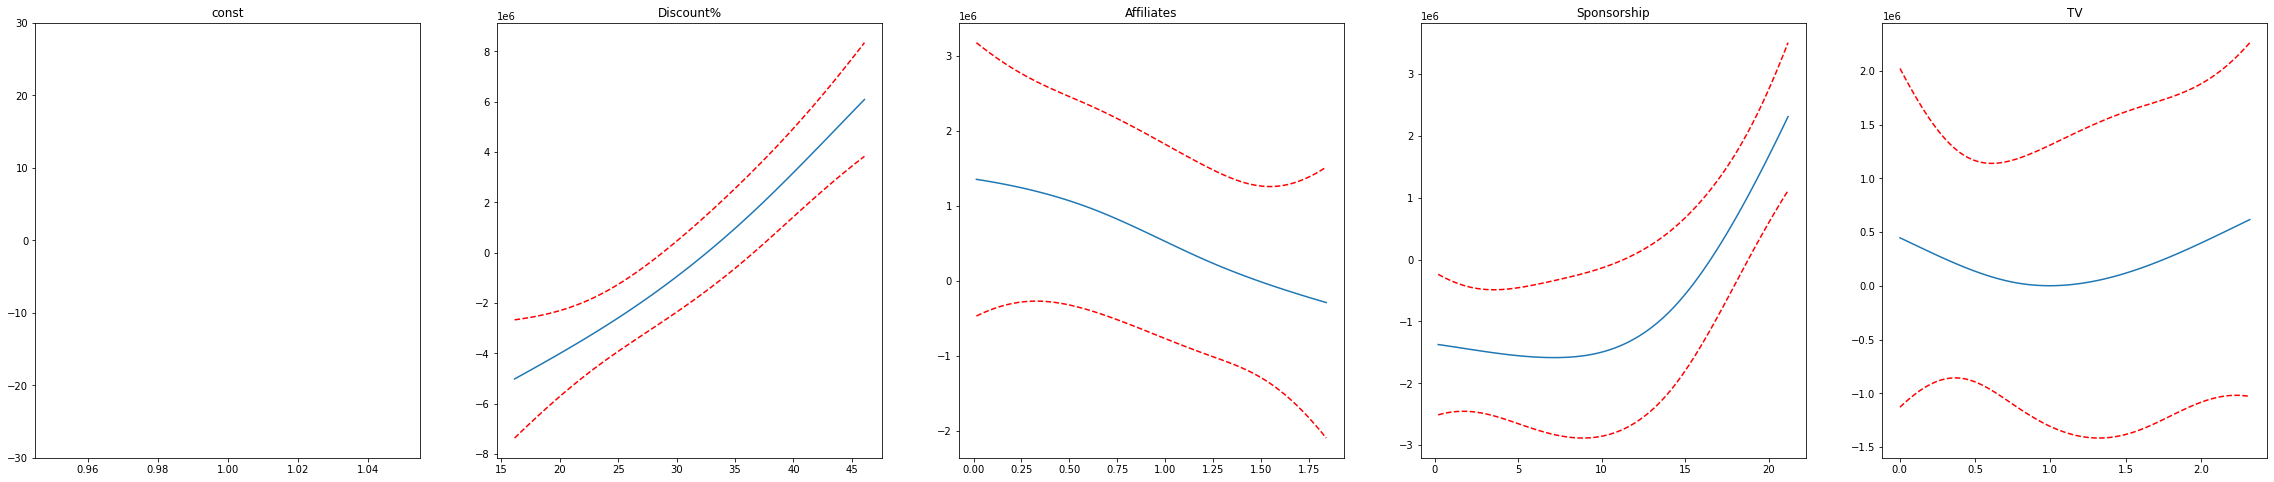

In [609]:
titles = df[['const', 'Discount%', 'Affiliates', 'Sponsorship', 'TV']].columns[0:11]
plt.figure()
fig, axs = plt.subplots(1,5,figsize=(40, 8))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

In [610]:
imp_var = ['const', 'Discount%', 'payday_week', 'holiday_week', 'Total Investment', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Stock Index']

In [611]:
gam = LinearGAM(n_splines=6).fit(df[imp_var], df['gmv'])

In [612]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.7241
Link Function:                     IdentityLink Log Likelihood:                                 -1440.6367
Number of Samples:                           48 AIC:                                             2902.7216
                                                AICc:                                            2909.6536
                                                GCV:                                     6712786259740.022
                                                Scale:                                  4320212674741.0806
                                                Pseudo R-Squared:                                   0.4808
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

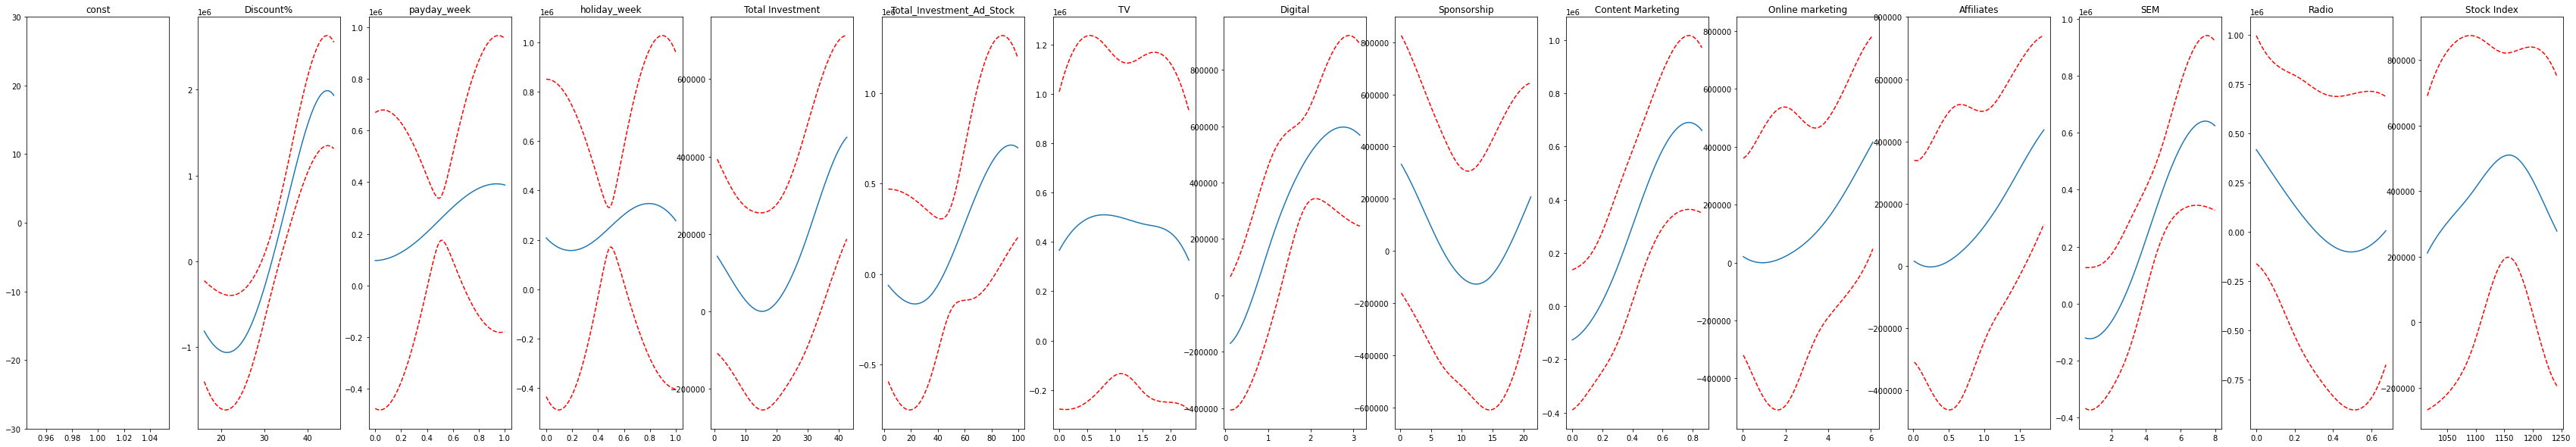

In [613]:
titles = df[imp_var].columns[0:15]
plt.figure()
fig, axs = plt.subplots(1,15,figsize=(60, 10))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

__Considering the top KPIs from the models for our 3 product subcategories, we can see that the GAM models are the best one as they provide a more realistic relationship between gmv and the marketing KPIs.__

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Approach 1: Unconstrained Budget Optimization one variable at a time (`gamingaccessory`)</h2>
</div>

In [513]:
df = gamingaccessory_org_df.copy()
df = sm.add_constant(df)
df.head()

const  Week           gmv  Discount%  deliverybdays  deliverycdays       sla  product_procurement_sla    is_cod  is_mass_market  payday_week  holiday_week  Total Investment  Total Investment_SMA_3  Total Investment_SMA_5  Total Investment_EMA_8  Total_Investment_Ad_Stock     TV  TV_SMA_3  TV_SMA_5  TV_EMA_8  TV_Ad_Stock  Digital  Digital_SMA_3  Digital_SMA_5  Digital_EMA_8  Digital_Ad_Stock  Sponsorship  Sponsorship_SMA_3  Sponsorship_SMA_5  Sponsorship_EMA_8  Sponsorship_Ad_Stock  Content Marketing  Content Marketing_SMA_3  Content Marketing_SMA_5  Content Marketing_EMA_8  Content_Marketing_Ad_Stock  Online marketing  Online marketing_SMA_3  Online marketing_SMA_5  Online marketing_EMA_8  Online_marketing_Ad_Stock  Affiliates  Affiliates_SMA_3  Affiliates_SMA_5  Affiliates_EMA_8  Affiliates_Ad_Stock    SEM  SEM_SMA_3  SEM_SMA_5  SEM_EMA_8  SEM_Ad_Stock  Radio  Radio_SMA_3  Radio_SMA_5  Radio_EMA_8  Radio_Ad_Stock  Other  Other_SMA_3  Other_SMA_5  Other_EMA_8  Other_Ad_Stock  \
0    1.0    28  2.688958e+06  40.174910       0.000000       0.000000  5.429812                 3.213343  0.739402        0.912092            0             0             4.265                   0.000                  0.0000                4.265000                   4.265000  0.054  0.000000    0.0000  0.054000     0.054000    0.633       0.000000         0.0000       0.633000          0.633000        1.854              0.000             0.0000           1.854000              1.854000                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.332000       0.137          0.000000            0.0000          0.137000             0.137000  1.256      0.000     0.0000   1.256000      1.256000    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
1    1.0    29  2.270363e+06  42.688931       0.000000       0.000000  5.326652                 2.721232  0.764291        0.912398            1             0             4.265                   0.000                  0.0000                4.265000                   6.824000  0.054  0.000000    0.0000  0.054000     0.086400    0.633       0.000000         0.0000       0.633000          1.012800        1.854              0.000             0.0000           1.854000              2.966400                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.000                  0.0000                   0.332                   0.531200       0.137          0.000000            0.0000          0.137000             0.219200  1.256      0.000     0.0000   1.256000      2.009600    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
2    1.0    30  2.588844e+06  37.110373       0.000000       0.000000  5.420082                 2.603279  0.767623        0.888934            0             0             4.265                   4.265                  0.0000                4.265000                   8.359400  0.054  0.054000    0.0000  0.054000     0.105840    0.633       0.633000         0.0000       0.633000          1.240680        1.854              1.854             0.0000           1.854000              3.633840                0.0                      0.0                      0.0                      0.0                         0.0             0.332                   0.332                  0.0000                   0.332                   0.650720       0.137          0.137000            0.0000          0.137000             0.268520  1.256      1.256     0.0000   1.256000      2.461760    0.0          0.0          0.0          0.0             0.0    0.0          0.0          0.0          0.0             0.0   
3    1.0    31  1.9

In [514]:
imp_var = ['const', 'Discount%', 'payday_week', 'holiday_week', 'Total Investment', 'Total_Investment_Ad_Stock', 'TV', 'Digital', 'Sponsorship', 'Content Marketing', 'Online marketing', 'Affiliates', 'SEM', 'Radio', 'Stock Index']

In [515]:
gam = LinearGAM(n_splines=6).fit(df[imp_var], df['gmv'])

In [516]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     10.4529
Link Function:                     IdentityLink Log Likelihood:                                   -1454.76
Number of Samples:                           51 AIC:                                             2932.4256
                                                AICc:                                            2939.8255
                                                GCV:                                    1524654815491.6548
                                                Scale:                                   975061661800.8098
                                                Pseudo R-Squared:                                   0.5465
Feature Function                  Lam

<Figure size 432x288 with 0 Axes>

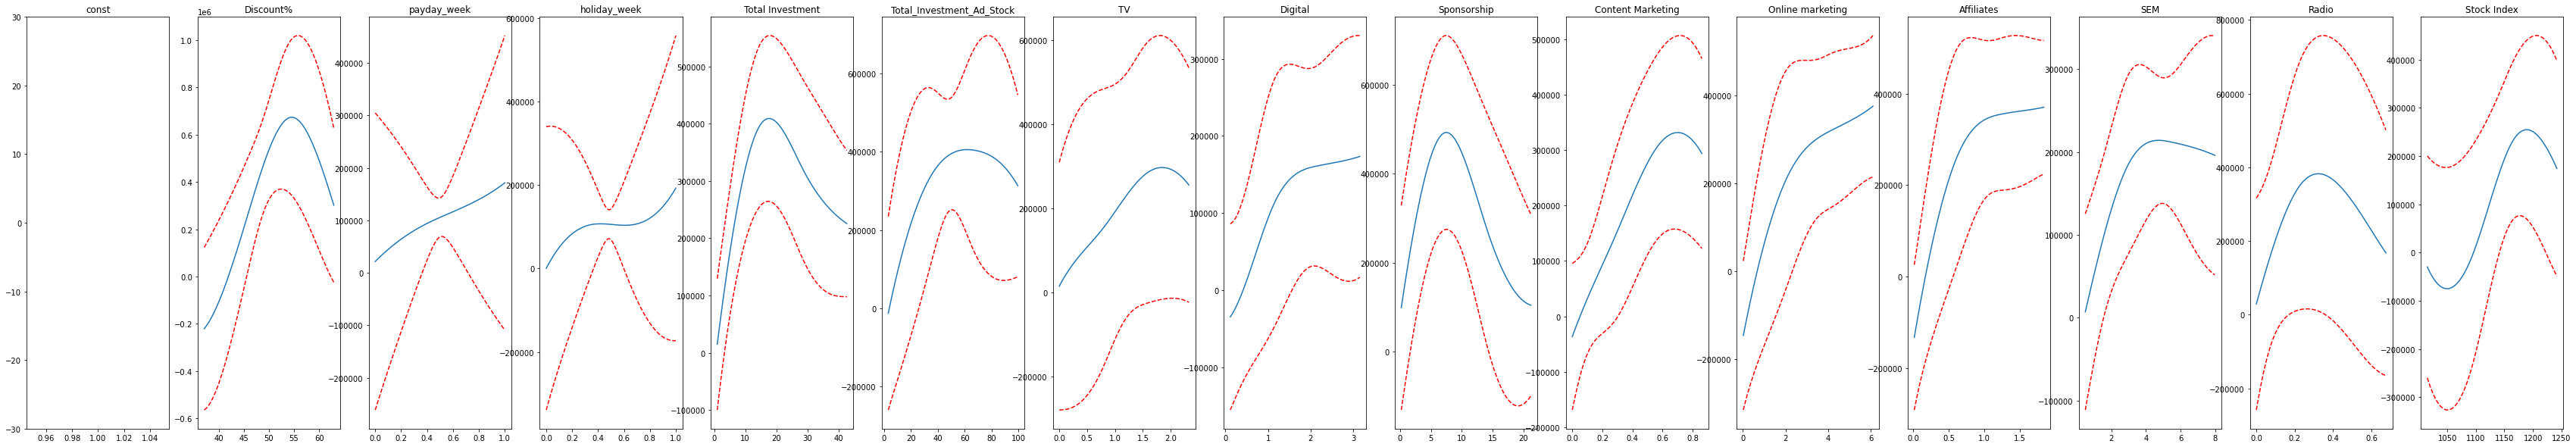

In [517]:
titles = df[imp_var].columns[0:15]
plt.figure()
fig, axs = plt.subplots(1,15,figsize=(60, 10))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

_Take the first row and repeat 100 times. Alternately, take the mean of the rows as well._

In [518]:
df_repeated = pd.concat([df[imp_var].head(1)]*100, ignore_index=True)
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index
0    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
1    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
2    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
3    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
4    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0

#### Optimise Discount%

In [519]:
df['Discount%'].min()

37.11037295081975

In [520]:
df['Discount%'].max()

62.9375

In [521]:
discount_values = np.linspace(df['Discount%'].min(), df['Discount%'].max(), 100)
discount_values

array([37.11037295, 37.37125302, 37.63213309, 37.89301316, 38.15389324,
       38.41477331, 38.67565338, 38.93653345, 39.19741352, 39.45829359,
       39.71917366, 39.98005373, 40.24093381, 40.50181388, 40.76269395,
       41.02357402, 41.28445409, 41.54533416, 41.80621423, 42.0670943 ,
       42.32797437, 42.58885445, 42.84973452, 43.11061459, 43.37149466,
       43.63237473, 43.8932548 , 44.15413487, 44.41501494, 44.67589502,
       44.93677509, 45.19765516, 45.45853523, 45.7194153 , 45.98029537,
       46.24117544, 46.50205551, 46.76293559, 47.02381566, 47.28469573,
       47.5455758 , 47.80645587, 48.06733594, 48.32821601, 48.58909608,
       48.84997615, 49.11085623, 49.3717363 , 49.63261637, 49.89349644,
       50.15437651, 50.41525658, 50.67613665, 50.93701672, 51.1978968 ,
       51.45877687, 51.71965694, 51.98053701, 52.24141708, 52.50229715,
       52.76317722, 53.02405729, 53.28493737, 53.54581744, 53.80669751,
       54.06757758, 54.32845765, 54.58933772, 54.85021779, 55.11

In [522]:
df_repeated['Discount%'] = discount_values
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index
0    1.0  37.110373            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
1    1.0  37.371253            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
2    1.0  37.632133            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
3    1.0  37.893013            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
4    1.0  38.153893            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0

In [523]:
y_pred = gam.predict(df_repeated)
y_pred

array([1221079.91040556, 1228240.41111258, 1236064.46255502,
       1244531.8168561 , 1253622.22613902, 1263315.44252699,
       1273591.21814324, 1284429.30511097, 1295809.45555338,
       1307711.42159371, 1320114.95535515, 1332999.80896092,
       1346345.73453422, 1360132.48419828, 1374339.81007631,
       1388947.46429151, 1403935.19896709, 1419282.76622628,
       1434969.91819227, 1450976.40698829, 1467281.98473754,
       1483866.40356324, 1500709.4155886 , 1517790.77293683,
       1535090.22773114, 1552587.53209474, 1570262.43815085,
       1588094.69802268, 1606064.06383343, 1624150.28770633,
       1642333.12176458, 1660592.31813139, 1678907.62892998,
       1697258.80628356, 1715623.47786478, 1733970.77354402,
       1752267.69874113, 1770481.25887593, 1788578.45936825,
       1806526.30563792, 1824291.80310477, 1841841.95718864,
       1859143.77330934, 1876164.25688672, 1892870.41334061,
       1909229.24809082, 1925207.7665572 , 1940772.97415957,
       1955891.87631777,

In [524]:
df_repeated['gmv_predicted'] = y_pred
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index  gmv_predicted
0    1.0  37.110373            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.221080e+06
1    1.0  37.371253            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.228240e+06
2    1.0  37.632133            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.236064e+06
3    1.0  37.893013            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.244532e+06
4    1.0  38.153893            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.253622e+06

In [525]:
df_repeated['gmv_predicted'].max()

2114480.7817260753

In [526]:
df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index  gmv_predicted
67    1.0  54.589338            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   2.114481e+06

In [527]:
# Discount which gives maximum GMV
df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]['Discount%'].values

array([54.58933772])

#### Optimise Total_Investment_Ad_Stock

In [528]:
df_repeated = pd.concat([df[imp_var].head(1)]*100, ignore_index=True)
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index
0    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
1    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
2    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
3    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
4    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0

In [529]:
df['Total_Investment_Ad_Stock'].min()

3.0572353664

In [530]:
df['Total_Investment_Ad_Stock'].max()

99.40249282877171

In [531]:
Total_Investment_Ad_Stock_values = np.linspace(df['Total_Investment_Ad_Stock'].min(), df['Total_Investment_Ad_Stock'].max(), 100)
Total_Investment_Ad_Stock_values

array([ 3.05723537,  4.03041979,  5.0036042 ,  5.97678862,  6.94997304,
        7.92315746,  8.89634188,  9.8695263 , 10.84271072, 11.81589514,
       12.78907955, 13.76226397, 14.73544839, 15.70863281, 16.68181723,
       17.65500165, 18.62818607, 19.60137049, 20.57455491, 21.54773932,
       22.52092374, 23.49410816, 24.46729258, 25.440477  , 26.41366142,
       27.38684584, 28.36003026, 29.33321467, 30.30639909, 31.27958351,
       32.25276793, 33.22595235, 34.19913677, 35.17232119, 36.14550561,
       37.11869002, 38.09187444, 39.06505886, 40.03824328, 41.0114277 ,
       41.98461212, 42.95779654, 43.93098096, 44.90416538, 45.87734979,
       46.85053421, 47.82371863, 48.79690305, 49.77008747, 50.74327189,
       51.71645631, 52.68964073, 53.66282514, 54.63600956, 55.60919398,
       56.5823784 , 57.55556282, 58.52874724, 59.50193166, 60.47511608,
       61.4483005 , 62.42148491, 63.39466933, 64.36785375, 65.34103817,
       66.31422259, 67.28740701, 68.26059143, 69.23377585, 70.20

In [532]:
df_repeated['Total_Investment_Ad_Stock'] = Total_Investment_Ad_Stock_values
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index
0    1.0   40.17491            0             0             4.265                   3.057235  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
1    1.0   40.17491            0             0             4.265                   4.030420  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
2    1.0   40.17491            0             0             4.265                   5.003604  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
3    1.0   40.17491            0             0             4.265                   5.976789  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
4    1.0   40.17491            0             0             4.265                   6.949973  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0

In [533]:
y_pred = gam.predict(df_repeated)
y_pred

array([1323137.21649869, 1339124.27016931, 1354762.76817798,
       1370054.46216036, 1385001.1037521 , 1399604.44458886,
       1413866.2363063 , 1427788.23054005, 1441372.17892579,
       1454619.83309917, 1467532.94469583, 1480113.26535144,
       1492362.54670164, 1504282.5403821 , 1515874.99802847,
       1527141.67127639, 1538084.31176154, 1548704.67111955,
       1559004.50098609, 1568985.55299681, 1578649.57878736,
       1587998.3299934 , 1597033.55825058, 1605757.01519456,
       1614170.45246099, 1622275.62168552, 1630074.27450382,
       1637568.16255153, 1644759.03746431, 1651648.65087781,
       1658238.75442769, 1664531.09974961, 1670527.43847921,
       1676229.52225215, 1681639.8956945 , 1686764.27539401,
       1691609.17092881, 1696181.09187708, 1700486.54781696,
       1704532.04832661, 1708324.10298418, 1711869.22136783,
       1715173.91305572, 1718244.68762599, 1721088.0546568 ,
       1723710.5237263 , 1726118.60441266, 1728318.80629402,
       1730317.63894854,

In [534]:
df_repeated['gmv_predicted'] = y_pred
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index  gmv_predicted
0    1.0   40.17491            0             0             4.265                   3.057235  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.323137e+06
1    1.0   40.17491            0             0             4.265                   4.030420  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.339124e+06
2    1.0   40.17491            0             0             4.265                   5.003604  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.354763e+06
3    1.0   40.17491            0             0             4.265                   5.976789  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.370054e+06
4    1.0   40.17491            0             0             4.265                   6.949973  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.385001e+06

In [535]:
df_repeated['gmv_predicted'].max()

1740966.3175575018

In [536]:
df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index  gmv_predicted
60    1.0   40.17491            0             0             4.265                    61.4483  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.740966e+06

In [537]:
# Total_Investment_Ad_Stock which gives maximum GMV
df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]['Total_Investment_Ad_Stock'].values

array([61.4483005])

#### Optimise Sponsorship

In [538]:
df_repeated = pd.concat([df[imp_var].head(1)]*100, ignore_index=True)
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index
0    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
1    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
2    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
3    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
4    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0

In [539]:
df['Sponsorship'].min()

0.213

In [540]:
df['Sponsorship'].max()

21.168

In [541]:
Sponsorship_values = np.linspace(df['Sponsorship'].min(), df['Sponsorship'].max(), 100)
Sponsorship_values

array([ 0.213     ,  0.42466667,  0.63633333,  0.848     ,  1.05966667,
        1.27133333,  1.483     ,  1.69466667,  1.90633333,  2.118     ,
        2.32966667,  2.54133333,  2.753     ,  2.96466667,  3.17633333,
        3.388     ,  3.59966667,  3.81133333,  4.023     ,  4.23466667,
        4.44633333,  4.658     ,  4.86966667,  5.08133333,  5.293     ,
        5.50466667,  5.71633333,  5.928     ,  6.13966667,  6.35133333,
        6.563     ,  6.77466667,  6.98633333,  7.198     ,  7.40966667,
        7.62133333,  7.833     ,  8.04466667,  8.25633333,  8.468     ,
        8.67966667,  8.89133333,  9.103     ,  9.31466667,  9.52633333,
        9.738     ,  9.94966667, 10.16133333, 10.373     , 10.58466667,
       10.79633333, 11.008     , 11.21966667, 11.43133333, 11.643     ,
       11.85466667, 12.06633333, 12.278     , 12.48966667, 12.70133333,
       12.913     , 13.12466667, 13.33633333, 13.548     , 13.75966667,
       13.97133333, 14.183     , 14.39466667, 14.60633333, 14.81

In [542]:
df_repeated['Sponsorship'] = Sponsorship_values
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index
0    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     0.213000                0.0             0.332       0.137  1.256    0.0       1177.0
1    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     0.424667                0.0             0.332       0.137  1.256    0.0       1177.0
2    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     0.636333                0.0             0.332       0.137  1.256    0.0       1177.0
3    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     0.848000                0.0             0.332       0.137  1.256    0.0       1177.0
4    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     1.059667                0.0             0.332       0.137  1.256    0.0       1177.0

In [543]:
y_pred = gam.predict(df_repeated)
y_pred

array([1198789.02148727, 1218600.70315669, 1238080.61573561,
       1257213.33868849, 1275983.45147981, 1294375.53357403,
       1312374.16443563, 1329963.92352908, 1347129.39031884,
       1363855.1442694 , 1380125.76484522, 1395925.83151078,
       1411239.92373054, 1426052.62096898, 1440348.50269056,
       1454112.14835976, 1467328.13744106, 1479981.04939892,
       1492055.4636978 , 1503535.9598022 , 1514407.11717657,
       1524653.51528538, 1534259.73359312, 1543210.35156425,
       1551489.94866323, 1559083.10435455, 1565974.39810267,
       1572148.40937207, 1577589.71762721, 1582282.90233258,
       1586212.54295263, 1589363.21895184, 1591719.50979468,
       1593265.99494563, 1593995.08980856, 1593930.553545  ,
       1593103.98125589, 1591546.96804216, 1589291.10900476,
       1586367.99924461, 1582809.23386265, 1578646.40795983,
       1573911.11663707, 1568634.95499531, 1562849.5181355 ,
       1556586.40115856, 1549877.19916543, 1542753.50725705,
       1535246.92053436,

In [544]:
df_repeated['gmv_predicted'] = y_pred
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index  gmv_predicted
0    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     0.213000                0.0             0.332       0.137  1.256    0.0       1177.0   1.198789e+06
1    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     0.424667                0.0             0.332       0.137  1.256    0.0       1177.0   1.218601e+06
2    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     0.636333                0.0             0.332       0.137  1.256    0.0       1177.0   1.238081e+06
3    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     0.848000                0.0             0.332       0.137  1.256    0.0       1177.0   1.257213e+06
4    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     1.059667                0.0             0.332       0.137  1.256    0.0       1177.0   1.275983e+06

In [545]:
df_repeated['gmv_predicted'].max()

1593995.0898085567

In [546]:
df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index  gmv_predicted
34    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633     7.409667                0.0             0.332       0.137  1.256    0.0       1177.0   1.593995e+06

In [547]:
# Sponsorship which gives maximum GMV
df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]['Sponsorship'].values

array([7.40966667])

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>10. Approach 2: Unconstrained Budget Optimization Multiple variable (levers) at a time</h2>
</div>

#### Optimise Discount and Total_Investment_Ad_Stock

In [548]:
df_repeated = pd.concat([df[imp_var].head(1)]*10000, ignore_index=True)
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index
0    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
1    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
2    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
3    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
4    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0

In [549]:
df['Discount%'].min()

37.11037295081975

In [550]:
df['Discount%'].max()

62.9375

In [551]:
Discount_values = np.linspace(df['Discount%'].min(), df['Discount%'].max(), 100)
Discount_values

array([37.11037295, 37.37125302, 37.63213309, 37.89301316, 38.15389324,
       38.41477331, 38.67565338, 38.93653345, 39.19741352, 39.45829359,
       39.71917366, 39.98005373, 40.24093381, 40.50181388, 40.76269395,
       41.02357402, 41.28445409, 41.54533416, 41.80621423, 42.0670943 ,
       42.32797437, 42.58885445, 42.84973452, 43.11061459, 43.37149466,
       43.63237473, 43.8932548 , 44.15413487, 44.41501494, 44.67589502,
       44.93677509, 45.19765516, 45.45853523, 45.7194153 , 45.98029537,
       46.24117544, 46.50205551, 46.76293559, 47.02381566, 47.28469573,
       47.5455758 , 47.80645587, 48.06733594, 48.32821601, 48.58909608,
       48.84997615, 49.11085623, 49.3717363 , 49.63261637, 49.89349644,
       50.15437651, 50.41525658, 50.67613665, 50.93701672, 51.1978968 ,
       51.45877687, 51.71965694, 51.98053701, 52.24141708, 52.50229715,
       52.76317722, 53.02405729, 53.28493737, 53.54581744, 53.80669751,
       54.06757758, 54.32845765, 54.58933772, 54.85021779, 55.11

In [552]:
Total_Investment_Ad_Stock_values = np.linspace(df['Total_Investment_Ad_Stock'].min(), df['Total_Investment_Ad_Stock'].max(), 100)
Total_Investment_Ad_Stock_values

array([ 3.05723537,  4.03041979,  5.0036042 ,  5.97678862,  6.94997304,
        7.92315746,  8.89634188,  9.8695263 , 10.84271072, 11.81589514,
       12.78907955, 13.76226397, 14.73544839, 15.70863281, 16.68181723,
       17.65500165, 18.62818607, 19.60137049, 20.57455491, 21.54773932,
       22.52092374, 23.49410816, 24.46729258, 25.440477  , 26.41366142,
       27.38684584, 28.36003026, 29.33321467, 30.30639909, 31.27958351,
       32.25276793, 33.22595235, 34.19913677, 35.17232119, 36.14550561,
       37.11869002, 38.09187444, 39.06505886, 40.03824328, 41.0114277 ,
       41.98461212, 42.95779654, 43.93098096, 44.90416538, 45.87734979,
       46.85053421, 47.82371863, 48.79690305, 49.77008747, 50.74327189,
       51.71645631, 52.68964073, 53.66282514, 54.63600956, 55.60919398,
       56.5823784 , 57.55556282, 58.52874724, 59.50193166, 60.47511608,
       61.4483005 , 62.42148491, 63.39466933, 64.36785375, 65.34103817,
       66.31422259, 67.28740701, 68.26059143, 69.23377585, 70.20

In [553]:
cross_list = [[x,y] for x in Discount_values for y in Total_Investment_Ad_Stock_values]
cross_list[:10]

[[37.11037295081975, 3.0572353664],
 [37.11037295081975, 4.030419785211835],
 [37.11037295081975, 5.003604204023671],
 [37.11037295081975, 5.976788622835507],
 [37.11037295081975, 6.949973041647342],
 [37.11037295081975, 7.923157460459178],
 [37.11037295081975, 8.896341879271013],
 [37.11037295081975, 9.86952629808285],
 [37.11037295081975, 10.842710716894684],
 [37.11037295081975, 11.815895135706521]]

In [554]:
Discount_values = [x[0] for x in cross_list]
Total_Investment_Ad_Stock_values = [x[1] for x in cross_list]

In [555]:
df_repeated['Discount%'] = Discount_values
df_repeated['Total_Investment_Ad_Stock'] = Total_Investment_Ad_Stock_values
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index
0    1.0  37.110373            0             0             4.265                   3.057235  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
1    1.0  37.110373            0             0             4.265                   4.030420  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
2    1.0  37.110373            0             0             4.265                   5.003604  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
3    1.0  37.110373            0             0             4.265                   5.976789  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
4    1.0  37.110373            0             0             4.265                   6.949973  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0

In [556]:
y_pred = gam.predict(df_repeated)
y_pred

array([1201291.47501641, 1217278.52868703, 1232917.0266957 , ...,
       2059689.10687433, 2054189.01611446, 2048449.98013592])

In [557]:
df_repeated['gmv_predicted'] = y_pred
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index  gmv_predicted
0    1.0  37.110373            0             0             4.265                   3.057235  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.201291e+06
1    1.0  37.110373            0             0             4.265                   4.030420  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.217279e+06
2    1.0  37.110373            0             0             4.265                   5.003604  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.232917e+06
3    1.0  37.110373            0             0             4.265                   5.976789  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.248209e+06
4    1.0  37.110373            0             0             4.265                   6.949973  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   1.263155e+06

In [558]:
df_repeated['gmv_predicted'].max()

2512521.447395741

In [559]:
df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index  gmv_predicted
6760    1.0  54.589338            0             0             4.265                    61.4483  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0   2.512521e+06

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>12. Approach 3: Optimise two channels in presence to total budget constraint</h2>
</div>

#### Optimise two channels in presence to total budget constraint: Content_Marketing and Radio

In [560]:
df_repeated = pd.concat([df[imp_var].head(1)]*100, ignore_index=True)
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM  Radio  Stock Index
0    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
1    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
2    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
3    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0
4    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854                0.0             0.332       0.137  1.256    0.0       1177.0

In [561]:
df['Content Marketing'].min(), df['Content Marketing'].max()

(0.0, 0.861)

In [562]:
df['Radio'].min(), df['Radio'].max()

(0.0, 0.675)

#####  Let's assume to total budget for Content Marketing and Radio both combined is 1.1. 

Let's see how to optimize and allot in both

In [563]:
Budget = 1.1

In [564]:
Content_Marketing_values = np.linspace(df['Content Marketing'].min(), df['Content Marketing'].max(), 100)
Content_Marketing_values

array([0.        , 0.00869697, 0.01739394, 0.02609091, 0.03478788,
       0.04348485, 0.05218182, 0.06087879, 0.06957576, 0.07827273,
       0.0869697 , 0.09566667, 0.10436364, 0.11306061, 0.12175758,
       0.13045455, 0.13915152, 0.14784848, 0.15654545, 0.16524242,
       0.17393939, 0.18263636, 0.19133333, 0.2000303 , 0.20872727,
       0.21742424, 0.22612121, 0.23481818, 0.24351515, 0.25221212,
       0.26090909, 0.26960606, 0.27830303, 0.287     , 0.29569697,
       0.30439394, 0.31309091, 0.32178788, 0.33048485, 0.33918182,
       0.34787879, 0.35657576, 0.36527273, 0.3739697 , 0.38266667,
       0.39136364, 0.40006061, 0.40875758, 0.41745455, 0.42615152,
       0.43484848, 0.44354545, 0.45224242, 0.46093939, 0.46963636,
       0.47833333, 0.4870303 , 0.49572727, 0.50442424, 0.51312121,
       0.52181818, 0.53051515, 0.53921212, 0.54790909, 0.55660606,
       0.56530303, 0.574     , 0.58269697, 0.59139394, 0.60009091,
       0.60878788, 0.61748485, 0.62618182, 0.63487879, 0.64357

In [565]:
Radio_values = [Budget - x for x in Content_Marketing_values]
Radio_values

[1.1,
 1.0913030303030304,
 1.0826060606060608,
 1.073909090909091,
 1.0652121212121213,
 1.0565151515151516,
 1.047818181818182,
 1.0391212121212121,
 1.0304242424242425,
 1.0217272727272728,
 1.0130303030303032,
 1.0043333333333335,
 0.9956363636363638,
 0.986939393939394,
 0.9782424242424244,
 0.9695454545454547,
 0.960848484848485,
 0.9521515151515152,
 0.9434545454545455,
 0.9347575757575759,
 0.9260606060606061,
 0.9173636363636365,
 0.9086666666666667,
 0.8999696969696971,
 0.8912727272727274,
 0.8825757575757577,
 0.8738787878787879,
 0.8651818181818183,
 0.8564848484848486,
 0.847787878787879,
 0.8390909090909092,
 0.8303939393939395,
 0.8216969696969698,
 0.8130000000000002,
 0.8043030303030304,
 0.7956060606060606,
 0.786909090909091,
 0.7782121212121214,
 0.7695151515151517,
 0.760818181818182,
 0.7521212121212122,
 0.7434242424242425,
 0.7347272727272729,
 0.7260303030303031,
 0.7173333333333335,
 0.7086363636363637,
 0.6999393939393941,
 0.6912424242424244,
 0.68254545454

In [566]:
df_repeated['Content Marketing'] = Content_Marketing_values
df_repeated['Radio'] = Radio_values
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM     Radio  Stock Index
0    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.000000             0.332       0.137  1.256  1.100000       1177.0
1    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.008697             0.332       0.137  1.256  1.091303       1177.0
2    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.017394             0.332       0.137  1.256  1.082606       1177.0
3    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.026091             0.332       0.137  1.256  1.073909       1177.0
4    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.034788             0.332       0.137  1.256  1.065212       1177.0

In [567]:
y_pred = gam.predict(df_repeated)
y_pred

array([1155314.34805047, 1168480.04509375, 1181533.12193767,
       1194478.76222858, 1207322.14961285, 1220068.46773683,
       1232722.9002469 , 1245290.63078942, 1257776.84301075,
       1270186.72055725, 1282525.44707528, 1294798.20621121,
       1307010.1816114 , 1319166.55692222, 1331272.51579002,
       1343333.24186117, 1355353.91878203, 1367339.73019897,
       1379295.85975835, 1391227.49110653, 1403139.80788987,
       1415037.99375474, 1426927.2323475 , 1438812.70731452,
       1450699.60230215, 1462593.10095676, 1474498.38692471,
       1486420.64385236, 1498365.05538608, 1510336.80517223,
       1522341.07685718, 1534383.05408728, 1546467.9205089 ,
       1558600.85976841, 1570784.90696573, 1583014.5030151 ,
       1595281.9402843 , 1607579.51114115, 1619899.50795344,
       1632234.22308897, 1644575.94891553, 1656916.97780093,
       1669249.60211296, 1681566.11421942, 1693858.80648811,
       1706119.97128684, 1718341.90098339, 1730516.88794557,
       1742637.22454117,

In [568]:
df_repeated['gmv_predicted'] = y_pred
df_repeated.head()

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM     Radio  Stock Index  gmv_predicted
0    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.000000             0.332       0.137  1.256  1.100000       1177.0   1.155314e+06
1    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.008697             0.332       0.137  1.256  1.091303       1177.0   1.168480e+06
2    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.017394             0.332       0.137  1.256  1.082606       1177.0   1.181533e+06
3    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.026091             0.332       0.137  1.256  1.073909       1177.0   1.194479e+06
4    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.034788             0.332       0.137  1.256  1.065212       1177.0   1.207322e+06

In [569]:
df_repeated['gmv_predicted'].max()

2059555.9249194118

In [570]:
df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]

const  Discount%  payday_week  holiday_week  Total Investment  Total_Investment_Ad_Stock     TV  Digital  Sponsorship  Content Marketing  Online marketing  Affiliates    SEM     Radio  Stock Index  gmv_predicted
86    1.0   40.17491            0             0             4.265                      4.265  0.054    0.633        1.854           0.747939             0.332       0.137  1.256  0.352061       1177.0   2.059556e+06

In [571]:
# Content Marketing and Radio budgets which gives maximum GMV
print(df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]['Content Marketing'].values)
print(df_repeated[df_repeated['gmv_predicted'] == df_repeated['gmv_predicted'].max()]['Radio'].values)

[0.74793939]
[0.35206061]


# Recommendations 

### <font color = blue>Camera Accessory:</font>
 - Company should promote `Lens`, `Camera Batteries` & `Camera Battery Chargers` as they fetch the highest revenue.
 - Advertisement spends on `TV` has a positive impact on revenue. One unit of TV spend can boost the revenue by `0.105` units (update value for latest model). `Content Marketing` spends on the other hand impacts negatively.
 - `Mass-market` products are better contributors to the increased revenue in comparison to the Luxury products.
 - Higher percentage of `Discounts` in general given for this sub category works adversely towards bringing down the revenue. 

### <font color = blue>__Gaming Accessory:__</font>
 - Company should promote `Gaming Headset`, `Gaming Mouse` & `Gamepad` as they fetch the highest revenue. On the contrary, `Gaming Memory Cards` results in loss.
 - Advertisement spends on `Online Marketing, Radio & Others` have a positive cumulative impact on revenue. `Sponsorship` spends on the other hand has a negative cumulative effect.
 - `Mass-market` products are better contributors to the increased revenue in comparison to the Luxury products.
 - Higher percentage of `Discounts` in general given for this sub category works adversely towards bringing down the revenue. 

### <font color = blue>__Home Audio:__</font>
 - Company should promote `Home Audio Speakers` & `FM Radios as they fetch the highest revenue.
 - `Mass-market` products are better contributors to the increased revenue in comparison to the Luxury products.
 - `Radio Adstock` (carry over effect of Radio Advertisement) spends  helps to boost the revenue to a significant extent.
 - Advertisement spends on `Sponsorship` has a positive impact on revenue. `Content Marketing` spends on the other hand impacts negatively.
 - `COD payments` in general for this sub category are bad in bringing down the revenue. 
 
### <font color = blue>__In General:__</font> 
 - Most of the sales take place when Discount% is between 50-60%. However, that doesnt necessarily help in boosting the revenue. EDA shows that an average discount% between 10-20% is the most profitable for the company specially among luxury items.
 - In general most of the Home Audio items sold are luxury items and hence, customers prefer to use COD instead of paying upfront.
 - During festive time(eg. Thanksgiving) more investment is made on Advertisement and good promotional offers were rolled out. This usually boosts the revenue. However just providing discounts without properly adertising for it on several media channels doesn't help. We have seen that for the weeks 32 - 35(August), revenue generated was the lowest from all 3 product subcategories even though median discount% was raised after the initial drought. In fact, this dip in revenue can be observed as a direct relation to minimum amount of total investment in Ads during the given timeframe.